<a href="https://colab.research.google.com/github/guramritpalsaggu/HUSE-Tensorflow/blob/master/HUSE_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Importing all the required dependencies

In [0]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python.keras.preprocessing import text, sequence
from tensorflow.python.keras.layers import Dense,Input
from tensorflow.python.keras.layers import Dropout,Embedding
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image
import glob
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import imgaug as aug
import imgaug.augmenters as iaa
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics.pairwise import cosine_distances
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading the training_data.csv as dataframe using Pandas libraray

In [0]:
df = pd.read_csv('/content/drive/My Drive/HUSE/training.csv')
df.head()

,image,name,classes
0,5da821eb7f3e301b4504bb4a_0.jpg,Marc Jacobs Beauty Eye-Conic Longwear Eyeshad...,beauty<makeup<eyeshadow
1,5da81cde7861c2af6a5a88cf_0.jpg,Marc Jacobs Beauty Eye-Conic Longwear Eyeshad...,beauty<makeup<eyeshadow
2,5da8219a6504fb65da0050aa_0.jpg,Prada Wool sweater,clothing<knitwear<fine knit
3,5da821856504fb65cea703cf_0.jpg,Prada Printed silk-satin twill straight-leg p...,clothing<pants<straight leg
4,5da82200b25b035d1d17bec6_0.jpg,Prada Cropped chain-trimmed printed crepe str...,clothing<pants<straight leg


In [0]:
df.shape

(65714, 3)

In [0]:
df.isnull().any()       #Check for any null values in the dataframe

image      False
name       False
classes    False
dtype: bool

Extract the images.zip folder using unzip to move that folder to drive.

In [0]:
!unzip '/content/drive/My Drive/HUSE/images.zip'

In [0]:
path, dirs, files = next(os.walk("/content/netaporter_gb_images"))
file_count = len(files)
print(file_count)

65714


 Hierarchical universal semantic embeddings Model

<img src="https://drive.google.com/uc?id=16wQ1Z2o2MitrrK9lbNmGFec3gM8_qG8D" width="600" layout="centre">

####PART 1

####Image Embeddings Input Model

Images are represented to vector embedding space using the img2vec pretrained library. This library uses the ResNet50 model in TensorFlow Keras, pre-trained on Imagenet, to generate image embeddings.


Installing the library and its dependencies using pip

In [0]:
!pip install git+git://github.com/jaredwinick/img2vec-keras.git

####Transfer Learning

Importing the Img2Vec library and initializing its object.

In [0]:
from img2vec_keras import Img2Vec
img2vec = Img2Vec()

102973440/102967424 [==============================] - 1s 0us/step


Displaying a Image

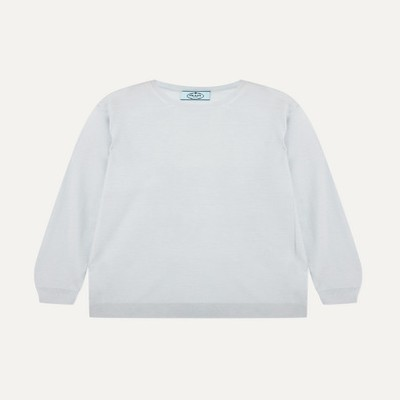

In [0]:
Image('/content/netaporter_gb_images/5da8219a6504fb65da0050aa_0.jpg')

Using the glob library to append paths of all the images in the list.

In [0]:
image_paths = []
image_paths.extend(glob.glob('/content/netaporter_gb_images' +  '/*.jpg'))

In [0]:
len(image_paths)

65714

####Image Augmentation
Data augmentation is a powerful technique which helps in almost every case for improving the robustness of a model. 

Augmenters of imgaug library are used to augment images.

In [0]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

Using the img2vec pretrained model to get the vector embeddings of all the images and storing them in dictionary with image path and vector pairs.
The image embeddings generated from this model has shape of (1,2048) for each image, but we require embeddings size to be of 512 before passing them to image tower.

In [0]:
image_vectors = {}
for image_path in image_paths:
    # image = seq.augment_image(image_path)    #this can be used to add augmentations appropriately
    vector = img2vec.get_vec(image_path)
    image_vectors[image_path] = vector

As we need to reduce the dimensionality of the image embeddings we can using the common dimensionality reduction known as Principle Component Analysis(PCA).

Principal Component Analysis (PCA) is an unsupervised technique used to preprocess and reduce the dimensionality of high-dimensional data while explaining the maximum variance and summarize the most information in the data that are mutually uncorrelated.

We stored the values of the image embeddings in the stack.

In [0]:
X = np.stack(list(image_vectors.values()))

Initialize the PCA using the sklearn decomposition. n_components parameter is passed which is responsible for number of components to keep and is set to 512 for image embeddings.

In [0]:
pca = PCA(n_components=512)
images = pca.fit_transform(X)
print('Cumulative explained variation for 512 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))
print(np.shape(images))

Cumulative explained variation for 512 principal components: 0.9210123020687525
(65714, 512)


In [0]:
np.save('image_embeddings.npy', images)

Final Image embeddings with shape 65714*512 can stored as numpy file.

####Text  Embeddings Input Model 

####Text Preprocessing

In [0]:
# decontracting all contracted words
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# Cleaning the texts
def preprocessing(phrase):
    result = decontracted(str(phrase))      
    result = result.strip()             #remove leading and ending spaces
    result = result.split()             #Split to tokenize words
    ps = PorterStemmer()                #reducing words to their word stem or base
    result = [ps.stem(word) for word in result if not word in set(stopwords.words('english'))]  #remove the stopwords
    result = ' '.join(result)           #Joining all the tokens 
    return result

In [0]:
description = df['name'].str.lower()        #Convert text to lowercase
sentences = description.map(preprocessing)

In [0]:
sentences

0        marc jacob beauti eye-con longwear eyeshadow p...
1        marc jacob beauti eye-con longwear eyeshadow p...
2                                       prada wool sweater
3           prada print silk-satin twill straight-leg pant
4        prada crop chain-trim print crepe straight-leg...
                               ...                        
65709                         illamasqua lipstick - climax
65710       chloé marci medium textured-leath shoulder bag
65711    gucci sylvi mini leather-trim calf hair should...
65712    marc jacob beauti enamor hi-shin lip lacquer -...
65713      halfpenni london luella organza-trim satin gown
Name: name, Length: 65714, dtype: object

####Transfer Learning

We used BERT pretrained text model for representing text into embedding space. Text embedding created from this part of the model are forwarded into the text tower.

Installing the neccessary dependencies for BERT pretrained Model

In [0]:
!pip install -U sentence-transformers

In [0]:
!git clone https://github.com/UKPLab/sentence-transformers.git

Cloning into 'sentence-transformers'...
remote: Enumerating objects: 732, done.
remote: Total 732 (delta 0), reused 0 (delta 0), pack-reused 732
Receiving objects: 100% (732/732), 210.89 KiB | 388.00 KiB/s, done.
Resolving deltas: 100% (497/497), done.


In [0]:
cd sentence-transformers/

/content/sentence-transformers


In [0]:
!pip install -e .

First download a pretrained model.

In [0]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:45<00:00, 8.96MB/s]


Providing sentences to the model to make embeddings.

In [0]:
texts = model.encode(sentences)
print(np.shape(texts))

(65714, 768)


We now have a list of numpy arrays with the embeddings. BERT model make embeddings of dimmesions (1,768) for each sentence.

As dimmensions are (1,768) for each sentence and we need 512 salient tokens for our Text Tower so we use PCA dimesnionality reduction method to get top 512 tokens which explain the most variance of the embeddings.

In [0]:
pca = PCA(n_components=512)
texts = pca.fit_transform(texts)
print('Cumulative explained variation for 512 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))
print(np.shape(texts))

Cumulative explained variation for 512 principal components: 0.9960515830713841
(65714, 512)


In [0]:
np.save('/content/text_embeddings.npy', texts) 

####Universal Sentence Encoder

We used universal sentence encoder to make embeddings of the classes.

Replace < in the class name by space so that sentences generalizes well.

Get all the unique classes there are 48 unique classes.

In [0]:
df['classes'] = df['classes'].str.replace('<',' ')
all_classes = df['classes'].unique()
len(all_classes)

48

Downloading the model from tensorflow hub and extracting it.

In [0]:
!mkdir /content/universal  
!curl -L "https://tfhub.dev/google/universal-sentence-encoder-large/3?tf-hub-format=compressed" | tar -zxvC /content/universal/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
./
./tfhub_module.pb
./variables/
./variables/variables.data-00000-of-00001
 97  745M   97  726M    0     0  61.4M      0  0:00:12  0:00:11  0:00:01 59.1M./variables/variables.index
./assets/
./saved_model.pb
100  745M  100  745M    0     0  61.6M      0  0:00:12  0:00:12 --:--:-- 58.3M


In [0]:
#This function is used to create embeddings for classes using universal sentence encoder as given in paper.
def embed_useT(module):
    with tf.Graph().as_default():
        sentences = tf.compat.v1.placeholder(tf.string)
        embed = hub.Module(module)
        embeddings = embed(sentences)
        session = tf.compat.v1.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})
embed_fn = embed_useT('/content/universal')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Using the above function to represent classes in embedding space using pretrained model

In [0]:
class_name = all_classes
labels_embeddings = embed_fn(class_name)
print(np.shape(labels_embeddings))

(48, 512)


In [0]:
np.save('/content/class_embeddings.npy',labels_embeddings)
np.save('/content/class_name.npy', class_name)

In [0]:
class_name

array(['beauty makeup eyeshadow', 'clothing knitwear fine knit',
       'clothing pants straight leg', 'clothing tops blouses',
       'shoes sandals flat', 'clothing jumpsuits full length',
       'shoes sandals high heel', 'beauty makeup lipstick',
       'beauty makeup foundation', 'beauty makeup lipgloss',
       'beauty skincare moisturizer', 'shoes pumps mid heel',
       'clothing beachwear one-piece', 'shoes sneakers low top',
       'clothing dresses gowns', 'clothing dresses midi',
       'clothing tops shirts', 'clothing tops tanks and camis',
       'clothing jackets blazers', 'clothing tops t-shirts',
       'jewelry and watches fashion jewelry necklaces',
       'shoes sandals mid heel',
       'jewelry and watches fine jewelry necklaces',
       'jewelry and watches fashion jewelry earrings',
       'jewelry and watches fine jewelry rings', 'beauty skincare serum',
       'jewelry and watches fine jewelry earrings',
       'bags shoulder bags shoulder bags', 'bags tote b

Universal sentence encoder make embeddings of dimmensions (1,512) by default for all each sentence and we can use these embeddnings as it in our model.

####Image Tower Model and Text Tower Model. 

This part of the model is build as it is taking input from image and text pretrained model embeddings and parameters used are mentioned in the HUSE paper. The image tower consists of 5 hidden layers of 512 hidden
units each and text tower consists of 2 hidden layers of 512 hidden units each with RELU non-linearity and dropout of 0.15 is used between all hidden layers of both towers and the resulting embedding are L2 normalized.

Model passes emmbeddings from image tower and text
tower through a shared fully connected layer and the model is trained using softmax cross entropy loss.

<img src="https://drive.google.com/uc?id=1zb6ks65gSxHTt-Gp-pur_h2elndbme8L" width="400" layout="centre">




In [0]:
inputImage = Input(shape=(512, ))
inputText =  Input(shape=(512, ))
 
#constructing the image tower which consists of 5X Dense layers with 512 hidden units with Dropout of 0.15 between them
x = Dense(512, 'relu')(inputImage)
x = Dropout(0.15)(x)
x = Dense(512, 'relu')(x)
x = Dropout(0.15)(x)
x = Dense(512, 'relu')(x)
x = Dropout(0.15)(x)
x = Dense(512, 'relu')(x)
x = Dropout(0.15)(x)
outputImage = Dense(512, 'relu')(x)

# constructing the text tower which consists of 2X Dense layers with 512 hidden units with Droupout of 0.15 between them
y = Dense(512, 'relu')(inputText)
y = Dropout(0.15)(y)
outputText = Dense(512, 'relu')(y)


outputModel = Dense(48, 'softmax') # same classifier layer for image and text tower

# passing the L2 normalized image and text embeddings to the classifier layer 
outImage = outputModel(tf.keras.backend.l2_normalize(outputImage))
outText = outputModel(tf.keras.backend.l2_normalize(outputText))

Model takes two inputs image and text and correspondingly two outputs are there.

In [0]:
# Now we'll construct 5 models based on the requirements each model would have different input and output from each other

model = Model([inputImage, inputText], [outImage, outText]) # main model with both image and text embeddings as input and class as output

# models for creating the image and text embedding in the universal shared space
imageEmbeddings = Model(inputImage, outputImage) 
textEmbeddings = Model(inputText, outputText)

# models for obtaining class outout from image or text data
imageModel = Model(inputImage, outImage)
textModel = Model(inputText, outText)

Now we see the architecure of our model. Type and Number of layers, input ouput shapes and other parameters involved.

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          262656      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      dropout[0][0]                    
____________________________________________________________________________________________

####Incorporating three losses into the model architecture

The cosine distance between two embeddings
is treated as edge weight so that two semantically similar classes have a lower edge weight compared to two semantically different classes. This function is used to calculate cosine distance between two embeddings.

In [0]:
from sklearn.metrics.pairwise import cosine_distances
def dist(embedding1, embedding2):
    return cosine_distances(embedding1, embedding2)

####Cross Model Gap Loss

This function calculates the cross modal loss, it returns the cosine distance between the image and text embeddings of the same class.

<img src="https://drive.google.com/uc?id=1hbhF8VxhcjgR0FI7QZDLPTpvdPy2W3_M" width="400">

In [0]:
def loss_modal(embeddingsImage, embeddingsText):
    distance = dist(embeddingsImage, embeddingsText)
    return (1/batch_size) * np.sum(np.diagonal(distance))

####Sementic Similarity Loss

This function calculates the semantic loss, it basically calculates the distance between the image embeddings and text embeddings of different classes
and then they are compared to the distance between the respective class embeddings and the loss is calculated 

<img src="https://drive.google.com/uc?id=19GqY4h7PHo4gTzn7DGls8vvY_DBqrw_w" width="400">

In [0]:
def loss_class(embeddingsImage, embeddingsText, classes, margin):
    distanceImage = dist(embeddingsImage, embeddingsImage) 
    distanceText = dist(embeddingsText, embeddingsText)
    distClasses = dist(classes, classes)
    
    multiplier = np.zeros((batch_size, batch_size))
    try:
        for i in range(batch_size):
            for j in range(i+1, batch_size):
                if distClasses[i][j] <= margin:
                    multiplier[i][j] = 1
    except:
        print(distClasses.shape, classes.shape)
    
    imageLoss = np.multiply(multiplier, (distanceImage - distClasses)**2)  #use np.power() if the tolerance is low
    textLoss = np.multiply(multiplier, (distanceText - distClasses)**2)

    totalLoss = np.sum(imageLoss + textLoss) * (1/batch_size**2)

    return totalLoss

####Class Level Similarity Loss

This function calculates the classification loss, we use simple categorical crossentropy loss for this.

<img src="https://drive.google.com/uc?id=1ljP2SDj2mX-fZKJSGzfqECaPhh1VrNTJ" width="400">


In [0]:
def loss_classification(predicted_labels, correct_labels):
    return categorical_crossentropy(correct_labels, predicted_labels)

This function is used to train taking input the batch of images and text and their corresponding label embeddings. As in our model as loss and trainable variables are updated at each step we have used the GradientTape() function of Tensorflow. The resources held by a GradientTape are released as soon as GradientTape.gradient() method is called. We used them to optimize loss and trainable variables of our model.

In [0]:
def train_step(images_batch, text_batch, labels_batch, labels_embeddings):
    with tf.GradientTape() as tape:
        image_predictions = imageModel(images_batch, training=True)

        text_predictions = textModel(text_batch, training=True)

        image_embeddings = imageEmbeddings(images_batch, training=True)
        image_embeddings = tf.keras.backend.l2_normalize(image_embeddings)
        image_embeddings = np.array(image_embeddings)

        text_embeddings = textEmbeddings(text_batch, training=True)
        text_embeddings = tf.keras.backend.l2_normalize(text_embeddings)
        text_embeddings = text_embeddings.numpy()

        # calcualting all the necessary kind of losses
        classification_loss = loss_classification(image_predictions, labels_batch) + loss_classification(text_predictions, labels_batch)
        class_loss = loss_class(image_embeddings, text_embeddings, labels_embeddings, margin)
        modal_loss = loss_modal(image_embeddings, text_embeddings)

        total_loss = alpha * classification_loss + beta * class_loss + gamma * modal_loss

        history.append(total_loss.numpy().mean())

        # calcualting grads and optimizing the trainable params.
        optimizer = optimizers.RMSprop(lr=1e-3, decay=0.9)
        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        #calculating the accuracy
        predictions = model([images_batch, text_batch])
        predictions = np.array(predictions)
        avg_predictions = predictions[0] + predictions[1]
        correct_labels = np.array([np.argmax(i) for i in labels_batch])
        preds = np.array([np.argmax(i) for i in avg_predictions])
        print(accuracy_score(correct_labels, preds), f1_score(correct_labels, preds, average='weighted'))

In [0]:
#loading intial embeddings obtained by pre trained networks
images = np.load('/content/image_embeddings.npy')
texts = np.load('/content/text_embeddings.npy')
labels_embeddings = np.load('/content/class_embeddings.npy')
class_name = np.load('/content//class_name.npy', allow_pickle=True)

In [0]:
class_labels_map = {}
inv_class_labels_map = {}
for i in range(0, 48):
    class_labels_map[i] = class_name[i]
    inv_class_labels_map[class_name[i]] = i

In [0]:
def repair(x):
    x = x.replace('<', ' ')
    return x

In [0]:
#one hot encoding labels for training
labels = df['classes'].map(repair)
labels_num = labels.map(inv_class_labels_map)
labels = to_categorical(labels_num, 48)

In [0]:
labels_num

0         0
1         0
2         1
3         2
4         2
         ..
65709     7
65710    28
65711    27
65712     9
65713    14
Name: classes, Length: 65714, dtype: int64

We are now going to train our model and all the parameters required to train the model is defined before hand. We have trained thr model with batch size of 32 and for 1 epoch.

In [0]:
#training
history = []
batch_size = 32
margin = 0.5
alpha, beta, gamma = 1, 1, 1
EPOCHS = 1
for epoch in tqdm(range(EPOCHS)):
    for i in tqdm(range(batch_size,len(images), batch_size)):
        images_batch = images[i-32:i]
        texts_batch = texts[i-32:i]
        labels_batch = labels[i-32:i]
        labels_num_batch = labels_num[i-32:i]
        labels_embeddings_batch = []
        for label in labels_num_batch:
            labels_embeddings_batch.append(labels_embeddings[label])
        labels_embeddings_batch = np.array(labels_embeddings_batch)
        assert(images_batch.shape == (32, 512))       # Check on inputs shape
        assert(texts_batch.shape == (32, 512))
        assert(labels_batch.shape == (32, 48))
        assert(labels_embeddings_batch.shape == (32, 512))
        train_step(images_batch, texts_batch, labels_batch, labels_embeddings_batch)

  0%|          | 1/2053 [00:00<25:48,  1.32it/s]

0.40625 0.2347222222222222



  0%|          | 2/2053 [00:01<23:07,  1.48it/s]

0.25 0.1



  0%|          | 3/2053 [00:01<21:36,  1.58it/s]

1.0 1.0



  0%|          | 4/2053 [00:02<20:20,  1.68it/s]

0.15625 0.04222972972972973



  0%|          | 5/2053 [00:02<19:40,  1.73it/s]

0.15625 0.04222972972972973



  0%|          | 6/2053 [00:03<18:59,  1.80it/s]

0.15625 0.04222972972972973



  0%|          | 7/2053 [00:03<18:28,  1.85it/s]

0.28125 0.12347560975609756



  0%|          | 8/2053 [00:04<18:03,  1.89it/s]

0.03125 0.001893939393939394



  0%|          | 9/2053 [00:04<17:50,  1.91it/s]

0.09375 0.01607142857142857



  0%|          | 10/2053 [00:05<17:49,  1.91it/s]

0.0 0.0



  1%|          | 11/2053 [00:05<17:36,  1.93it/s]

0.03125 0.001893939393939394



  1%|          | 12/2053 [00:06<17:26,  1.95it/s]

0.0 0.0



  1%|          | 13/2053 [00:06<17:16,  1.97it/s]

0.0 0.0



  1%|          | 14/2053 [00:07<17:09,  1.98it/s]

0.09375 0.01607142857142857



  1%|          | 15/2053 [00:07<17:06,  1.99it/s]

0.21875 0.07852564102564102



  1%|          | 16/2053 [00:08<17:09,  1.98it/s]

0.03125 0.001893939393939394



  1%|          | 17/2053 [00:08<17:06,  1.98it/s]

0.125 0.027777777777777776



  1%|          | 18/2053 [00:09<17:15,  1.97it/s]

0.0625 0.007352941176470588



  1%|          | 19/2053 [00:09<17:08,  1.98it/s]

0.09375 0.01607142857142857



  1%|          | 20/2053 [00:10<17:11,  1.97it/s]

0.0 0.0



  1%|          | 21/2053 [00:10<17:03,  1.98it/s]

0.09375 0.01607142857142857



  1%|          | 22/2053 [00:11<17:09,  1.97it/s]

0.125 0.027777777777777776



  1%|          | 23/2053 [00:11<17:07,  1.98it/s]

0.0 0.0



  1%|          | 24/2053 [00:12<17:05,  1.98it/s]

0.0 0.0



  1%|          | 25/2053 [00:12<16:52,  2.00it/s]

0.25 0.1



  1%|▏         | 26/2053 [00:13<16:58,  1.99it/s]

0.0 0.0



  1%|▏         | 27/2053 [00:13<16:57,  1.99it/s]

0.4375 0.266304347826087



  1%|▏         | 28/2053 [00:14<16:55,  1.99it/s]

0.21875 0.07852564102564102



  1%|▏         | 29/2053 [00:14<16:52,  2.00it/s]

0.03125 0.001893939393939394



  1%|▏         | 30/2053 [00:15<16:50,  2.00it/s]

0.0 0.0



  2%|▏         | 31/2053 [00:15<17:00,  1.98it/s]

0.03125 0.001893939393939394



  2%|▏         | 32/2053 [00:16<16:59,  1.98it/s]

0.0 0.0



  2%|▏         | 33/2053 [00:16<17:04,  1.97it/s]

0.3125 0.1488095238095238



  2%|▏         | 34/2053 [00:17<17:02,  1.97it/s]

0.0 0.0



  2%|▏         | 35/2053 [00:17<17:09,  1.96it/s]

0.0 0.0



  2%|▏         | 36/2053 [00:18<17:25,  1.93it/s]

0.0 0.0



  2%|▏         | 37/2053 [00:19<17:21,  1.94it/s]

0.09375 0.1284722222222222



  2%|▏         | 38/2053 [00:19<17:21,  1.93it/s]

0.03125 0.026785714285714288



  2%|▏         | 39/2053 [00:20<17:13,  1.95it/s]

0.25 0.2560714285714286



  2%|▏         | 40/2053 [00:20<17:07,  1.96it/s]

0.71875 0.6011363636363636



  2%|▏         | 41/2053 [00:21<17:01,  1.97it/s]

0.65625 0.5200471698113208



  2%|▏         | 42/2053 [00:21<16:54,  1.98it/s]

0.0625 0.009259259259259259



  2%|▏         | 43/2053 [00:22<16:54,  1.98it/s]

0.0 0.0



  2%|▏         | 44/2053 [00:22<16:55,  1.98it/s]

0.0 0.0



  2%|▏         | 45/2053 [00:23<16:53,  1.98it/s]

0.03125 0.03125



  2%|▏         | 46/2053 [00:23<16:50,  1.99it/s]

0.0625 0.008620689655172414



  2%|▏         | 47/2053 [00:24<17:05,  1.96it/s]

0.0 0.0



  2%|▏         | 48/2053 [00:24<17:08,  1.95it/s]

0.0 0.0



  2%|▏         | 49/2053 [00:25<17:02,  1.96it/s]

0.0 0.0



  2%|▏         | 50/2053 [00:25<17:04,  1.96it/s]

0.21875 0.2738970588235294



  2%|▏         | 51/2053 [00:26<16:57,  1.97it/s]

0.1875 0.17307692307692307



  3%|▎         | 52/2053 [00:26<17:05,  1.95it/s]

0.40625 0.36548913043478265



  3%|▎         | 53/2053 [00:27<16:56,  1.97it/s]

0.34375 0.19999999999999998



  3%|▎         | 54/2053 [00:27<17:13,  1.93it/s]

0.40625 0.28645833333333326



  3%|▎         | 55/2053 [00:28<16:53,  1.97it/s]

0.5625 0.42391304347826086



  3%|▎         | 56/2053 [00:28<17:12,  1.93it/s]

0.0625 0.036931818181818184



  3%|▎         | 57/2053 [00:29<17:00,  1.96it/s]

0.09375 0.0234375



  3%|▎         | 58/2053 [00:29<17:15,  1.93it/s]

0.0625 0.012648809523809524



  3%|▎         | 59/2053 [00:30<16:57,  1.96it/s]

0.25 0.225



  3%|▎         | 60/2053 [00:30<16:59,  1.95it/s]

0.0 0.0



  3%|▎         | 61/2053 [00:31<16:45,  1.98it/s]

0.34375 0.28125



  3%|▎         | 62/2053 [00:31<16:52,  1.97it/s]

0.46875 0.31398809523809523



  3%|▎         | 63/2053 [00:32<16:35,  2.00it/s]

0.34375 0.20439189189189186



  3%|▎         | 64/2053 [00:32<16:58,  1.95it/s]

0.125 0.036458333333333336



  3%|▎         | 65/2053 [00:33<16:49,  1.97it/s]

0.0 0.0



  3%|▎         | 66/2053 [00:33<16:56,  1.95it/s]

0.40625 0.3200757575757576



  3%|▎         | 67/2053 [00:34<16:47,  1.97it/s]

0.3125 0.17105263157894737



  3%|▎         | 68/2053 [00:34<16:53,  1.96it/s]

0.03125 0.00390625



  3%|▎         | 69/2053 [00:35<16:53,  1.96it/s]

0.15625 0.1050925925925926



  3%|▎         | 70/2053 [00:35<17:00,  1.94it/s]

0.1875 0.09191176470588236



  3%|▎         | 71/2053 [00:36<16:44,  1.97it/s]

0.09375 0.06458333333333334



  4%|▎         | 72/2053 [00:36<16:48,  1.96it/s]

0.21875 0.14314516129032256



  4%|▎         | 73/2053 [00:37<16:35,  1.99it/s]

0.0 0.0



  4%|▎         | 74/2053 [00:37<16:42,  1.97it/s]

0.3125 0.1644736842105263



  4%|▎         | 75/2053 [00:38<16:34,  1.99it/s]

0.34375 0.2109375



  4%|▎         | 76/2053 [00:38<16:40,  1.98it/s]

0.0625 0.043619791666666664



  4%|▍         | 77/2053 [00:39<16:28,  2.00it/s]

0.03125 0.03125



  4%|▍         | 78/2053 [00:39<16:39,  1.98it/s]

0.09375 0.01607142857142857



  4%|▍         | 79/2053 [00:40<16:30,  1.99it/s]

0.15625 0.04222972972972973



  4%|▍         | 80/2053 [00:40<16:43,  1.97it/s]

0.15625 0.04222972972972973



  4%|▍         | 81/2053 [00:41<16:27,  2.00it/s]

0.03125 0.001953125



  4%|▍         | 82/2053 [00:41<16:36,  1.98it/s]

0.0625 0.0625



  4%|▍         | 83/2053 [00:42<16:34,  1.98it/s]

0.1875 0.2057017543859649



  4%|▍         | 84/2053 [00:42<16:52,  1.94it/s]

0.34375 0.4583333333333333



  4%|▍         | 85/2053 [00:43<16:45,  1.96it/s]

0.03125 0.03125



  4%|▍         | 86/2053 [00:43<16:48,  1.95it/s]

0.34375 0.1836890243902439



  4%|▍         | 87/2053 [00:44<16:34,  1.98it/s]

0.28125 0.3194444444444445



  4%|▍         | 88/2053 [00:44<16:41,  1.96it/s]

0.03125 0.03125



  4%|▍         | 89/2053 [00:45<16:30,  1.98it/s]

0.03125 0.03125



  4%|▍         | 90/2053 [00:45<16:41,  1.96it/s]

0.0625 0.033203125



  4%|▍         | 91/2053 [00:46<16:32,  1.98it/s]

0.3125 0.1488095238095238



  4%|▍         | 92/2053 [00:46<16:40,  1.96it/s]

0.0625 0.03951612903225807



  5%|▍         | 93/2053 [00:47<16:32,  1.98it/s]

0.09375 0.109375



  5%|▍         | 94/2053 [00:48<16:44,  1.95it/s]

0.03125 0.03125



  5%|▍         | 95/2053 [00:48<16:32,  1.97it/s]

0.03125 0.03125



  5%|▍         | 96/2053 [00:49<16:28,  1.98it/s]

0.09375 0.043821839080459765



  5%|▍         | 97/2053 [00:49<16:26,  1.98it/s]

0.03125 0.001953125



  5%|▍         | 98/2053 [00:50<16:36,  1.96it/s]

0.125 0.04779411764705882



  5%|▍         | 99/2053 [00:50<16:39,  1.95it/s]

0.09375 0.09375



  5%|▍         | 100/2053 [00:51<16:47,  1.94it/s]

0.0625 0.07500000000000001



  5%|▍         | 101/2053 [00:51<16:34,  1.96it/s]

0.03125 0.046875



  5%|▍         | 102/2053 [00:52<16:42,  1.95it/s]

0.15625 0.15625



  5%|▌         | 103/2053 [00:52<16:29,  1.97it/s]

0.09375 0.038825757575757576



  5%|▌         | 104/2053 [00:53<16:26,  1.98it/s]

0.1875 0.1875



  5%|▌         | 105/2053 [00:53<16:23,  1.98it/s]

0.25 0.175



  5%|▌         | 106/2053 [00:54<16:51,  1.93it/s]

0.03125 0.010416666666666668



  5%|▌         | 107/2053 [00:54<16:52,  1.92it/s]

0.03125 0.015625



  5%|▌         | 108/2053 [00:55<17:00,  1.91it/s]

0.1875 0.05921052631578947



  5%|▌         | 109/2053 [00:55<16:51,  1.92it/s]

0.15625 0.080078125



  5%|▌         | 110/2053 [00:56<17:02,  1.90it/s]

0.0625 0.08333333333333333



  5%|▌         | 111/2053 [00:56<16:52,  1.92it/s]

0.15625 0.09791666666666667



  5%|▌         | 112/2053 [00:57<17:07,  1.89it/s]

0.28125 0.24553571428571427



  6%|▌         | 113/2053 [00:57<17:08,  1.89it/s]

0.25 0.1971153846153846



  6%|▌         | 114/2053 [00:58<17:17,  1.87it/s]

0.03125 0.058035714285714295



  6%|▌         | 115/2053 [00:58<16:59,  1.90it/s]

0.21875 0.14583333333333331



  6%|▌         | 116/2053 [00:59<17:00,  1.90it/s]

0.625 0.625



  6%|▌         | 117/2053 [00:59<16:53,  1.91it/s]

0.5625 0.5625



  6%|▌         | 118/2053 [01:00<17:05,  1.89it/s]

0.125 0.13690476190476192



  6%|▌         | 119/2053 [01:00<16:56,  1.90it/s]

0.125 0.08948863636363637



  6%|▌         | 120/2053 [01:01<17:06,  1.88it/s]

0.25 0.20454545454545453



  6%|▌         | 121/2053 [01:02<16:57,  1.90it/s]

0.28125 0.1793803418803419



  6%|▌         | 122/2053 [01:02<16:58,  1.90it/s]

0.5 0.5224025974025974



  6%|▌         | 123/2053 [01:03<16:53,  1.90it/s]

0.34375 0.23806818181818182



  6%|▌         | 124/2053 [01:03<17:01,  1.89it/s]

0.0625 0.03125



  6%|▌         | 125/2053 [01:04<17:07,  1.88it/s]

0.0625 0.012499999999999999



  6%|▌         | 126/2053 [01:04<16:52,  1.90it/s]

0.03125 0.002155172413793103



  6%|▌         | 127/2053 [01:05<16:44,  1.92it/s]

0.1875 0.0625



  6%|▌         | 128/2053 [01:05<16:38,  1.93it/s]

0.15625 0.04222972972972973



  6%|▋         | 129/2053 [01:06<16:27,  1.95it/s]

0.25 0.25400641025641024



  6%|▋         | 130/2053 [01:06<16:30,  1.94it/s]

0.21875 0.0920608108108108



  6%|▋         | 131/2053 [01:07<16:33,  1.93it/s]

0.28125 0.292077850877193



  6%|▋         | 132/2053 [01:07<16:34,  1.93it/s]

0.09375 0.01607142857142857



  6%|▋         | 133/2053 [01:08<16:21,  1.96it/s]

0.0625 0.025



  7%|▋         | 134/2053 [01:08<16:24,  1.95it/s]

0.125 0.06666666666666667



  7%|▋         | 135/2053 [01:09<16:23,  1.95it/s]

0.09375 0.01875



  7%|▋         | 136/2053 [01:09<16:19,  1.96it/s]

0.09375 0.11043233082706766



  7%|▋         | 137/2053 [01:10<16:18,  1.96it/s]

0.125 0.06041666666666666



  7%|▋         | 138/2053 [01:10<16:21,  1.95it/s]

0.1875 0.11636904761904762



  7%|▋         | 139/2053 [01:11<16:37,  1.92it/s]

0.375 0.25716145833333337



  7%|▋         | 140/2053 [01:11<16:28,  1.94it/s]

0.375 0.2607638888888889



  7%|▋         | 141/2053 [01:12<16:27,  1.94it/s]

0.375 0.2889473684210527



  7%|▋         | 142/2053 [01:12<16:20,  1.95it/s]

0.15625 0.08961640211640211



  7%|▋         | 143/2053 [01:13<16:27,  1.93it/s]

0.0625 0.007575757575757576



  7%|▋         | 144/2053 [01:13<16:30,  1.93it/s]

0.1875 0.1268939393939394



  7%|▋         | 145/2053 [01:14<16:31,  1.92it/s]

0.15625 0.0625



  7%|▋         | 146/2053 [01:14<16:26,  1.93it/s]

0.125 0.027777777777777776



  7%|▋         | 147/2053 [01:15<16:29,  1.93it/s]

0.25 0.1



  7%|▋         | 148/2053 [01:16<16:28,  1.93it/s]

0.125 0.027777777777777776



  7%|▋         | 149/2053 [01:16<16:42,  1.90it/s]

0.15625 0.04222972972972973



  7%|▋         | 150/2053 [01:17<16:29,  1.92it/s]

0.40625 0.2347222222222222



  7%|▋         | 151/2053 [01:17<16:32,  1.92it/s]

0.1875 0.06355218855218854



  7%|▋         | 152/2053 [01:18<16:37,  1.91it/s]

0.0 0.0



  7%|▋         | 153/2053 [01:18<16:40,  1.90it/s]

0.3125 0.15195312500000002



  8%|▊         | 154/2053 [01:19<16:28,  1.92it/s]

0.125 0.027777777777777776



  8%|▊         | 155/2053 [01:19<16:48,  1.88it/s]

0.1875 0.11973180076628354



  8%|▊         | 156/2053 [01:20<16:31,  1.91it/s]

0.1875 0.08489304812834225



  8%|▊         | 157/2053 [01:20<16:46,  1.88it/s]

0.1875 0.08999999999999998



  8%|▊         | 158/2053 [01:21<16:26,  1.92it/s]

0.1875 0.0703125



  8%|▊         | 159/2053 [01:21<16:16,  1.94it/s]

0.09375 0.01814516129032258



  8%|▊         | 160/2053 [01:22<16:05,  1.96it/s]

0.0625 0.01666666666666667



  8%|▊         | 161/2053 [01:22<16:06,  1.96it/s]

0.03125 0.05



  8%|▊         | 162/2053 [01:23<15:58,  1.97it/s]

0.09375 0.060032894736842105



  8%|▊         | 163/2053 [01:23<16:00,  1.97it/s]

0.15625 0.07125000000000001



  8%|▊         | 164/2053 [01:24<15:47,  1.99it/s]

0.25 0.16102216748768472



  8%|▊         | 165/2053 [01:24<15:59,  1.97it/s]

0.125 0.027777777777777776



  8%|▊         | 166/2053 [01:25<15:57,  1.97it/s]

0.09375 0.01607142857142857



  8%|▊         | 167/2053 [01:25<15:56,  1.97it/s]

0.0 0.0



  8%|▊         | 168/2053 [01:26<15:50,  1.98it/s]

0.0625 0.007352941176470588



  8%|▊         | 169/2053 [01:26<15:58,  1.97it/s]

0.15625 0.04222972972972973



  8%|▊         | 170/2053 [01:27<15:47,  1.99it/s]

0.03125 0.041666666666666664



  8%|▊         | 171/2053 [01:27<15:54,  1.97it/s]

0.125 0.064453125



  8%|▊         | 172/2053 [01:28<15:50,  1.98it/s]

0.1875 0.1579594017094017



  8%|▊         | 173/2053 [01:28<15:57,  1.96it/s]

0.09375 0.16741071428571425



  8%|▊         | 174/2053 [01:29<16:02,  1.95it/s]

0.1875 0.06818181818181818



  9%|▊         | 175/2053 [01:29<16:25,  1.91it/s]

0.1875 0.05921052631578947



  9%|▊         | 176/2053 [01:30<16:05,  1.94it/s]

0.25 0.11428571428571428



  9%|▊         | 177/2053 [01:30<15:58,  1.96it/s]

0.15625 0.049621212121212115



  9%|▊         | 178/2053 [01:31<15:49,  1.98it/s]

0.125 0.027777777777777776



  9%|▊         | 179/2053 [01:31<15:50,  1.97it/s]

0.0 0.0



  9%|▉         | 180/2053 [01:32<15:42,  1.99it/s]

0.1875 0.07467532467532467



  9%|▉         | 181/2053 [01:32<15:51,  1.97it/s]

0.28125 0.16203703703703703



  9%|▉         | 182/2053 [01:33<15:51,  1.97it/s]

0.03125 0.001893939393939394



  9%|▉         | 183/2053 [01:33<15:52,  1.96it/s]

0.0 0.0



  9%|▉         | 184/2053 [01:34<15:41,  1.99it/s]

0.125 0.07142857142857144



  9%|▉         | 185/2053 [01:34<15:52,  1.96it/s]

0.03125 0.020833333333333332



  9%|▉         | 186/2053 [01:35<15:46,  1.97it/s]

0.09375 0.01655982905982906



  9%|▉         | 187/2053 [01:36<15:54,  1.95it/s]

0.0625 0.007352941176470588



  9%|▉         | 188/2053 [01:36<15:40,  1.98it/s]

0.0 0.0



  9%|▉         | 189/2053 [01:37<15:38,  1.99it/s]

0.0625 0.046875



  9%|▉         | 190/2053 [01:37<15:35,  1.99it/s]

0.21875 0.09583333333333334



  9%|▉         | 191/2053 [01:38<15:49,  1.96it/s]

0.0 0.0



  9%|▉         | 192/2053 [01:38<15:42,  1.97it/s]

0.15625 0.10037878787878787



  9%|▉         | 193/2053 [01:39<15:59,  1.94it/s]

0.0 0.0



  9%|▉         | 194/2053 [01:39<15:57,  1.94it/s]

0.15625 0.059821428571428574



  9%|▉         | 195/2053 [01:40<15:52,  1.95it/s]

0.03125 0.001893939393939394



 10%|▉         | 196/2053 [01:40<15:50,  1.95it/s]

0.1875 0.05921052631578947



 10%|▉         | 197/2053 [01:41<15:45,  1.96it/s]

0.21875 0.07852564102564102



 10%|▉         | 198/2053 [01:41<15:45,  1.96it/s]

0.125 0.027777777777777776



 10%|▉         | 199/2053 [01:42<15:44,  1.96it/s]

0.28125 0.12347560975609756



 10%|▉         | 200/2053 [01:42<15:33,  1.99it/s]

0.0625 0.03125



 10%|▉         | 201/2053 [01:43<15:27,  2.00it/s]

0.0625 0.012648809523809524



 10%|▉         | 202/2053 [01:43<15:20,  2.01it/s]

0.15625 0.06769230769230769



 10%|▉         | 203/2053 [01:44<15:19,  2.01it/s]

0.09375 0.01607142857142857



 10%|▉         | 204/2053 [01:44<15:20,  2.01it/s]

0.0 0.0



 10%|▉         | 205/2053 [01:45<15:17,  2.01it/s]

0.0625 0.043619791666666664



 10%|█         | 206/2053 [01:45<15:17,  2.01it/s]

0.03125 0.001893939393939394



 10%|█         | 207/2053 [01:46<15:24,  2.00it/s]

0.09375 0.026477832512315273



 10%|█         | 208/2053 [01:46<15:32,  1.98it/s]

0.03125 0.0023148148148148147



 10%|█         | 209/2053 [01:47<15:34,  1.97it/s]

0.4375 0.41015624999999994



 10%|█         | 210/2053 [01:47<15:40,  1.96it/s]

0.0 0.0



 10%|█         | 211/2053 [01:48<15:44,  1.95it/s]

0.0 0.0



 10%|█         | 212/2053 [01:48<15:35,  1.97it/s]

0.09375 0.01607142857142857



 10%|█         | 213/2053 [01:49<15:27,  1.98it/s]

0.09375 0.01607142857142857



 10%|█         | 214/2053 [01:49<15:28,  1.98it/s]

0.0 0.0



 10%|█         | 215/2053 [01:50<15:22,  1.99it/s]

0.09375 0.07031249999999999



 11%|█         | 216/2053 [01:50<15:12,  2.01it/s]

0.34375 0.2583061002178649



 11%|█         | 217/2053 [01:51<15:09,  2.02it/s]

0.0625 0.0078125



 11%|█         | 218/2053 [01:51<15:16,  2.00it/s]

0.03125 0.03125



 11%|█         | 219/2053 [01:52<15:16,  2.00it/s]

0.09375 0.09130184331797236



 11%|█         | 220/2053 [01:52<15:14,  2.00it/s]

0.1875 0.15401785714285715



 11%|█         | 221/2053 [01:53<15:10,  2.01it/s]

0.125 0.027777777777777776



 11%|█         | 222/2053 [01:53<15:21,  1.99it/s]

0.125 0.028571428571428574



 11%|█         | 223/2053 [01:54<15:23,  1.98it/s]

0.375 0.20454545454545453



 11%|█         | 224/2053 [01:54<15:25,  1.98it/s]

0.09375 0.08333333333333334



 11%|█         | 225/2053 [01:55<15:28,  1.97it/s]

0.125 0.09114583333333333



 11%|█         | 226/2053 [01:55<15:20,  1.98it/s]

0.0 0.0



 11%|█         | 227/2053 [01:56<15:26,  1.97it/s]

0.125 0.027777777777777776



 11%|█         | 228/2053 [01:56<15:28,  1.96it/s]

0.125 0.05981182795698924



 11%|█         | 229/2053 [01:57<15:19,  1.98it/s]

0.09375 0.11056547619047621



 11%|█         | 230/2053 [01:57<15:14,  1.99it/s]

0.09375 0.12291666666666667



 11%|█▏        | 231/2053 [01:58<15:10,  2.00it/s]

0.0625 0.033203125



 11%|█▏        | 232/2053 [01:58<15:16,  1.99it/s]

0.125 0.027777777777777776



 11%|█▏        | 233/2053 [01:59<15:16,  1.99it/s]

0.1875 0.05921052631578947



 11%|█▏        | 234/2053 [01:59<15:19,  1.98it/s]

0.0 0.0



 11%|█▏        | 235/2053 [02:00<15:19,  1.98it/s]

0.0625 0.007352941176470588



 11%|█▏        | 236/2053 [02:00<15:19,  1.98it/s]

0.0 0.0



 12%|█▏        | 237/2053 [02:01<15:29,  1.95it/s]

0.0 0.0



 12%|█▏        | 238/2053 [02:01<15:30,  1.95it/s]

0.09375 0.115625



 12%|█▏        | 239/2053 [02:02<15:24,  1.96it/s]

0.0625 0.007352941176470588



 12%|█▏        | 240/2053 [02:02<15:21,  1.97it/s]

0.09375 0.028645833333333332



 12%|█▏        | 241/2053 [02:03<15:13,  1.98it/s]

0.0625 0.057638888888888885



 12%|█▏        | 242/2053 [02:03<15:23,  1.96it/s]

0.1875 0.1346153846153846



 12%|█▏        | 243/2053 [02:04<15:17,  1.97it/s]

0.21875 0.07852564102564102



 12%|█▏        | 244/2053 [02:04<15:23,  1.96it/s]

0.25 0.1



 12%|█▏        | 245/2053 [02:05<15:12,  1.98it/s]

0.0625 0.007352941176470588



 12%|█▏        | 246/2053 [02:05<15:34,  1.93it/s]

0.09375 0.07701612903225807



 12%|█▏        | 247/2053 [02:06<15:35,  1.93it/s]

0.125 0.027777777777777776



 12%|█▏        | 248/2053 [02:06<15:28,  1.94it/s]

0.03125 0.001893939393939394



 12%|█▏        | 249/2053 [02:07<15:15,  1.97it/s]

0.15625 0.04222972972972973



 12%|█▏        | 250/2053 [02:07<15:17,  1.97it/s]

0.0625 0.007352941176470588



 12%|█▏        | 251/2053 [02:08<15:16,  1.97it/s]

0.0 0.0



 12%|█▏        | 252/2053 [02:08<15:21,  1.95it/s]

0.09375 0.06451612903225806



 12%|█▏        | 253/2053 [02:09<15:15,  1.97it/s]

0.0 0.0



 12%|█▏        | 254/2053 [02:09<15:09,  1.98it/s]

0.15625 0.04222972972972973



 12%|█▏        | 255/2053 [02:10<15:02,  1.99it/s]

0.03125 0.001893939393939394



 12%|█▏        | 256/2053 [02:10<15:11,  1.97it/s]

0.21875 0.07852564102564102



 13%|█▎        | 257/2053 [02:11<15:09,  1.98it/s]

0.03125 0.001893939393939394



 13%|█▎        | 258/2053 [02:11<15:02,  1.99it/s]

0.3125 0.1488095238095238



 13%|█▎        | 259/2053 [02:12<15:01,  1.99it/s]

0.15625 0.16882183908045975



 13%|█▎        | 260/2053 [02:12<15:05,  1.98it/s]

0.3125 0.1488095238095238



 13%|█▎        | 261/2053 [02:13<15:02,  1.99it/s]

0.09375 0.01607142857142857



 13%|█▎        | 262/2053 [02:13<14:59,  1.99it/s]

0.125 0.0703125



 13%|█▎        | 263/2053 [02:14<14:54,  2.00it/s]

0.09375 0.038825757575757576



 13%|█▎        | 264/2053 [02:14<14:54,  2.00it/s]

0.03125 0.001893939393939394



 13%|█▎        | 265/2053 [02:15<14:54,  2.00it/s]

0.15625 0.04222972972972973



 13%|█▎        | 266/2053 [02:15<14:50,  2.01it/s]

0.03125 0.001893939393939394



 13%|█▎        | 267/2053 [02:16<14:52,  2.00it/s]

0.0 0.0



 13%|█▎        | 268/2053 [02:16<14:59,  1.98it/s]

0.0 0.0



 13%|█▎        | 269/2053 [02:17<14:57,  1.99it/s]

0.125 0.027777777777777776



 13%|█▎        | 270/2053 [02:17<14:55,  1.99it/s]

0.25 0.1



 13%|█▎        | 271/2053 [02:18<14:50,  2.00it/s]

0.03125 0.001893939393939394



 13%|█▎        | 272/2053 [02:18<15:00,  1.98it/s]

0.09375 0.01607142857142857



 13%|█▎        | 273/2053 [02:19<15:04,  1.97it/s]

0.125 0.027777777777777776



 13%|█▎        | 274/2053 [02:19<15:08,  1.96it/s]

0.03125 0.05357142857142857



 13%|█▎        | 275/2053 [02:20<14:58,  1.98it/s]

0.125 0.027777777777777776



 13%|█▎        | 276/2053 [02:20<15:05,  1.96it/s]

0.09375 0.01607142857142857



 13%|█▎        | 277/2053 [02:21<15:00,  1.97it/s]

0.125 0.027777777777777776



 14%|█▎        | 278/2053 [02:21<15:02,  1.97it/s]

0.0625 0.007352941176470588



 14%|█▎        | 279/2053 [02:22<14:54,  1.98it/s]

0.09375 0.01607142857142857



 14%|█▎        | 280/2053 [02:22<14:55,  1.98it/s]

0.21875 0.07852564102564102



 14%|█▎        | 281/2053 [02:23<14:53,  1.98it/s]

0.15625 0.04222972972972973



 14%|█▎        | 282/2053 [02:24<14:58,  1.97it/s]

0.03125 0.001953125



 14%|█▍        | 283/2053 [02:24<14:53,  1.98it/s]

0.125 0.027777777777777776



 14%|█▍        | 284/2053 [02:25<15:05,  1.95it/s]

0.09375 0.01607142857142857



 14%|█▍        | 285/2053 [02:25<15:05,  1.95it/s]

0.125 0.17307692307692304



 14%|█▍        | 286/2053 [02:26<15:02,  1.96it/s]

0.0 0.0



 14%|█▍        | 287/2053 [02:26<14:52,  1.98it/s]

0.03125 0.001893939393939394



 14%|█▍        | 288/2053 [02:27<14:57,  1.97it/s]

0.15625 0.14868951612903225



 14%|█▍        | 289/2053 [02:27<14:51,  1.98it/s]

0.0625 0.1



 14%|█▍        | 290/2053 [02:28<14:54,  1.97it/s]

0.03125 0.001893939393939394



 14%|█▍        | 291/2053 [02:28<14:51,  1.98it/s]

0.03125 0.001893939393939394



 14%|█▍        | 292/2053 [02:29<14:37,  2.01it/s]

0.09375 0.01607142857142857



 14%|█▍        | 293/2053 [02:29<14:47,  1.98it/s]

0.0625 0.007352941176470588



 14%|█▍        | 294/2053 [02:30<14:39,  2.00it/s]

0.0625 0.0625



 14%|█▍        | 295/2053 [02:30<14:52,  1.97it/s]

0.25 0.1



 14%|█▍        | 296/2053 [02:31<14:50,  1.97it/s]

0.125 0.06341911764705882



 14%|█▍        | 297/2053 [02:31<14:52,  1.97it/s]

0.0625 0.11413043478260868



 15%|█▍        | 298/2053 [02:32<14:37,  2.00it/s]

0.09375 0.01607142857142857



 15%|█▍        | 299/2053 [02:32<14:49,  1.97it/s]

0.09375 0.13333333333333336



 15%|█▍        | 300/2053 [02:33<14:49,  1.97it/s]

0.0625 0.051953125



 15%|█▍        | 301/2053 [02:33<14:46,  1.98it/s]

0.09375 0.01607142857142857



 15%|█▍        | 302/2053 [02:34<14:44,  1.98it/s]

0.15625 0.04222972972972973



 15%|█▍        | 303/2053 [02:34<14:55,  1.95it/s]

0.0625 0.007352941176470588



 15%|█▍        | 304/2053 [02:35<14:48,  1.97it/s]

0.03125 0.001893939393939394



 15%|█▍        | 305/2053 [02:35<14:55,  1.95it/s]

0.125 0.05821078431372549



 15%|█▍        | 306/2053 [02:36<14:53,  1.96it/s]

0.03125 0.001893939393939394



 15%|█▍        | 307/2053 [02:36<14:52,  1.96it/s]

0.0 0.0



 15%|█▌        | 308/2053 [02:37<14:46,  1.97it/s]

0.15625 0.04222972972972973



 15%|█▌        | 309/2053 [02:37<14:56,  1.95it/s]

0.15625 0.04222972972972973



 15%|█▌        | 310/2053 [02:38<14:52,  1.95it/s]

0.0625 0.007575757575757576



 15%|█▌        | 311/2053 [02:38<14:48,  1.96it/s]

0.0 0.0



 15%|█▌        | 312/2053 [02:39<14:40,  1.98it/s]

0.21875 0.2449618736383442



 15%|█▌        | 313/2053 [02:39<14:42,  1.97it/s]

0.09375 0.07701612903225807



 15%|█▌        | 314/2053 [02:40<14:35,  1.99it/s]

0.09375 0.09375



 15%|█▌        | 315/2053 [02:40<14:41,  1.97it/s]

0.0 0.0



 15%|█▌        | 316/2053 [02:41<14:31,  1.99it/s]

0.125 0.027777777777777776



 15%|█▌        | 317/2053 [02:41<14:40,  1.97it/s]

0.125 0.04779411764705882



 15%|█▌        | 318/2053 [02:42<14:28,  2.00it/s]

0.125 0.027777777777777776



 16%|█▌        | 319/2053 [02:42<14:35,  1.98it/s]

0.09375 0.04924242424242424



 16%|█▌        | 320/2053 [02:43<14:21,  2.01it/s]

0.25 0.1



 16%|█▌        | 321/2053 [02:43<14:29,  1.99it/s]

0.15625 0.04222972972972973



 16%|█▌        | 322/2053 [02:44<14:20,  2.01it/s]

0.125 0.0703125



 16%|█▌        | 323/2053 [02:44<14:29,  1.99it/s]

0.0625 0.007352941176470588



 16%|█▌        | 324/2053 [02:45<14:20,  2.01it/s]

0.21875 0.17723607038123168



 16%|█▌        | 325/2053 [02:45<14:29,  1.99it/s]

0.125 0.027777777777777776



 16%|█▌        | 326/2053 [02:46<14:18,  2.01it/s]

0.03125 0.03125



 16%|█▌        | 327/2053 [02:46<14:31,  1.98it/s]

0.09375 0.01607142857142857



 16%|█▌        | 328/2053 [02:47<14:25,  1.99it/s]

0.0625 0.007352941176470588



 16%|█▌        | 329/2053 [02:47<14:31,  1.98it/s]

0.28125 0.19553571428571428



 16%|█▌        | 330/2053 [02:48<14:20,  2.00it/s]

0.09375 0.09130184331797236



 16%|█▌        | 331/2053 [02:48<14:26,  1.99it/s]

0.03125 0.001893939393939394



 16%|█▌        | 332/2053 [02:49<14:25,  1.99it/s]

0.125 0.09583333333333334



 16%|█▌        | 333/2053 [02:49<14:26,  1.99it/s]

0.03125 0.001893939393939394



 16%|█▋        | 334/2053 [02:50<14:13,  2.01it/s]

0.25 0.1



 16%|█▋        | 335/2053 [02:50<14:16,  2.01it/s]

0.15625 0.04222972972972973



 16%|█▋        | 336/2053 [02:51<14:06,  2.03it/s]

0.09375 0.08534946236559139



 16%|█▋        | 337/2053 [02:51<14:19,  2.00it/s]

0.125 0.125



 16%|█▋        | 338/2053 [02:52<14:15,  2.00it/s]

0.03125 0.001953125



 17%|█▋        | 339/2053 [02:52<14:26,  1.98it/s]

0.125 0.0703125



 17%|█▋        | 340/2053 [02:53<14:16,  2.00it/s]

0.1875 0.09191176470588236



 17%|█▋        | 341/2053 [02:53<14:19,  1.99it/s]

0.1875 0.16742424242424242



 17%|█▋        | 342/2053 [02:54<14:10,  2.01it/s]

0.09375 0.038825757575757576



 17%|█▋        | 343/2053 [02:54<14:19,  1.99it/s]

0.15625 0.07023809523809524



 17%|█▋        | 344/2053 [02:55<14:10,  2.01it/s]

0.0625 0.0625



 17%|█▋        | 345/2053 [02:55<14:24,  1.98it/s]

0.09375 0.054450757575757576



 17%|█▋        | 346/2053 [02:56<14:21,  1.98it/s]

0.0625 0.007352941176470588



 17%|█▋        | 347/2053 [02:56<14:30,  1.96it/s]

0.1875 0.08506944444444443



 17%|█▋        | 348/2053 [02:57<14:17,  1.99it/s]

0.0625 0.07142857142857144



 17%|█▋        | 349/2053 [02:57<14:25,  1.97it/s]

0.1875 0.09191176470588236



 17%|█▋        | 350/2053 [02:58<14:14,  1.99it/s]

0.0625 0.043619791666666664



 17%|█▋        | 351/2053 [02:58<14:17,  1.99it/s]

0.21875 0.20504926108374386



 17%|█▋        | 352/2053 [02:59<14:05,  2.01it/s]

0.15625 0.07544642857142858



 17%|█▋        | 353/2053 [02:59<14:22,  1.97it/s]

0.09375 0.11451612903225805



 17%|█▋        | 354/2053 [03:00<14:23,  1.97it/s]

0.0625 0.04368279569892473



 17%|█▋        | 355/2053 [03:00<14:26,  1.96it/s]

0.21875 0.11964285714285715



 17%|█▋        | 356/2053 [03:01<14:16,  1.98it/s]

0.15625 0.13775201612903226



 17%|█▋        | 357/2053 [03:01<14:22,  1.97it/s]

0.21875 0.09375



 17%|█▋        | 358/2053 [03:02<14:13,  1.99it/s]

0.21875 0.14314516129032256



 17%|█▋        | 359/2053 [03:02<14:27,  1.95it/s]

0.09375 0.10714285714285714



 18%|█▊        | 360/2053 [03:03<14:20,  1.97it/s]

0.125 0.08072916666666666



 18%|█▊        | 361/2053 [03:03<14:42,  1.92it/s]

0.0625 0.007352941176470588



 18%|█▊        | 362/2053 [03:04<14:27,  1.95it/s]

0.125 0.11666666666666667



 18%|█▊        | 363/2053 [03:04<14:28,  1.94it/s]

0.125 0.05871212121212121



 18%|█▊        | 364/2053 [03:05<14:17,  1.97it/s]

0.09375 0.052083333333333336



 18%|█▊        | 365/2053 [03:05<14:26,  1.95it/s]

0.0625 0.03333333333333333



 18%|█▊        | 366/2053 [03:06<14:23,  1.95it/s]

0.09375 0.09993279569892471



 18%|█▊        | 367/2053 [03:07<14:36,  1.92it/s]

0.125 0.03377016129032258



 18%|█▊        | 368/2053 [03:07<14:21,  1.96it/s]

0.1875 0.111328125



 18%|█▊        | 369/2053 [03:08<14:30,  1.93it/s]

0.15625 0.12785618279569894



 18%|█▊        | 370/2053 [03:08<14:17,  1.96it/s]

0.21875 0.07852564102564102



 18%|█▊        | 371/2053 [03:09<14:14,  1.97it/s]

0.25 0.23392857142857146



 18%|█▊        | 372/2053 [03:09<14:03,  1.99it/s]

0.1875 0.0608108108108108



 18%|█▊        | 373/2053 [03:10<14:12,  1.97it/s]

0.15625 0.05024509803921569



 18%|█▊        | 374/2053 [03:10<14:02,  1.99it/s]

0.3125 0.30822649572649574



 18%|█▊        | 375/2053 [03:11<14:05,  1.98it/s]

0.125 0.15625



 18%|█▊        | 376/2053 [03:11<13:54,  2.01it/s]

0.25 0.175



 18%|█▊        | 377/2053 [03:12<13:59,  2.00it/s]

0.21875 0.14314516129032256



 18%|█▊        | 378/2053 [03:12<13:49,  2.02it/s]

0.125 0.0755718954248366



 18%|█▊        | 379/2053 [03:13<14:00,  1.99it/s]

0.34375 0.1923076923076923



 19%|█▊        | 380/2053 [03:13<13:55,  2.00it/s]

0.125 0.12500000000000003



 19%|█▊        | 381/2053 [03:14<14:03,  1.98it/s]

0.1875 0.13333333333333333



 19%|█▊        | 382/2053 [03:14<13:56,  2.00it/s]

0.03125 0.03125



 19%|█▊        | 383/2053 [03:15<13:53,  2.00it/s]

0.1875 0.12382812500000001



 19%|█▊        | 384/2053 [03:15<13:48,  2.01it/s]

0.0625 0.04368279569892473



 19%|█▉        | 385/2053 [03:16<13:49,  2.01it/s]

0.25 0.22767857142857142



 19%|█▉        | 386/2053 [03:16<13:45,  2.02it/s]

0.25 0.125



 19%|█▉        | 387/2053 [03:17<13:45,  2.02it/s]

0.15625 0.141044061302682



 19%|█▉        | 388/2053 [03:17<13:55,  1.99it/s]

0.21875 0.175



 19%|█▉        | 389/2053 [03:18<13:58,  1.98it/s]

0.25 0.1118421052631579



 19%|█▉        | 390/2053 [03:18<14:00,  1.98it/s]

0.375 0.26052807486631013



 19%|█▉        | 391/2053 [03:19<13:57,  1.98it/s]

0.25 0.1277056277056277



 19%|█▉        | 392/2053 [03:19<13:59,  1.98it/s]

0.21875 0.17003968253968255



 19%|█▉        | 393/2053 [03:20<14:04,  1.97it/s]

0.0625 0.0625



 19%|█▉        | 394/2053 [03:20<13:59,  1.98it/s]

0.25 0.171875



 19%|█▉        | 395/2053 [03:21<13:59,  1.97it/s]

0.125 0.15833333333333333



 19%|█▉        | 396/2053 [03:21<14:00,  1.97it/s]

0.25 0.25524475524475526



 19%|█▉        | 397/2053 [03:22<14:02,  1.97it/s]

0.09375 0.050287356321839075



 19%|█▉        | 398/2053 [03:22<13:59,  1.97it/s]

0.25 0.20432692307692304



 19%|█▉        | 399/2053 [03:23<13:57,  1.97it/s]

0.21875 0.1759259259259259



 19%|█▉        | 400/2053 [03:23<13:54,  1.98it/s]

0.125 0.0703125



 20%|█▉        | 401/2053 [03:24<13:52,  1.99it/s]

0.21875 0.13616071428571427



 20%|█▉        | 402/2053 [03:24<13:58,  1.97it/s]

0.09375 0.078125



 20%|█▉        | 403/2053 [03:25<13:52,  1.98it/s]

0.25 0.1605392156862745



 20%|█▉        | 404/2053 [03:25<13:56,  1.97it/s]

0.3125 0.23429487179487177



 20%|█▉        | 405/2053 [03:26<13:53,  1.98it/s]

0.46875 0.32401315789473684



 20%|█▉        | 406/2053 [03:26<13:47,  1.99it/s]

0.15625 0.06075174825174825



 20%|█▉        | 407/2053 [03:27<13:43,  2.00it/s]

0.1875 0.2013888888888889



 20%|█▉        | 408/2053 [03:27<13:37,  2.01it/s]

0.1875 0.1048132183908046



 20%|█▉        | 409/2053 [03:28<13:34,  2.02it/s]

0.125 0.07056451612903225



 20%|█▉        | 410/2053 [03:28<13:41,  2.00it/s]

0.0625 0.05208333333333333



 20%|██        | 411/2053 [03:29<13:45,  1.99it/s]

0.125 0.09583333333333334



 20%|██        | 412/2053 [03:29<13:43,  1.99it/s]

0.15625 0.0625



 20%|██        | 413/2053 [03:30<13:38,  2.00it/s]

0.03125 0.05



 20%|██        | 414/2053 [03:30<13:39,  2.00it/s]

0.0625 0.0625



 20%|██        | 415/2053 [03:31<13:45,  1.98it/s]

0.09375 0.03333333333333333



 20%|██        | 416/2053 [03:31<13:59,  1.95it/s]

0.125 0.053636363636363635



 20%|██        | 417/2053 [03:32<13:47,  1.98it/s]

0.0 0.0



 20%|██        | 418/2053 [03:32<13:43,  1.99it/s]

0.09375 0.056249999999999994



 20%|██        | 419/2053 [03:33<13:42,  1.99it/s]

0.0625 0.025



 20%|██        | 420/2053 [03:33<13:48,  1.97it/s]

0.375 0.34615384615384615



 21%|██        | 421/2053 [03:34<13:37,  2.00it/s]

0.1875 0.06428571428571428



 21%|██        | 422/2053 [03:34<13:37,  2.00it/s]

0.1875 0.12135416666666667



 21%|██        | 423/2053 [03:35<13:31,  2.01it/s]

0.25 0.25



 21%|██        | 424/2053 [03:35<13:37,  1.99it/s]

0.4375 0.45192307692307687



 21%|██        | 425/2053 [03:36<13:36,  1.99it/s]

0.3125 0.2537774725274725



 21%|██        | 426/2053 [03:36<13:41,  1.98it/s]

0.4375 0.3150862068965517



 21%|██        | 427/2053 [03:37<13:37,  1.99it/s]

0.21875 0.16625



 21%|██        | 428/2053 [03:37<13:43,  1.97it/s]

0.0625 0.07291666666666666



 21%|██        | 429/2053 [03:38<13:42,  1.97it/s]

0.125 0.09943181818181818



 21%|██        | 430/2053 [03:38<13:42,  1.97it/s]

0.1875 0.13362068965517243



 21%|██        | 431/2053 [03:39<13:44,  1.97it/s]

0.09375 0.020089285714285712



 21%|██        | 432/2053 [03:39<13:45,  1.96it/s]

0.34375 0.30158730158730157



 21%|██        | 433/2053 [03:40<13:46,  1.96it/s]

0.3125 0.22770833333333335



 21%|██        | 434/2053 [03:40<13:42,  1.97it/s]

0.1875 0.07386363636363637



 21%|██        | 435/2053 [03:41<13:36,  1.98it/s]

0.09375 0.10714285714285714



 21%|██        | 436/2053 [03:41<13:37,  1.98it/s]

0.25 0.19125000000000003



 21%|██▏       | 437/2053 [03:42<13:39,  1.97it/s]

0.0625 0.017939814814814815



 21%|██▏       | 438/2053 [03:42<13:36,  1.98it/s]

0.09375 0.09375



 21%|██▏       | 439/2053 [03:43<13:33,  1.99it/s]

0.1875 0.1125



 21%|██▏       | 440/2053 [03:43<13:40,  1.97it/s]

0.1875 0.10416666666666666



 21%|██▏       | 441/2053 [03:44<13:35,  1.98it/s]

0.1875 0.20170454545454544



 22%|██▏       | 442/2053 [03:44<13:31,  1.99it/s]

0.03125 0.041666666666666664



 22%|██▏       | 443/2053 [03:45<13:29,  1.99it/s]

0.1875 0.11416666666666667



 22%|██▏       | 444/2053 [03:45<13:43,  1.95it/s]

0.125 0.096875



 22%|██▏       | 445/2053 [03:46<13:33,  1.98it/s]

0.125 0.09583333333333333



 22%|██▏       | 446/2053 [03:46<13:32,  1.98it/s]

0.3125 0.19791666666666669



 22%|██▏       | 447/2053 [03:47<13:30,  1.98it/s]

0.3125 0.217578125



 22%|██▏       | 448/2053 [03:47<13:45,  1.94it/s]

0.21875 0.18229166666666666



 22%|██▏       | 449/2053 [03:48<13:38,  1.96it/s]

0.21875 0.1655150103519669



 22%|██▏       | 450/2053 [03:48<13:45,  1.94it/s]

0.15625 0.125



 22%|██▏       | 451/2053 [03:49<13:38,  1.96it/s]

0.25 0.24913194444444445



 22%|██▏       | 452/2053 [03:49<13:41,  1.95it/s]

0.375 0.3129120879120879



 22%|██▏       | 453/2053 [03:50<13:30,  1.97it/s]

0.09375 0.044407894736842105



 22%|██▏       | 454/2053 [03:50<13:33,  1.97it/s]

0.125 0.13396739130434782



 22%|██▏       | 455/2053 [03:51<13:26,  1.98it/s]

0.15625 0.1796875



 22%|██▏       | 456/2053 [03:51<13:36,  1.96it/s]

0.28125 0.24479166666666666



 22%|██▏       | 457/2053 [03:52<13:43,  1.94it/s]

0.3125 0.24791666666666667



 22%|██▏       | 458/2053 [03:52<13:38,  1.95it/s]

0.21875 0.1701388888888889



 22%|██▏       | 459/2053 [03:53<13:33,  1.96it/s]

0.0625 0.06770833333333333



 22%|██▏       | 460/2053 [03:53<13:36,  1.95it/s]

0.28125 0.19528985507246377



 22%|██▏       | 461/2053 [03:54<13:40,  1.94it/s]

0.15625 0.16875



 23%|██▎       | 462/2053 [03:55<13:46,  1.93it/s]

0.21875 0.19791666666666666



 23%|██▎       | 463/2053 [03:55<13:43,  1.93it/s]

0.1875 0.1875



 23%|██▎       | 464/2053 [03:56<13:49,  1.92it/s]

0.1875 0.09821428571428571



 23%|██▎       | 465/2053 [03:56<13:38,  1.94it/s]

0.0625 0.0625



 23%|██▎       | 466/2053 [03:57<13:34,  1.95it/s]

0.21875 0.16105072463768116



 23%|██▎       | 467/2053 [03:57<13:30,  1.96it/s]

0.46875 0.3486111111111111



 23%|██▎       | 468/2053 [03:58<13:29,  1.96it/s]

0.25 0.15666666666666668



 23%|██▎       | 469/2053 [03:58<13:23,  1.97it/s]

0.625 0.5154246794871795



 23%|██▎       | 470/2053 [03:59<13:30,  1.95it/s]

0.46875 0.33938492063492065



 23%|██▎       | 471/2053 [03:59<13:25,  1.96it/s]

0.34375 0.26



 23%|██▎       | 472/2053 [04:00<13:23,  1.97it/s]

0.46875 0.3397601794340925



 23%|██▎       | 473/2053 [04:00<13:19,  1.98it/s]

0.28125 0.13733552631578946



 23%|██▎       | 474/2053 [04:01<13:22,  1.97it/s]

0.28125 0.22681502525252525



 23%|██▎       | 475/2053 [04:01<13:19,  1.97it/s]

0.4375 0.2889727011494253



 23%|██▎       | 476/2053 [04:02<13:20,  1.97it/s]

0.28125 0.15000000000000002



 23%|██▎       | 477/2053 [04:02<13:17,  1.98it/s]

0.25 0.17708333333333331



 23%|██▎       | 478/2053 [04:03<13:20,  1.97it/s]

0.21875 0.10739942528735634



 23%|██▎       | 479/2053 [04:03<13:17,  1.97it/s]

0.25 0.12341485507246376



 23%|██▎       | 480/2053 [04:04<13:16,  1.98it/s]

0.3125 0.2248809523809524



 23%|██▎       | 481/2053 [04:04<13:10,  1.99it/s]

0.15625 0.0800865800865801



 23%|██▎       | 482/2053 [04:05<13:12,  1.98it/s]

0.21875 0.16826923076923078



 24%|██▎       | 483/2053 [04:05<13:05,  2.00it/s]

0.25 0.1636473429951691



 24%|██▎       | 484/2053 [04:06<13:10,  1.98it/s]

0.28125 0.140625



 24%|██▎       | 485/2053 [04:06<13:13,  1.97it/s]

0.40625 0.2685714285714285



 24%|██▎       | 486/2053 [04:07<13:21,  1.95it/s]

0.3125 0.20675770308123248



 24%|██▎       | 487/2053 [04:07<13:23,  1.95it/s]

0.34375 0.23791666666666667



 24%|██▍       | 488/2053 [04:08<13:26,  1.94it/s]

0.25 0.13988095238095238



 24%|██▍       | 489/2053 [04:08<13:24,  1.94it/s]

0.34375 0.22796474358974358



 24%|██▍       | 490/2053 [04:09<13:23,  1.95it/s]

0.21875 0.14384920634920634



 24%|██▍       | 491/2053 [04:09<13:15,  1.96it/s]

0.28125 0.18929597701149425



 24%|██▍       | 492/2053 [04:10<13:11,  1.97it/s]

0.21875 0.11607142857142858



 24%|██▍       | 493/2053 [04:10<13:06,  1.98it/s]

0.375 0.287202380952381



 24%|██▍       | 494/2053 [04:11<13:08,  1.98it/s]

0.25 0.2044642857142857



 24%|██▍       | 495/2053 [04:11<13:05,  1.98it/s]

0.34375 0.34375



 24%|██▍       | 496/2053 [04:12<13:03,  1.99it/s]

0.1875 0.131875



 24%|██▍       | 497/2053 [04:12<13:00,  1.99it/s]

0.1875 0.1378205128205128



 24%|██▍       | 498/2053 [04:13<12:55,  2.01it/s]

0.09375 0.0390625



 24%|██▍       | 499/2053 [04:13<12:57,  2.00it/s]

0.0 0.0



 24%|██▍       | 500/2053 [04:14<12:55,  2.00it/s]

0.0625 0.046875



 24%|██▍       | 501/2053 [04:14<13:02,  1.98it/s]

0.03125 0.03125



 24%|██▍       | 502/2053 [04:15<12:56,  2.00it/s]

0.0 0.0



 25%|██▍       | 503/2053 [04:15<12:59,  1.99it/s]

0.0625 0.0625



 25%|██▍       | 504/2053 [04:16<12:48,  2.01it/s]

0.03125 0.03125



 25%|██▍       | 505/2053 [04:16<13:02,  1.98it/s]

0.03125 0.03125



 25%|██▍       | 506/2053 [04:17<12:53,  2.00it/s]

0.0625 0.057291666666666664



 25%|██▍       | 507/2053 [04:17<13:07,  1.96it/s]

0.0 0.0



 25%|██▍       | 508/2053 [04:18<12:57,  1.99it/s]

0.0 0.0



 25%|██▍       | 509/2053 [04:18<12:59,  1.98it/s]

0.0 0.0



 25%|██▍       | 510/2053 [04:19<12:49,  2.00it/s]

0.03125 0.03125



 25%|██▍       | 511/2053 [04:19<12:57,  1.98it/s]

0.0 0.0



 25%|██▍       | 512/2053 [04:20<12:46,  2.01it/s]

0.09375 0.09375



 25%|██▍       | 513/2053 [04:20<12:56,  1.98it/s]

0.0 0.0



 25%|██▌       | 514/2053 [04:21<12:46,  2.01it/s]

0.03125 0.003472222222222222



 25%|██▌       | 515/2053 [04:21<12:54,  1.99it/s]

0.0625 0.03125



 25%|██▌       | 516/2053 [04:22<12:44,  2.01it/s]

0.03125 0.03125



 25%|██▌       | 517/2053 [04:22<12:46,  2.00it/s]

0.03125 0.03125



 25%|██▌       | 518/2053 [04:23<12:41,  2.02it/s]

0.03125 0.03125



 25%|██▌       | 519/2053 [04:23<12:54,  1.98it/s]

0.0 0.0



 25%|██▌       | 520/2053 [04:24<12:49,  1.99it/s]

0.0625 0.0625



 25%|██▌       | 521/2053 [04:24<12:56,  1.97it/s]

0.15625 0.14583333333333331



 25%|██▌       | 522/2053 [04:25<12:46,  2.00it/s]

0.0625 0.03819444444444445



 25%|██▌       | 523/2053 [04:25<12:52,  1.98it/s]

0.09375 0.06944444444444445



 26%|██▌       | 524/2053 [04:26<12:46,  1.99it/s]

0.25 0.18172348484848486



 26%|██▌       | 525/2053 [04:26<12:47,  1.99it/s]

0.28125 0.22135416666666669



 26%|██▌       | 526/2053 [04:27<12:43,  2.00it/s]

0.25 0.16294642857142858



 26%|██▌       | 527/2053 [04:27<12:59,  1.96it/s]

0.3125 0.21875



 26%|██▌       | 528/2053 [04:28<13:05,  1.94it/s]

0.34375 0.24700854700854702



 26%|██▌       | 529/2053 [04:28<13:02,  1.95it/s]

0.21875 0.19196428571428573



 26%|██▌       | 530/2053 [04:29<12:51,  1.97it/s]

0.3125 0.21412037037037035



 26%|██▌       | 531/2053 [04:29<12:55,  1.96it/s]

0.34375 0.32873376623376627



 26%|██▌       | 532/2053 [04:30<12:43,  1.99it/s]

0.1875 0.10169956140350878



 26%|██▌       | 533/2053 [04:30<12:44,  1.99it/s]

0.4375 0.3975694444444444



 26%|██▌       | 534/2053 [04:31<12:43,  1.99it/s]

0.09375 0.05



 26%|██▌       | 535/2053 [04:31<12:52,  1.96it/s]

0.28125 0.23333333333333334



 26%|██▌       | 536/2053 [04:32<12:46,  1.98it/s]

0.4375 0.3121012759170654



 26%|██▌       | 537/2053 [04:32<12:54,  1.96it/s]

0.5625 0.55



 26%|██▌       | 538/2053 [04:33<12:50,  1.97it/s]

0.375 0.32564102564102565



 26%|██▋       | 539/2053 [04:33<12:53,  1.96it/s]

0.375 0.32738095238095233



 26%|██▋       | 540/2053 [04:34<12:45,  1.98it/s]

0.4375 0.31785714285714284



 26%|██▋       | 541/2053 [04:34<12:53,  1.95it/s]

0.1875 0.175



 26%|██▋       | 542/2053 [04:35<12:47,  1.97it/s]

0.375 0.31085526315789475



 26%|██▋       | 543/2053 [04:35<12:48,  1.96it/s]

0.375 0.34672619047619047



 26%|██▋       | 544/2053 [04:36<12:38,  1.99it/s]

0.25 0.25



 27%|██▋       | 545/2053 [04:37<12:55,  1.94it/s]

0.21875 0.19



 27%|██▋       | 546/2053 [04:37<12:42,  1.98it/s]

0.09375 0.06770833333333333



 27%|██▋       | 547/2053 [04:38<12:47,  1.96it/s]

0.40625 0.3782894736842105



 27%|██▋       | 548/2053 [04:38<12:40,  1.98it/s]

0.53125 0.49404761904761907



 27%|██▋       | 549/2053 [04:39<12:52,  1.95it/s]

0.40625 0.4616228070175438



 27%|██▋       | 550/2053 [04:39<12:43,  1.97it/s]

0.25 0.22125



 27%|██▋       | 551/2053 [04:40<12:44,  1.96it/s]

0.34375 0.24161184210526315



 27%|██▋       | 552/2053 [04:40<12:37,  1.98it/s]

0.40625 0.38184523809523807



 27%|██▋       | 553/2053 [04:41<12:36,  1.98it/s]

0.46875 0.48697916666666663



 27%|██▋       | 554/2053 [04:41<12:29,  2.00it/s]

0.5 0.5400035014005602



 27%|██▋       | 555/2053 [04:42<12:35,  1.98it/s]

0.28125 0.18916666666666665



 27%|██▋       | 556/2053 [04:42<12:27,  2.00it/s]

0.53125 0.44682539682539685



 27%|██▋       | 557/2053 [04:43<12:38,  1.97it/s]

0.59375 0.578125



 27%|██▋       | 558/2053 [04:43<12:39,  1.97it/s]

0.4375 0.3501488095238095



 27%|██▋       | 559/2053 [04:44<12:45,  1.95it/s]

0.3125 0.26799242424242425



 27%|██▋       | 560/2053 [04:44<12:35,  1.98it/s]

0.53125 0.46127036340852134



 27%|██▋       | 561/2053 [04:45<12:49,  1.94it/s]

0.375 0.3822916666666667



 27%|██▋       | 562/2053 [04:45<12:49,  1.94it/s]

0.5625 0.5355540293040293



 27%|██▋       | 563/2053 [04:46<12:50,  1.93it/s]

0.15625 0.15625



 27%|██▋       | 564/2053 [04:46<12:42,  1.95it/s]

0.375 0.2821969696969697



 28%|██▊       | 565/2053 [04:47<12:44,  1.95it/s]

0.25 0.24330357142857142



 28%|██▊       | 566/2053 [04:47<12:37,  1.96it/s]

0.15625 0.09722222222222222



 28%|██▊       | 567/2053 [04:48<12:43,  1.95it/s]

0.4375 0.3963068181818182



 28%|██▊       | 568/2053 [04:48<12:35,  1.97it/s]

0.59375 0.58125



 28%|██▊       | 569/2053 [04:49<12:42,  1.95it/s]

0.09375 0.06696428571428573



 28%|██▊       | 570/2053 [04:49<12:38,  1.96it/s]

0.125 0.09791666666666667



 28%|██▊       | 571/2053 [04:50<12:41,  1.95it/s]

0.28125 0.28125



 28%|██▊       | 572/2053 [04:50<12:30,  1.97it/s]

0.34375 0.22450657894736842



 28%|██▊       | 573/2053 [04:51<12:26,  1.98it/s]

0.78125 0.7312349033816425



 28%|██▊       | 574/2053 [04:51<12:21,  1.99it/s]

0.78125 0.7465277777777778



 28%|██▊       | 575/2053 [04:52<12:19,  2.00it/s]

0.375 0.3454861111111111



 28%|██▊       | 576/2053 [04:52<12:20,  1.99it/s]

0.15625 0.10048076923076923



 28%|██▊       | 577/2053 [04:53<12:20,  1.99it/s]

0.4375 0.28201593137254904



 28%|██▊       | 578/2053 [04:53<12:19,  1.99it/s]

0.40625 0.3722098214285714



 28%|██▊       | 579/2053 [04:54<12:23,  1.98it/s]

0.34375 0.19588122605363986



 28%|██▊       | 580/2053 [04:54<12:14,  2.01it/s]

0.5625 0.47610294117647056



 28%|██▊       | 581/2053 [04:55<12:26,  1.97it/s]

0.40625 0.2985944976076555



 28%|██▊       | 582/2053 [04:55<12:23,  1.98it/s]

0.4375 0.37384259259259256



 28%|██▊       | 583/2053 [04:56<12:31,  1.96it/s]

0.1875 0.07291666666666666



 28%|██▊       | 584/2053 [04:56<12:21,  1.98it/s]

0.375 0.27185235507246375



 28%|██▊       | 585/2053 [04:57<12:31,  1.95it/s]

0.4375 0.38571428571428573



 29%|██▊       | 586/2053 [04:57<12:20,  1.98it/s]

0.3125 0.24305555555555552



 29%|██▊       | 587/2053 [04:58<12:23,  1.97it/s]

0.40625 0.2872258771929824



 29%|██▊       | 588/2053 [04:58<12:21,  1.98it/s]

0.59375 0.4973214285714286



 29%|██▊       | 589/2053 [04:59<12:30,  1.95it/s]

0.25 0.14750000000000002



 29%|██▊       | 590/2053 [04:59<12:21,  1.97it/s]

0.125 0.07056451612903225



 29%|██▉       | 591/2053 [05:00<12:29,  1.95it/s]

0.3125 0.2444078947368421



 29%|██▉       | 592/2053 [05:00<12:19,  1.98it/s]

0.34375 0.22916666666666666



 29%|██▉       | 593/2053 [05:01<12:23,  1.96it/s]

0.4375 0.3046875



 29%|██▉       | 594/2053 [05:01<12:16,  1.98it/s]

0.28125 0.22875



 29%|██▉       | 595/2053 [05:02<12:20,  1.97it/s]

0.46875 0.43658625730994155



 29%|██▉       | 596/2053 [05:02<12:14,  1.98it/s]

0.75 0.75



 29%|██▉       | 597/2053 [05:03<12:24,  1.96it/s]

0.5 0.5



 29%|██▉       | 598/2053 [05:03<12:26,  1.95it/s]

0.3125 0.26666666666666666



 29%|██▉       | 599/2053 [05:04<12:33,  1.93it/s]

0.34375 0.24261363636363636



 29%|██▉       | 600/2053 [05:04<12:22,  1.96it/s]

0.6875 0.6459821428571428



 29%|██▉       | 601/2053 [05:05<12:24,  1.95it/s]

0.46875 0.34581801470588236



 29%|██▉       | 602/2053 [05:05<12:13,  1.98it/s]

0.5 0.4765625



 29%|██▉       | 603/2053 [05:06<12:11,  1.98it/s]

0.09375 0.02142857142857143



 29%|██▉       | 604/2053 [05:06<12:15,  1.97it/s]

0.25 0.11875000000000001



 29%|██▉       | 605/2053 [05:07<12:18,  1.96it/s]

0.3125 0.18288690476190475



 30%|██▉       | 606/2053 [05:07<12:14,  1.97it/s]

0.28125 0.20791666666666667



 30%|██▉       | 607/2053 [05:08<12:07,  1.99it/s]

0.21875 0.10984848484848485



 30%|██▉       | 608/2053 [05:08<12:02,  2.00it/s]

0.34375 0.29166666666666663



 30%|██▉       | 609/2053 [05:09<11:59,  2.01it/s]

0.3125 0.28396739130434784



 30%|██▉       | 610/2053 [05:09<12:05,  1.99it/s]

0.375 0.35



 30%|██▉       | 611/2053 [05:10<12:06,  1.99it/s]

0.375 0.328125



 30%|██▉       | 612/2053 [05:10<12:05,  1.99it/s]

0.53125 0.41114267676767674



 30%|██▉       | 613/2053 [05:11<12:04,  1.99it/s]

0.34375 0.27469405594405594



 30%|██▉       | 614/2053 [05:11<12:00,  2.00it/s]

0.4375 0.3458333333333333



 30%|██▉       | 615/2053 [05:12<11:58,  2.00it/s]

0.40625 0.2602486559139785



 30%|███       | 616/2053 [05:12<11:59,  2.00it/s]

0.28125 0.1725



 30%|███       | 617/2053 [05:13<11:55,  2.01it/s]

0.28125 0.16354166666666667



 30%|███       | 618/2053 [05:14<12:04,  1.98it/s]

0.3125 0.2075892857142857



 30%|███       | 619/2053 [05:14<12:11,  1.96it/s]

0.34375 0.20931372549019608



 30%|███       | 620/2053 [05:15<12:07,  1.97it/s]

0.3125 0.1663306451612903



 30%|███       | 621/2053 [05:15<12:05,  1.97it/s]

0.3125 0.21763392857142858



 30%|███       | 622/2053 [05:16<12:13,  1.95it/s]

0.53125 0.4034552845528455



 30%|███       | 623/2053 [05:16<12:05,  1.97it/s]

0.3125 0.2349537037037037



 30%|███       | 624/2053 [05:17<12:15,  1.94it/s]

0.40625 0.29538690476190477



 30%|███       | 625/2053 [05:17<12:07,  1.96it/s]

0.40625 0.3072916666666667



 30%|███       | 626/2053 [05:18<12:07,  1.96it/s]

0.28125 0.2414021164021164



 31%|███       | 627/2053 [05:18<12:01,  1.98it/s]

0.40625 0.39529220779220775



 31%|███       | 628/2053 [05:19<12:06,  1.96it/s]

0.21875 0.24609375000000003



 31%|███       | 629/2053 [05:19<12:01,  1.97it/s]

0.15625 0.12109375



 31%|███       | 630/2053 [05:20<12:00,  1.97it/s]

0.375 0.36019736842105265



 31%|███       | 631/2053 [05:20<11:57,  1.98it/s]

0.28125 0.29166666666666663



 31%|███       | 632/2053 [05:21<12:06,  1.95it/s]

0.5 0.40597826086956523



 31%|███       | 633/2053 [05:21<11:59,  1.97it/s]

0.3125 0.20665322580645162



 31%|███       | 634/2053 [05:22<12:08,  1.95it/s]

0.3125 0.24628831417624522



 31%|███       | 635/2053 [05:22<12:00,  1.97it/s]

0.25 0.20625



 31%|███       | 636/2053 [05:23<11:54,  1.98it/s]

0.34375 0.3741776315789474



 31%|███       | 637/2053 [05:23<11:53,  1.98it/s]

0.375 0.3046875



 31%|███       | 638/2053 [05:24<11:53,  1.98it/s]

0.1875 0.1689814814814815



 31%|███       | 639/2053 [05:24<11:45,  2.01it/s]

0.34375 0.24404761904761904



 31%|███       | 640/2053 [05:25<11:49,  1.99it/s]

0.46875 0.546875



 31%|███       | 641/2053 [05:25<11:52,  1.98it/s]

0.53125 0.44471153846153844



 31%|███▏      | 642/2053 [05:26<11:51,  1.98it/s]

0.46875 0.33856177606177607



 31%|███▏      | 643/2053 [05:26<11:46,  1.99it/s]

0.1875 0.13068181818181818



 31%|███▏      | 644/2053 [05:27<11:41,  2.01it/s]

0.34375 0.19553571428571426



 31%|███▏      | 645/2053 [05:27<11:37,  2.02it/s]

0.21875 0.25089285714285714



 31%|███▏      | 646/2053 [05:28<11:38,  2.01it/s]

0.3125 0.20052083333333331



 32%|███▏      | 647/2053 [05:28<11:44,  2.00it/s]

0.46875 0.3830128205128205



 32%|███▏      | 648/2053 [05:29<11:49,  1.98it/s]

0.125 0.12797619047619047



 32%|███▏      | 649/2053 [05:29<11:50,  1.98it/s]

0.46875 0.4875



 32%|███▏      | 650/2053 [05:30<11:54,  1.96it/s]

0.375 0.359375



 32%|███▏      | 651/2053 [05:30<11:48,  1.98it/s]

0.28125 0.2896221532091098



 32%|███▏      | 652/2053 [05:31<11:44,  1.99it/s]

0.65625 0.6792279411764706



 32%|███▏      | 653/2053 [05:31<11:42,  1.99it/s]

0.5 0.4239583333333333



 32%|███▏      | 654/2053 [05:32<11:48,  1.97it/s]

0.34375 0.30670289855072463



 32%|███▏      | 655/2053 [05:32<11:45,  1.98it/s]

0.3125 0.24958333333333335



 32%|███▏      | 656/2053 [05:33<11:49,  1.97it/s]

0.59375 0.546796679197995



 32%|███▏      | 657/2053 [05:33<11:53,  1.96it/s]

0.34375 0.22443181818181818



 32%|███▏      | 658/2053 [05:34<11:48,  1.97it/s]

0.53125 0.44294319186560566



 32%|███▏      | 659/2053 [05:34<11:50,  1.96it/s]

0.375 0.2857142857142857



 32%|███▏      | 660/2053 [05:35<11:48,  1.97it/s]

0.5 0.3630642361111111



 32%|███▏      | 661/2053 [05:35<11:41,  1.98it/s]

0.25 0.234375



 32%|███▏      | 662/2053 [05:36<11:47,  1.97it/s]

0.46875 0.3875



 32%|███▏      | 663/2053 [05:36<11:44,  1.97it/s]

0.28125 0.1974431818181818



 32%|███▏      | 664/2053 [05:37<11:57,  1.94it/s]

0.28125 0.328125



 32%|███▏      | 665/2053 [05:37<11:49,  1.96it/s]

0.34375 0.2663690476190476



 32%|███▏      | 666/2053 [05:38<11:45,  1.96it/s]

0.3125 0.24053030303030304



 32%|███▏      | 667/2053 [05:38<11:39,  1.98it/s]

0.53125 0.47627801120448177



 33%|███▎      | 668/2053 [05:39<11:38,  1.98it/s]

0.34375 0.32077205882352944



 33%|███▎      | 669/2053 [05:39<11:36,  1.99it/s]

0.21875 0.20625



 33%|███▎      | 670/2053 [05:40<11:38,  1.98it/s]

0.5 0.40922619047619047



 33%|███▎      | 671/2053 [05:40<11:36,  1.98it/s]

0.5625 0.5501019021739131



 33%|███▎      | 672/2053 [05:41<11:38,  1.98it/s]

0.59375 0.5243055555555556



 33%|███▎      | 673/2053 [05:41<11:41,  1.97it/s]

0.53125 0.4024621212121212



 33%|███▎      | 674/2053 [05:42<11:43,  1.96it/s]

0.625 0.578125



 33%|███▎      | 675/2053 [05:42<11:40,  1.97it/s]

0.375 0.3420138888888889



 33%|███▎      | 676/2053 [05:43<11:38,  1.97it/s]

0.65625 0.5848214285714286



 33%|███▎      | 677/2053 [05:43<11:32,  1.99it/s]

0.4375 0.266304347826087



 33%|███▎      | 678/2053 [05:44<11:33,  1.98it/s]

0.53125 0.46458333333333335



 33%|███▎      | 679/2053 [05:44<11:26,  2.00it/s]

0.34375 0.35416666666666663



 33%|███▎      | 680/2053 [05:45<11:25,  2.00it/s]

0.46875 0.39416666666666667



 33%|███▎      | 681/2053 [05:45<11:23,  2.01it/s]

0.25 0.15705128205128208



 33%|███▎      | 682/2053 [05:46<11:32,  1.98it/s]

0.59375 0.6071428571428572



 33%|███▎      | 683/2053 [05:46<11:27,  1.99it/s]

0.40625 0.3385416666666667



 33%|███▎      | 684/2053 [05:47<11:35,  1.97it/s]

0.59375 0.49404761904761907



 33%|███▎      | 685/2053 [05:47<11:30,  1.98it/s]

0.125 0.10416666666666666



 33%|███▎      | 686/2053 [05:48<11:28,  1.98it/s]

0.46875 0.408625730994152



 33%|███▎      | 687/2053 [05:48<11:23,  2.00it/s]

0.34375 0.3315972222222222



 34%|███▎      | 688/2053 [05:49<11:25,  1.99it/s]

0.4375 0.49387254901960786



 34%|███▎      | 689/2053 [05:49<11:26,  1.99it/s]

0.5 0.4375



 34%|███▎      | 690/2053 [05:50<11:29,  1.98it/s]

0.375 0.2889423076923077



 34%|███▎      | 691/2053 [05:50<11:24,  1.99it/s]

0.375 0.3638392857142857



 34%|███▎      | 692/2053 [05:51<11:24,  1.99it/s]

0.53125 0.4290413533834586



 34%|███▍      | 693/2053 [05:51<11:19,  2.00it/s]

0.65625 0.5670833333333334



 34%|███▍      | 694/2053 [05:52<11:23,  1.99it/s]

0.625 0.5577678571428571



 34%|███▍      | 695/2053 [05:52<11:22,  1.99it/s]

0.375 0.34375



 34%|███▍      | 696/2053 [05:53<11:32,  1.96it/s]

0.40625 0.3470238095238095



 34%|███▍      | 697/2053 [05:53<11:29,  1.97it/s]

0.53125 0.46458333333333335



 34%|███▍      | 698/2053 [05:54<11:26,  1.97it/s]

0.4375 0.379140406162465



 34%|███▍      | 699/2053 [05:54<11:21,  1.99it/s]

0.46875 0.4845394736842105



 34%|███▍      | 700/2053 [05:55<11:19,  1.99it/s]

0.46875 0.38509615384615387



 34%|███▍      | 701/2053 [05:55<11:20,  1.99it/s]

0.6875 0.6372767857142857



 34%|███▍      | 702/2053 [05:56<11:15,  2.00it/s]

0.59375 0.5032051282051282



 34%|███▍      | 703/2053 [05:56<11:22,  1.98it/s]

0.375 0.24632352941176472



 34%|███▍      | 704/2053 [05:57<11:19,  1.98it/s]

0.625 0.55



 34%|███▍      | 705/2053 [05:57<11:25,  1.97it/s]

0.5625 0.45763305322128855



 34%|███▍      | 706/2053 [05:58<11:14,  2.00it/s]

0.3125 0.23958333333333331



 34%|███▍      | 707/2053 [05:58<11:18,  1.98it/s]

0.40625 0.30822916666666667



 34%|███▍      | 708/2053 [05:59<11:17,  1.99it/s]

0.40625 0.3597222222222222



 35%|███▍      | 709/2053 [06:00<11:25,  1.96it/s]

0.4375 0.34040178571428575



 35%|███▍      | 710/2053 [06:00<11:18,  1.98it/s]

0.3125 0.2964673913043478



 35%|███▍      | 711/2053 [06:01<11:24,  1.96it/s]

0.59375 0.6086309523809523



 35%|███▍      | 712/2053 [06:01<11:14,  1.99it/s]

0.5 0.44583333333333336



 35%|███▍      | 713/2053 [06:02<11:19,  1.97it/s]

0.46875 0.35213122605363983



 35%|███▍      | 714/2053 [06:02<11:10,  2.00it/s]

0.53125 0.5163690476190477



 35%|███▍      | 715/2053 [06:03<11:13,  1.99it/s]

0.40625 0.32037037037037036



 35%|███▍      | 716/2053 [06:03<11:07,  2.00it/s]

0.34375 0.3256340579710145



 35%|███▍      | 717/2053 [06:04<11:16,  1.97it/s]

0.46875 0.35625



 35%|███▍      | 718/2053 [06:04<11:17,  1.97it/s]

0.6875 0.6305555555555555



 35%|███▌      | 719/2053 [06:05<11:37,  1.91it/s]

0.5 0.41964285714285715



 35%|███▌      | 720/2053 [06:05<11:34,  1.92it/s]

0.59375 0.5465856481481481



 35%|███▌      | 721/2053 [06:06<11:35,  1.92it/s]

0.46875 0.3886904761904762



 35%|███▌      | 722/2053 [06:06<11:43,  1.89it/s]

0.5 0.5049120964175143



 35%|███▌      | 723/2053 [06:07<11:44,  1.89it/s]

0.4375 0.3326298701298701



 35%|███▌      | 724/2053 [06:07<11:43,  1.89it/s]

0.375 0.375



 35%|███▌      | 725/2053 [06:08<11:30,  1.92it/s]

0.46875 0.4734126984126984



 35%|███▌      | 726/2053 [06:08<11:33,  1.91it/s]

0.46875 0.44494047619047616



 35%|███▌      | 727/2053 [06:09<11:25,  1.93it/s]

0.4375 0.409375



 35%|███▌      | 728/2053 [06:09<11:36,  1.90it/s]

0.375 0.34464285714285714



 36%|███▌      | 729/2053 [06:10<11:26,  1.93it/s]

0.375 0.29333333333333333



 36%|███▌      | 730/2053 [06:10<11:26,  1.93it/s]

0.53125 0.46875



 36%|███▌      | 731/2053 [06:11<11:19,  1.94it/s]

0.46875 0.3260416666666666



 36%|███▌      | 732/2053 [06:11<11:33,  1.91it/s]

0.5625 0.49835526315789475



 36%|███▌      | 733/2053 [06:12<11:33,  1.90it/s]

0.4375 0.3693181818181818



 36%|███▌      | 734/2053 [06:12<11:48,  1.86it/s]

0.4375 0.43005952380952384



 36%|███▌      | 735/2053 [06:13<11:38,  1.89it/s]

0.65625 0.6229166666666667



 36%|███▌      | 736/2053 [06:14<11:43,  1.87it/s]

0.625 0.546875



 36%|███▌      | 737/2053 [06:14<11:28,  1.91it/s]

0.5 0.36545138888888884



 36%|███▌      | 738/2053 [06:15<11:33,  1.90it/s]

0.5 0.5140931372549019



 36%|███▌      | 739/2053 [06:15<11:17,  1.94it/s]

0.6875 0.6576236263736264



 36%|███▌      | 740/2053 [06:16<11:14,  1.95it/s]

0.375 0.29035714285714287



 36%|███▌      | 741/2053 [06:16<11:02,  1.98it/s]

0.5625 0.46685606060606055



 36%|███▌      | 742/2053 [06:17<11:07,  1.96it/s]

0.5625 0.4904761904761905



 36%|███▌      | 743/2053 [06:17<10:57,  1.99it/s]

0.6875 0.65



 36%|███▌      | 744/2053 [06:18<11:03,  1.97it/s]

0.40625 0.36761363636363636



 36%|███▋      | 745/2053 [06:18<10:59,  1.98it/s]

0.375 0.36160714285714285



 36%|███▋      | 746/2053 [06:19<11:02,  1.97it/s]

0.3125 0.2421875



 36%|███▋      | 747/2053 [06:19<10:51,  2.00it/s]

0.46875 0.3506944444444445



 36%|███▋      | 748/2053 [06:20<10:58,  1.98it/s]

0.53125 0.4784902597402597



 36%|███▋      | 749/2053 [06:20<10:55,  1.99it/s]

0.34375 0.20816532258064516



 37%|███▋      | 750/2053 [06:21<11:09,  1.95it/s]

0.40625 0.28125



 37%|███▋      | 751/2053 [06:21<11:17,  1.92it/s]

0.21875 0.14988425925925924



 37%|███▋      | 752/2053 [06:22<11:16,  1.92it/s]

0.46875 0.3714962121212121



 37%|███▋      | 753/2053 [06:22<11:12,  1.93it/s]

0.375 0.26502403846153844



 37%|███▋      | 754/2053 [06:23<11:25,  1.89it/s]

0.46875 0.37335526315789475



 37%|███▋      | 755/2053 [06:23<11:22,  1.90it/s]

0.46875 0.37990288220551377



 37%|███▋      | 756/2053 [06:24<11:19,  1.91it/s]

0.75 0.6909722222222222



 37%|███▋      | 757/2053 [06:24<11:12,  1.93it/s]

0.5625 0.5282738095238095



 37%|███▋      | 758/2053 [06:25<11:17,  1.91it/s]

0.21875 0.17083333333333334



 37%|███▋      | 759/2053 [06:25<11:12,  1.92it/s]

0.71875 0.6287499999999999



 37%|███▋      | 760/2053 [06:26<11:08,  1.93it/s]

0.75 0.6805555555555556



 37%|███▋      | 761/2053 [06:26<11:01,  1.95it/s]

0.4375 0.3993055555555555



 37%|███▋      | 762/2053 [06:27<11:09,  1.93it/s]

0.28125 0.2739583333333333



 37%|███▋      | 763/2053 [06:27<11:00,  1.95it/s]

0.5625 0.4780208333333333



 37%|███▋      | 764/2053 [06:28<10:58,  1.96it/s]

0.4375 0.37680555555555556



 37%|███▋      | 765/2053 [06:28<10:48,  1.99it/s]

0.5 0.40600490196078426



 37%|███▋      | 766/2053 [06:29<10:54,  1.97it/s]

0.34375 0.30303030303030304



 37%|███▋      | 767/2053 [06:29<10:48,  1.98it/s]

0.53125 0.45915032679738566



 37%|███▋      | 768/2053 [06:30<10:49,  1.98it/s]

0.65625 0.5680555555555555



 37%|███▋      | 769/2053 [06:30<10:43,  2.00it/s]

0.59375 0.5459558823529411



 38%|███▊      | 770/2053 [06:31<10:44,  1.99it/s]

0.59375 0.49069940476190477



 38%|███▊      | 771/2053 [06:31<10:42,  1.99it/s]

0.5 0.43072916666666666



 38%|███▊      | 772/2053 [06:32<10:41,  2.00it/s]

0.65625 0.5928571428571429



 38%|███▊      | 773/2053 [06:32<10:40,  2.00it/s]

0.4375 0.3771306818181818



 38%|███▊      | 774/2053 [06:33<10:47,  1.98it/s]

0.65625 0.578125



 38%|███▊      | 775/2053 [06:33<10:46,  1.98it/s]

0.71875 0.6383928571428572



 38%|███▊      | 776/2053 [06:34<10:52,  1.96it/s]

0.375 0.30570652173913043



 38%|███▊      | 777/2053 [06:34<10:52,  1.96it/s]

0.40625 0.35714285714285715



 38%|███▊      | 778/2053 [06:35<10:54,  1.95it/s]

0.40625 0.3359375



 38%|███▊      | 779/2053 [06:35<10:46,  1.97it/s]

0.71875 0.6510416666666667



 38%|███▊      | 780/2053 [06:36<10:46,  1.97it/s]

0.46875 0.43583683473389356



 38%|███▊      | 781/2053 [06:36<10:39,  1.99it/s]

0.46875 0.43075980392156865



 38%|███▊      | 782/2053 [06:37<10:48,  1.96it/s]

0.46875 0.375



 38%|███▊      | 783/2053 [06:38<10:46,  1.97it/s]

0.6875 0.65625



 38%|███▊      | 784/2053 [06:38<10:51,  1.95it/s]

0.625 0.5345643939393939



 38%|███▊      | 785/2053 [06:39<10:40,  1.98it/s]

0.5 0.40597826086956523



 38%|███▊      | 786/2053 [06:39<10:53,  1.94it/s]

0.71875 0.652281746031746



 38%|███▊      | 787/2053 [06:40<10:53,  1.94it/s]

0.59375 0.49855567226890757



 38%|███▊      | 788/2053 [06:40<10:48,  1.95it/s]

0.59375 0.5615808823529411



 38%|███▊      | 789/2053 [06:41<10:41,  1.97it/s]

0.6875 0.6477272727272727



 38%|███▊      | 790/2053 [06:41<10:42,  1.97it/s]

0.625 0.5153571428571428



 39%|███▊      | 791/2053 [06:42<10:35,  1.99it/s]

0.71875 0.7291666666666666



 39%|███▊      | 792/2053 [06:42<10:40,  1.97it/s]

0.5625 0.47064860426929395



 39%|███▊      | 793/2053 [06:43<10:36,  1.98it/s]

0.5 0.44794451871657753



 39%|███▊      | 794/2053 [06:43<10:33,  1.99it/s]

0.375 0.3135723039215686



 39%|███▊      | 795/2053 [06:44<10:27,  2.00it/s]

0.65625 0.6298076923076923



 39%|███▉      | 796/2053 [06:44<10:32,  1.99it/s]

0.625 0.5088541666666666



 39%|███▉      | 797/2053 [06:45<10:29,  2.00it/s]

0.46875 0.40598958333333335



 39%|███▉      | 798/2053 [06:45<10:29,  1.99it/s]

0.6875 0.622733303847855



 39%|███▉      | 799/2053 [06:46<10:28,  2.00it/s]

0.46875 0.3321572580645161



 39%|███▉      | 800/2053 [06:46<10:24,  2.01it/s]

0.71875 0.6359375



 39%|███▉      | 801/2053 [06:47<10:19,  2.02it/s]

0.59375 0.53125



 39%|███▉      | 802/2053 [06:47<10:31,  1.98it/s]

0.46875 0.3985745614035088



 39%|███▉      | 803/2053 [06:48<10:26,  1.99it/s]

0.5625 0.5035714285714286



 39%|███▉      | 804/2053 [06:48<10:31,  1.98it/s]

0.75 0.73125



 39%|███▉      | 805/2053 [06:49<10:26,  1.99it/s]

0.46875 0.40625000000000006



 39%|███▉      | 806/2053 [06:49<10:28,  1.99it/s]

0.4375 0.3854166666666667



 39%|███▉      | 807/2053 [06:50<10:24,  1.99it/s]

0.5625 0.5138888888888888



 39%|███▉      | 808/2053 [06:50<10:24,  1.99it/s]

0.375 0.2871212121212121



 39%|███▉      | 809/2053 [06:51<10:24,  1.99it/s]

0.71875 0.6493055555555556



 39%|███▉      | 810/2053 [06:51<10:17,  2.01it/s]

0.5625 0.4245833333333333



 40%|███▉      | 811/2053 [06:52<10:16,  2.02it/s]

0.375 0.3229166666666667



 40%|███▉      | 812/2053 [06:52<10:16,  2.01it/s]

0.6875 0.6067401960784313



 40%|███▉      | 813/2053 [06:53<10:15,  2.01it/s]

0.34375 0.315625



 40%|███▉      | 814/2053 [06:53<10:17,  2.01it/s]

0.40625 0.31828703703703703



 40%|███▉      | 815/2053 [06:54<10:16,  2.01it/s]

0.28125 0.2703125



 40%|███▉      | 816/2053 [06:54<10:16,  2.01it/s]

0.25 0.16553030303030303



 40%|███▉      | 817/2053 [06:55<10:16,  2.00it/s]

0.28125 0.26785714285714285



 40%|███▉      | 818/2053 [06:55<10:15,  2.01it/s]

0.375 0.34375



 40%|███▉      | 819/2053 [06:56<10:18,  1.99it/s]

0.375 0.23495370370370372



 40%|███▉      | 820/2053 [06:56<10:18,  1.99it/s]

0.59375 0.59375



 40%|███▉      | 821/2053 [06:57<10:23,  1.97it/s]

0.59375 0.5054347826086957



 40%|████      | 822/2053 [06:57<10:22,  1.98it/s]

0.5 0.3854166666666667



 40%|████      | 823/2053 [06:58<10:18,  1.99it/s]

0.25 0.1892361111111111



 40%|████      | 824/2053 [06:58<10:15,  2.00it/s]

0.375 0.27884615384615385



 40%|████      | 825/2053 [06:59<10:17,  1.99it/s]

0.40625 0.36761363636363636



 40%|████      | 826/2053 [06:59<10:14,  2.00it/s]

0.375 0.3474264705882353



 40%|████      | 827/2053 [07:00<10:13,  2.00it/s]

0.34375 0.3001644736842105



 40%|████      | 828/2053 [07:00<10:17,  1.98it/s]

0.21875 0.17958333333333332



 40%|████      | 829/2053 [07:01<10:18,  1.98it/s]

0.5 0.4318181818181818



 40%|████      | 830/2053 [07:01<10:11,  2.00it/s]

0.34375 0.259375



 40%|████      | 831/2053 [07:02<10:11,  2.00it/s]

0.25 0.17160714285714285



 41%|████      | 832/2053 [07:02<10:12,  1.99it/s]

0.53125 0.4819078947368421



 41%|████      | 833/2053 [07:03<10:19,  1.97it/s]

0.5625 0.46499999999999997



 41%|████      | 834/2053 [07:03<10:19,  1.97it/s]

0.4375 0.3725328947368421



 41%|████      | 835/2053 [07:04<10:19,  1.97it/s]

0.34375 0.309375



 41%|████      | 836/2053 [07:04<10:20,  1.96it/s]

0.46875 0.41840277777777773



 41%|████      | 837/2053 [07:05<10:17,  1.97it/s]

0.375 0.34742647058823534



 41%|████      | 838/2053 [07:05<10:11,  1.99it/s]

0.5625 0.50625



 41%|████      | 839/2053 [07:06<10:10,  1.99it/s]

0.5 0.4060515873015873



 41%|████      | 840/2053 [07:06<10:05,  2.00it/s]

0.34375 0.23829656862745097



 41%|████      | 841/2053 [07:07<10:08,  1.99it/s]

0.34375 0.328125



 41%|████      | 842/2053 [07:07<10:13,  1.97it/s]

0.28125 0.27083333333333337



 41%|████      | 843/2053 [07:08<10:15,  1.97it/s]

0.40625 0.31339285714285714



 41%|████      | 844/2053 [07:08<10:14,  1.97it/s]

0.46875 0.362689393939394



 41%|████      | 845/2053 [07:09<10:09,  1.98it/s]

0.71875 0.6107758620689655



 41%|████      | 846/2053 [07:09<10:13,  1.97it/s]

0.65625 0.5541666666666667



 41%|████▏     | 847/2053 [07:10<10:09,  1.98it/s]

0.5 0.38026960784313724



 41%|████▏     | 848/2053 [07:10<10:06,  1.99it/s]

0.65625 0.5916666666666667



 41%|████▏     | 849/2053 [07:11<10:09,  1.97it/s]

0.5625 0.46079545454545456



 41%|████▏     | 850/2053 [07:11<10:04,  1.99it/s]

0.625 0.5321428571428571



 41%|████▏     | 851/2053 [07:12<10:03,  1.99it/s]

0.5 0.40451388888888884



 42%|████▏     | 852/2053 [07:12<10:01,  2.00it/s]

0.21875 0.1903409090909091



 42%|████▏     | 853/2053 [07:13<10:03,  1.99it/s]

0.59375 0.49925595238095233



 42%|████▏     | 854/2053 [07:13<10:04,  1.98it/s]

0.65625 0.5770833333333333



 42%|████▏     | 855/2053 [07:14<10:01,  1.99it/s]

0.5625 0.4374676501035197



 42%|████▏     | 856/2053 [07:14<10:02,  1.99it/s]

0.4375 0.32346491228070173



 42%|████▏     | 857/2053 [07:15<09:59,  1.99it/s]

0.5 0.42465538847117795



 42%|████▏     | 858/2053 [07:15<09:56,  2.00it/s]

0.4375 0.36292016806722693



 42%|████▏     | 859/2053 [07:16<10:01,  1.98it/s]

0.3125 0.284375



 42%|████▏     | 860/2053 [07:16<10:02,  1.98it/s]

0.375 0.33428030303030304



 42%|████▏     | 861/2053 [07:17<10:02,  1.98it/s]

0.0 0.0



 42%|████▏     | 862/2053 [07:17<09:59,  1.99it/s]

0.0625 0.04375



 42%|████▏     | 863/2053 [07:18<09:56,  2.00it/s]

0.15625 0.1701388888888889



 42%|████▏     | 864/2053 [07:18<09:54,  2.00it/s]

0.0625 0.0625



 42%|████▏     | 865/2053 [07:19<09:54,  2.00it/s]

0.09375 0.09375



 42%|████▏     | 866/2053 [07:19<10:00,  1.98it/s]

0.03125 0.002155172413793103



 42%|████▏     | 867/2053 [07:20<10:00,  1.97it/s]

0.125 0.09821428571428573



 42%|████▏     | 868/2053 [07:20<09:55,  1.99it/s]

0.1875 0.18229166666666666



 42%|████▏     | 869/2053 [07:21<09:50,  2.01it/s]

0.1875 0.1875



 42%|████▏     | 870/2053 [07:21<09:47,  2.01it/s]

0.3125 0.2501644736842105



 42%|████▏     | 871/2053 [07:22<09:43,  2.02it/s]

0.3125 0.26875



 42%|████▏     | 872/2053 [07:22<09:41,  2.03it/s]

0.125 0.07142857142857142



 43%|████▎     | 873/2053 [07:23<09:38,  2.04it/s]

0.0 0.0



 43%|████▎     | 874/2053 [07:23<09:45,  2.02it/s]

0.25 0.234375



 43%|████▎     | 875/2053 [07:24<09:45,  2.01it/s]

0.53125 0.45902777777777776



 43%|████▎     | 876/2053 [07:24<10:00,  1.96it/s]

0.3125 0.2431547619047619



 43%|████▎     | 877/2053 [07:25<09:52,  1.98it/s]

0.4375 0.4270833333333333



 43%|████▎     | 878/2053 [07:25<09:53,  1.98it/s]

0.09375 0.09375



 43%|████▎     | 879/2053 [07:26<09:49,  1.99it/s]

0.59375 0.503720238095238



 43%|████▎     | 880/2053 [07:26<09:49,  1.99it/s]

0.5 0.4412202380952381



 43%|████▎     | 881/2053 [07:27<09:45,  2.00it/s]

0.21875 0.159375



 43%|████▎     | 882/2053 [07:27<09:45,  2.00it/s]

0.09375 0.07142857142857142



 43%|████▎     | 883/2053 [07:28<09:40,  2.01it/s]

0.25 0.18411458333333333



 43%|████▎     | 884/2053 [07:28<09:54,  1.97it/s]

0.28125 0.2357142857142857



 43%|████▎     | 885/2053 [07:29<09:44,  2.00it/s]

0.46875 0.38819444444444445



 43%|████▎     | 886/2053 [07:29<09:53,  1.97it/s]

0.4375 0.4270833333333333



 43%|████▎     | 887/2053 [07:30<09:44,  1.99it/s]

0.53125 0.43277243589743586



 43%|████▎     | 888/2053 [07:30<09:42,  2.00it/s]

0.59375 0.53125



 43%|████▎     | 889/2053 [07:31<09:41,  2.00it/s]

0.25 0.2125



 43%|████▎     | 890/2053 [07:31<09:41,  2.00it/s]

0.34375 0.2791666666666667



 43%|████▎     | 891/2053 [07:32<09:36,  2.01it/s]

0.21875 0.21875



 43%|████▎     | 892/2053 [07:32<09:42,  1.99it/s]

0.375 0.34375



 43%|████▎     | 893/2053 [07:33<09:39,  2.00it/s]

0.4375 0.3711309523809524



 44%|████▎     | 894/2053 [07:33<09:50,  1.96it/s]

0.25 0.16847826086956522



 44%|████▎     | 895/2053 [07:34<09:49,  1.97it/s]

0.28125 0.2961309523809524



 44%|████▎     | 896/2053 [07:34<09:46,  1.97it/s]

0.53125 0.48541666666666666



 44%|████▎     | 897/2053 [07:35<09:43,  1.98it/s]

0.5625 0.5303030303030303



 44%|████▎     | 898/2053 [07:35<09:54,  1.94it/s]

0.71875 0.6485969387755102



 44%|████▍     | 899/2053 [07:36<09:49,  1.96it/s]

0.53125 0.5163043478260869



 44%|████▍     | 900/2053 [07:36<09:46,  1.97it/s]

0.3125 0.2



 44%|████▍     | 901/2053 [07:37<09:38,  1.99it/s]

0.71875 0.6440476190476191



 44%|████▍     | 902/2053 [07:37<09:44,  1.97it/s]

0.5 0.4752976190476191



 44%|████▍     | 903/2053 [07:38<09:40,  1.98it/s]

0.71875 0.6644238437001595



 44%|████▍     | 904/2053 [07:38<09:46,  1.96it/s]

0.40625 0.33765625



 44%|████▍     | 905/2053 [07:39<09:43,  1.97it/s]

0.375 0.2989583333333333



 44%|████▍     | 906/2053 [07:39<09:43,  1.96it/s]

0.4375 0.37790991902834004



 44%|████▍     | 907/2053 [07:40<09:36,  1.99it/s]

0.28125 0.2959558823529412



 44%|████▍     | 908/2053 [07:40<09:46,  1.95it/s]

0.21875 0.16101190476190477



 44%|████▍     | 909/2053 [07:41<09:36,  1.98it/s]

0.40625 0.33276143790849677



 44%|████▍     | 910/2053 [07:41<09:41,  1.96it/s]

0.40625 0.37549603174603174



 44%|████▍     | 911/2053 [07:42<09:33,  1.99it/s]

0.34375 0.3025173611111111



 44%|████▍     | 912/2053 [07:42<09:40,  1.96it/s]

0.5625 0.5178571428571428



 44%|████▍     | 913/2053 [07:43<09:34,  1.98it/s]

0.25 0.24047619047619045



 45%|████▍     | 914/2053 [07:43<09:46,  1.94it/s]

0.5 0.4133522727272727



 45%|████▍     | 915/2053 [07:44<09:43,  1.95it/s]

0.25 0.2375



 45%|████▍     | 916/2053 [07:45<09:49,  1.93it/s]

0.125 0.08662280701754385



 45%|████▍     | 917/2053 [07:45<09:40,  1.96it/s]

0.40625 0.375



 45%|████▍     | 918/2053 [07:46<09:35,  1.97it/s]

0.34375 0.3169642857142857



 45%|████▍     | 919/2053 [07:46<09:28,  1.99it/s]

0.1875 0.12540584415584416



 45%|████▍     | 920/2053 [07:47<09:34,  1.97it/s]

0.125 0.09375



 45%|████▍     | 921/2053 [07:47<09:28,  1.99it/s]

0.21875 0.20089285714285715



 45%|████▍     | 922/2053 [07:48<09:39,  1.95it/s]

0.25 0.25



 45%|████▍     | 923/2053 [07:48<09:29,  1.98it/s]

0.0625 0.03333333333333333



 45%|████▌     | 924/2053 [07:49<09:31,  1.98it/s]

0.125 0.09895833333333333



 45%|████▌     | 925/2053 [07:49<09:27,  1.99it/s]

0.125 0.125



 45%|████▌     | 926/2053 [07:50<09:29,  1.98it/s]

0.3125 0.20458333333333334



 45%|████▌     | 927/2053 [07:50<09:24,  1.99it/s]

0.53125 0.44756944444444446



 45%|████▌     | 928/2053 [07:51<09:26,  1.98it/s]

0.4375 0.4



 45%|████▌     | 929/2053 [07:51<09:20,  2.01it/s]

0.15625 0.15625



 45%|████▌     | 930/2053 [07:52<09:25,  1.99it/s]

0.1875 0.17329545454545453



 45%|████▌     | 931/2053 [07:52<09:21,  2.00it/s]

0.53125 0.428125



 45%|████▌     | 932/2053 [07:53<09:26,  1.98it/s]

0.34375 0.27008547008547007



 45%|████▌     | 933/2053 [07:53<09:24,  1.98it/s]

0.5 0.38177083333333334



 45%|████▌     | 934/2053 [07:54<09:35,  1.94it/s]

0.75 0.6625783208020051



 46%|████▌     | 935/2053 [07:54<09:25,  1.98it/s]

0.4375 0.39772408963585437



 46%|████▌     | 936/2053 [07:55<09:28,  1.97it/s]

0.40625 0.2903273809523809



 46%|████▌     | 937/2053 [07:55<09:20,  1.99it/s]

0.09375 0.056547619047619055



 46%|████▌     | 938/2053 [07:56<09:29,  1.96it/s]

0.375 0.2604861111111111



 46%|████▌     | 939/2053 [07:56<09:24,  1.97it/s]

0.40625 0.4204545454545454



 46%|████▌     | 940/2053 [07:57<09:26,  1.97it/s]

0.34375 0.2544642857142857



 46%|████▌     | 941/2053 [07:57<09:24,  1.97it/s]

0.375 0.33403361344537813



 46%|████▌     | 942/2053 [07:58<09:29,  1.95it/s]

0.59375 0.5132878151260505



 46%|████▌     | 943/2053 [07:58<09:21,  1.98it/s]

0.40625 0.282648315736551



 46%|████▌     | 944/2053 [07:59<09:28,  1.95it/s]

0.0 0.0



 46%|████▌     | 945/2053 [07:59<09:22,  1.97it/s]

0.3125 0.25690789473684217



 46%|████▌     | 946/2053 [08:00<09:27,  1.95it/s]

0.65625 0.6398601398601398



 46%|████▌     | 947/2053 [08:00<09:23,  1.96it/s]

0.28125 0.19972826086956524



 46%|████▌     | 948/2053 [08:01<09:26,  1.95it/s]

0.46875 0.35416666666666663



 46%|████▌     | 949/2053 [08:01<09:18,  1.98it/s]

0.125 0.10416666666666666



 46%|████▋     | 950/2053 [08:02<09:20,  1.97it/s]

0.375 0.375



 46%|████▋     | 951/2053 [08:02<09:14,  1.99it/s]

0.65625 0.6298076923076923



 46%|████▋     | 952/2053 [08:03<09:24,  1.95it/s]

0.53125 0.48333333333333334



 46%|████▋     | 953/2053 [08:03<09:15,  1.98it/s]

0.46875 0.39558823529411763



 46%|████▋     | 954/2053 [08:04<09:21,  1.96it/s]

0.4375 0.3341765873015873



 47%|████▋     | 955/2053 [08:04<09:15,  1.97it/s]

0.5625 0.4921401515151515



 47%|████▋     | 956/2053 [08:05<09:23,  1.95it/s]

0.53125 0.46197916666666666



 47%|████▋     | 957/2053 [08:05<09:15,  1.97it/s]

0.34375 0.2959558823529412



 47%|████▋     | 958/2053 [08:06<09:18,  1.96it/s]

0.15625 0.05397727272727272



 47%|████▋     | 959/2053 [08:06<09:16,  1.96it/s]

0.46875 0.33213383838383836



 47%|████▋     | 960/2053 [08:07<09:15,  1.97it/s]

0.34375 0.25468750000000007



 47%|████▋     | 961/2053 [08:07<09:09,  1.99it/s]

0.21875 0.125



 47%|████▋     | 962/2053 [08:08<09:20,  1.95it/s]

0.25 0.13541666666666669



 47%|████▋     | 963/2053 [08:08<09:09,  1.98it/s]

0.5625 0.5322916666666666



 47%|████▋     | 964/2053 [08:09<09:09,  1.98it/s]

0.375 0.28125



 47%|████▋     | 965/2053 [08:09<09:08,  1.98it/s]

0.4375 0.3611111111111111



 47%|████▋     | 966/2053 [08:10<09:12,  1.97it/s]

0.6875 0.5936383928571429



 47%|████▋     | 967/2053 [08:10<09:01,  2.01it/s]

0.4375 0.34141899766899764



 47%|████▋     | 968/2053 [08:11<09:08,  1.98it/s]

0.5625 0.4504464285714286



 47%|████▋     | 969/2053 [08:11<09:11,  1.96it/s]

0.1875 0.13333333333333333



 47%|████▋     | 970/2053 [08:12<09:14,  1.95it/s]

0.1875 0.11550925925925926



 47%|████▋     | 971/2053 [08:12<09:05,  1.98it/s]

0.375 0.3423611111111111



 47%|████▋     | 972/2053 [08:13<09:11,  1.96it/s]

0.65625 0.5775966183574879



 47%|████▋     | 973/2053 [08:13<09:10,  1.96it/s]

0.5625 0.4797356442577031



 47%|████▋     | 974/2053 [08:14<09:11,  1.96it/s]

0.5625 0.44880952380952377



 47%|████▋     | 975/2053 [08:14<08:59,  2.00it/s]

0.65625 0.5491071428571428



 48%|████▊     | 976/2053 [08:15<09:06,  1.97it/s]

0.78125 0.7051136363636363



 48%|████▊     | 977/2053 [08:15<08:57,  2.00it/s]

0.625 0.5183189655172413



 48%|████▊     | 978/2053 [08:16<08:56,  2.00it/s]

0.34375 0.3458333333333334



 48%|████▊     | 979/2053 [08:16<08:57,  2.00it/s]

0.625 0.5135416666666667



 48%|████▊     | 980/2053 [08:17<09:00,  1.99it/s]

0.53125 0.44628267973856206



 48%|████▊     | 981/2053 [08:17<08:58,  1.99it/s]

0.65625 0.6001984126984127



 48%|████▊     | 982/2053 [08:18<08:59,  1.99it/s]

0.5 0.43799603174603174



 48%|████▊     | 983/2053 [08:18<08:57,  1.99it/s]

0.40625 0.39444444444444443



 48%|████▊     | 984/2053 [08:19<09:01,  1.97it/s]

0.59375 0.5516826923076923



 48%|████▊     | 985/2053 [08:19<08:58,  1.98it/s]

0.46875 0.38375



 48%|████▊     | 986/2053 [08:20<08:58,  1.98it/s]

0.625 0.5059294871794872



 48%|████▊     | 987/2053 [08:20<09:02,  1.96it/s]

0.5625 0.501827485380117



 48%|████▊     | 988/2053 [08:21<09:02,  1.96it/s]

0.71875 0.71875



 48%|████▊     | 989/2053 [08:21<09:00,  1.97it/s]

0.625 0.566468253968254



 48%|████▊     | 990/2053 [08:22<08:58,  1.97it/s]

0.71875 0.6526785714285714



 48%|████▊     | 991/2053 [08:22<08:53,  1.99it/s]

0.5 0.44821428571428573



 48%|████▊     | 992/2053 [08:23<08:54,  1.98it/s]

0.5 0.4308712121212121



 48%|████▊     | 993/2053 [08:23<08:57,  1.97it/s]

0.5625 0.5334821428571428



 48%|████▊     | 994/2053 [08:24<08:55,  1.98it/s]

0.59375 0.47172619047619047



 48%|████▊     | 995/2053 [08:24<08:52,  1.99it/s]

0.6875 0.59375



 49%|████▊     | 996/2053 [08:25<08:52,  1.99it/s]

0.40625 0.30208333333333337



 49%|████▊     | 997/2053 [08:25<08:54,  1.98it/s]

0.1875 0.07859848484848485



 49%|████▊     | 998/2053 [08:26<08:55,  1.97it/s]

0.5 0.45416666666666666



 49%|████▊     | 999/2053 [08:27<08:51,  1.98it/s]

0.53125 0.40127060439560436



 49%|████▊     | 1000/2053 [08:27<08:49,  1.99it/s]

0.46875 0.4354166666666667



 49%|████▉     | 1001/2053 [08:28<08:48,  1.99it/s]

0.6875 0.6481944444444445



 49%|████▉     | 1002/2053 [08:28<08:48,  1.99it/s]

0.71875 0.6426470588235293



 49%|████▉     | 1003/2053 [08:29<08:46,  1.99it/s]

0.5 0.45



 49%|████▉     | 1004/2053 [08:29<08:50,  1.98it/s]

0.75 0.7357954545454546



 49%|████▉     | 1005/2053 [08:30<08:50,  1.98it/s]

0.625 0.5387426900584795



 49%|████▉     | 1006/2053 [08:30<08:45,  1.99it/s]

0.71875 0.7036637931034483



 49%|████▉     | 1007/2053 [08:31<08:45,  1.99it/s]

0.3125 0.2580357142857143



 49%|████▉     | 1008/2053 [08:31<08:43,  2.00it/s]

0.375 0.34226190476190477



 49%|████▉     | 1009/2053 [08:32<08:44,  1.99it/s]

0.78125 0.7169117647058824



 49%|████▉     | 1010/2053 [08:32<08:46,  1.98it/s]

0.5 0.375297619047619



 49%|████▉     | 1011/2053 [08:33<08:54,  1.95it/s]

0.78125 0.734375



 49%|████▉     | 1012/2053 [08:33<08:47,  1.97it/s]

0.75 0.6614130434782609



 49%|████▉     | 1013/2053 [08:34<08:45,  1.98it/s]

0.71875 0.618006993006993



 49%|████▉     | 1014/2053 [08:34<08:47,  1.97it/s]

0.25 0.21666666666666667



 49%|████▉     | 1015/2053 [08:35<08:46,  1.97it/s]

0.4375 0.3372549019607843



 49%|████▉     | 1016/2053 [08:35<08:48,  1.96it/s]

0.53125 0.4053030303030303



 50%|████▉     | 1017/2053 [08:36<08:47,  1.96it/s]

0.5625 0.5220238095238094



 50%|████▉     | 1018/2053 [08:36<08:48,  1.96it/s]

0.5 0.43946678321678323



 50%|████▉     | 1019/2053 [08:37<08:46,  1.96it/s]

0.46875 0.37648026315789473



 50%|████▉     | 1020/2053 [08:37<08:41,  1.98it/s]

0.40625 0.37760416666666663



 50%|████▉     | 1021/2053 [08:38<08:41,  1.98it/s]

0.1875 0.1875



 50%|████▉     | 1022/2053 [08:38<08:50,  1.94it/s]

0.4375 0.3650219298245614



 50%|████▉     | 1023/2053 [08:39<08:50,  1.94it/s]

0.75 0.6698863636363637



 50%|████▉     | 1024/2053 [08:39<08:47,  1.95it/s]

0.78125 0.71875



 50%|████▉     | 1025/2053 [08:40<08:41,  1.97it/s]

0.78125 0.7453125



 50%|████▉     | 1026/2053 [08:40<08:35,  1.99it/s]

0.375 0.3470394736842105



 50%|█████     | 1027/2053 [08:41<08:36,  1.99it/s]

0.71875 0.6438873626373627



 50%|█████     | 1028/2053 [08:41<08:35,  1.99it/s]

0.34375 0.19572368421052633



 50%|█████     | 1029/2053 [08:42<08:35,  1.98it/s]

0.71875 0.6168154761904762



 50%|█████     | 1030/2053 [08:42<08:33,  1.99it/s]

0.34375 0.2916666666666667



 50%|█████     | 1031/2053 [08:43<08:29,  2.00it/s]

0.5625 0.53125



 50%|█████     | 1032/2053 [08:43<08:28,  2.01it/s]

0.28125 0.1595496894409938



 50%|█████     | 1033/2053 [08:44<08:31,  1.99it/s]

0.5 0.40183080808080807



 50%|█████     | 1034/2053 [08:44<08:29,  2.00it/s]

0.46875 0.41297348484848484



 50%|█████     | 1035/2053 [08:45<08:29,  2.00it/s]

0.5625 0.5354166666666667



 50%|█████     | 1036/2053 [08:45<08:27,  2.00it/s]

0.75 0.6731617647058823



 51%|█████     | 1037/2053 [08:46<08:30,  1.99it/s]

0.28125 0.18645833333333334



 51%|█████     | 1038/2053 [08:46<08:27,  2.00it/s]

0.3125 0.2475



 51%|█████     | 1039/2053 [08:47<08:29,  1.99it/s]

0.625 0.5861742424242424



 51%|█████     | 1040/2053 [08:47<08:29,  1.99it/s]

0.375 0.3898809523809524



 51%|█████     | 1041/2053 [08:48<08:30,  1.98it/s]

0.5625 0.5395833333333334



 51%|█████     | 1042/2053 [08:48<08:31,  1.98it/s]

0.375 0.28541666666666665



 51%|█████     | 1043/2053 [08:49<08:25,  2.00it/s]

0.46875 0.4043269230769231



 51%|█████     | 1044/2053 [08:49<08:23,  2.01it/s]

0.53125 0.4244791666666667



 51%|█████     | 1045/2053 [08:50<08:18,  2.02it/s]

0.5625 0.5016025641025641



 51%|█████     | 1046/2053 [08:50<08:21,  2.01it/s]

0.6875 0.5902777777777777



 51%|█████     | 1047/2053 [08:51<08:24,  1.99it/s]

0.625 0.5355902777777778



 51%|█████     | 1048/2053 [08:51<08:24,  1.99it/s]

0.4375 0.38511904761904764



 51%|█████     | 1049/2053 [08:52<08:24,  1.99it/s]

0.65625 0.608103354978355



 51%|█████     | 1050/2053 [08:52<08:21,  2.00it/s]

0.65625 0.5617559523809523



 51%|█████     | 1051/2053 [08:53<08:19,  2.01it/s]

0.59375 0.5375



 51%|█████     | 1052/2053 [08:53<08:20,  2.00it/s]

0.90625 0.8918269230769231



 51%|█████▏    | 1053/2053 [08:54<08:20,  2.00it/s]

0.3125 0.25183823529411764



 51%|█████▏    | 1054/2053 [08:54<08:17,  2.01it/s]

0.53125 0.45144110275689225



 51%|█████▏    | 1055/2053 [08:55<08:11,  2.03it/s]

0.78125 0.7039845571095571



 51%|█████▏    | 1056/2053 [08:55<08:13,  2.02it/s]

0.625 0.5555555555555556



 51%|█████▏    | 1057/2053 [08:56<08:16,  2.01it/s]

0.4375 0.33162878787878786



 52%|█████▏    | 1058/2053 [08:56<08:21,  1.98it/s]

0.5 0.3764367816091954



 52%|█████▏    | 1059/2053 [08:57<08:16,  2.00it/s]

0.78125 0.7238747771836008



 52%|█████▏    | 1060/2053 [08:57<08:19,  1.99it/s]

0.53125 0.41812499999999997



 52%|█████▏    | 1061/2053 [08:58<08:17,  2.00it/s]

0.25 0.18191964285714282



 52%|█████▏    | 1062/2053 [08:58<08:18,  1.99it/s]

0.6875 0.6106303418803418



 52%|█████▏    | 1063/2053 [08:59<08:13,  2.01it/s]

0.4375 0.3841856060606061



 52%|█████▏    | 1064/2053 [08:59<08:20,  1.98it/s]

0.46875 0.37968750000000007



 52%|█████▏    | 1065/2053 [09:00<08:14,  2.00it/s]

0.375 0.3262061403508772



 52%|█████▏    | 1066/2053 [09:00<08:20,  1.97it/s]

0.5625 0.5595238095238095



 52%|█████▏    | 1067/2053 [09:01<08:15,  1.99it/s]

0.46875 0.3830128205128205



 52%|█████▏    | 1068/2053 [09:01<08:14,  1.99it/s]

0.375 0.25764573070607555



 52%|█████▏    | 1069/2053 [09:02<08:10,  2.01it/s]

0.5625 0.4871031746031746



 52%|█████▏    | 1070/2053 [09:02<08:14,  1.99it/s]

0.71875 0.68828125



 52%|█████▏    | 1071/2053 [09:03<08:12,  1.99it/s]

0.65625 0.6042929292929293



 52%|█████▏    | 1072/2053 [09:03<08:17,  1.97it/s]

0.4375 0.2983333333333333



 52%|█████▏    | 1073/2053 [09:04<08:18,  1.97it/s]

0.5625 0.5241071428571429



 52%|█████▏    | 1074/2053 [09:04<08:27,  1.93it/s]

0.8125 0.7453703703703703



 52%|█████▏    | 1075/2053 [09:05<08:22,  1.95it/s]

0.5 0.39767156862745096



 52%|█████▏    | 1076/2053 [09:05<08:23,  1.94it/s]

0.71875 0.6592261904761905



 52%|█████▏    | 1077/2053 [09:06<08:16,  1.97it/s]

0.5625 0.49599358974358976



 53%|█████▎    | 1078/2053 [09:06<08:15,  1.97it/s]

0.78125 0.7041666666666666



 53%|█████▎    | 1079/2053 [09:07<08:08,  1.99it/s]

0.625 0.5537683823529411



 53%|█████▎    | 1080/2053 [09:07<08:15,  1.96it/s]

0.4375 0.36354166666666665



 53%|█████▎    | 1081/2053 [09:08<08:10,  1.98it/s]

0.6875 0.6626602564102564



 53%|█████▎    | 1082/2053 [09:08<08:10,  1.98it/s]

0.5625 0.5229166666666667



 53%|█████▎    | 1083/2053 [09:09<08:08,  1.99it/s]

0.5625 0.5004807692307692



 53%|█████▎    | 1084/2053 [09:09<08:12,  1.97it/s]

0.53125 0.47767857142857145



 53%|█████▎    | 1085/2053 [09:10<08:04,  2.00it/s]

0.21875 0.20833333333333331



 53%|█████▎    | 1086/2053 [09:10<08:10,  1.97it/s]

0.53125 0.4425125313283208



 53%|█████▎    | 1087/2053 [09:11<08:05,  1.99it/s]

0.4375 0.3875



 53%|█████▎    | 1088/2053 [09:11<08:08,  1.98it/s]

0.46875 0.42931547619047616



 53%|█████▎    | 1089/2053 [09:12<08:04,  1.99it/s]

0.4375 0.3229166666666667



 53%|█████▎    | 1090/2053 [09:12<08:10,  1.96it/s]

0.40625 0.33035714285714285



 53%|█████▎    | 1091/2053 [09:13<08:01,  2.00it/s]

0.375 0.28229166666666666



 53%|█████▎    | 1092/2053 [09:13<08:05,  1.98it/s]

0.53125 0.5056818181818181



 53%|█████▎    | 1093/2053 [09:14<08:03,  1.99it/s]

0.625 0.5526315789473684



 53%|█████▎    | 1094/2053 [09:14<08:09,  1.96it/s]

0.71875 0.626318330362448



 53%|█████▎    | 1095/2053 [09:15<08:03,  1.98it/s]

0.65625 0.59140625



 53%|█████▎    | 1096/2053 [09:15<08:08,  1.96it/s]

0.6875 0.6354166666666666



 53%|█████▎    | 1097/2053 [09:16<08:04,  1.97it/s]

0.5625 0.5138888888888888



 53%|█████▎    | 1098/2053 [09:16<08:05,  1.97it/s]

0.25 0.22135416666666666



 54%|█████▎    | 1099/2053 [09:17<08:06,  1.96it/s]

0.4375 0.38520021645021646



 54%|█████▎    | 1100/2053 [09:17<08:07,  1.95it/s]

0.59375 0.5019927536231884



 54%|█████▎    | 1101/2053 [09:18<08:03,  1.97it/s]

0.65625 0.5850694444444444



 54%|█████▎    | 1102/2053 [09:18<08:07,  1.95it/s]

0.75 0.6987847222222222



 54%|█████▎    | 1103/2053 [09:19<08:01,  1.97it/s]

0.40625 0.37916666666666665



 54%|█████▍    | 1104/2053 [09:20<08:08,  1.94it/s]

0.625 0.5739583333333333



 54%|█████▍    | 1105/2053 [09:20<08:01,  1.97it/s]

0.34375 0.28583333333333333



 54%|█████▍    | 1106/2053 [09:21<08:07,  1.94it/s]

0.5625 0.4895833333333333



 54%|█████▍    | 1107/2053 [09:21<08:00,  1.97it/s]

0.28125 0.21458333333333335



 54%|█████▍    | 1108/2053 [09:22<08:05,  1.95it/s]

0.625 0.5451388888888888



 54%|█████▍    | 1109/2053 [09:22<08:06,  1.94it/s]

0.40625 0.3017857142857143



 54%|█████▍    | 1110/2053 [09:23<08:10,  1.92it/s]

0.4375 0.29840686274509803



 54%|█████▍    | 1111/2053 [09:23<08:04,  1.94it/s]

0.46875 0.35119047619047616



 54%|█████▍    | 1112/2053 [09:24<08:09,  1.92it/s]

0.21875 0.140625



 54%|█████▍    | 1113/2053 [09:24<08:04,  1.94it/s]

0.6875 0.6053030303030303



 54%|█████▍    | 1114/2053 [09:25<08:06,  1.93it/s]

0.34375 0.24404761904761904



 54%|█████▍    | 1115/2053 [09:25<07:59,  1.96it/s]

0.46875 0.41302083333333334



 54%|█████▍    | 1116/2053 [09:26<08:06,  1.93it/s]

0.6875 0.6425189393939393



 54%|█████▍    | 1117/2053 [09:26<07:58,  1.96it/s]

0.5 0.36904761904761907



 54%|█████▍    | 1118/2053 [09:27<07:55,  1.97it/s]

0.78125 0.7130952380952381



 55%|█████▍    | 1119/2053 [09:27<07:55,  1.96it/s]

0.625 0.5668402777777778



 55%|█████▍    | 1120/2053 [09:28<07:57,  1.96it/s]

0.4375 0.32108134920634923



 55%|█████▍    | 1121/2053 [09:28<07:48,  1.99it/s]

0.21875 0.19412878787878787



 55%|█████▍    | 1122/2053 [09:29<07:47,  1.99it/s]

0.6875 0.5790064102564103



 55%|█████▍    | 1123/2053 [09:29<07:42,  2.01it/s]

0.71875 0.63510101010101



 55%|█████▍    | 1124/2053 [09:30<07:45,  2.00it/s]

0.5625 0.49749729437229434



 55%|█████▍    | 1125/2053 [09:30<07:41,  2.01it/s]

0.25 0.1625



 55%|█████▍    | 1126/2053 [09:31<07:45,  1.99it/s]

0.5625 0.5119653630683042



 55%|█████▍    | 1127/2053 [09:31<07:41,  2.01it/s]

0.75 0.6708333333333334



 55%|█████▍    | 1128/2053 [09:32<07:43,  1.99it/s]

0.40625 0.34534313725490196



 55%|█████▍    | 1129/2053 [09:32<07:45,  1.98it/s]

0.375 0.265625



 55%|█████▌    | 1130/2053 [09:33<07:46,  1.98it/s]

0.59375 0.5531250000000001



 55%|█████▌    | 1131/2053 [09:33<07:40,  2.00it/s]

0.65625 0.5658834586466165



 55%|█████▌    | 1132/2053 [09:34<07:44,  1.98it/s]

0.46875 0.3869859307359307



 55%|█████▌    | 1133/2053 [09:34<07:40,  2.00it/s]

0.65625 0.5770089285714285



 55%|█████▌    | 1134/2053 [09:35<07:47,  1.97it/s]

0.65625 0.5744791666666667



 55%|█████▌    | 1135/2053 [09:35<07:43,  1.98it/s]

0.5625 0.46944444444444444



 55%|█████▌    | 1136/2053 [09:36<07:44,  1.98it/s]

0.5 0.4219494047619048



 55%|█████▌    | 1137/2053 [09:36<07:43,  1.98it/s]

0.8125 0.753125



 55%|█████▌    | 1138/2053 [09:37<07:53,  1.93it/s]

0.6875 0.6858928571428572



 55%|█████▌    | 1139/2053 [09:37<07:52,  1.93it/s]

0.5625 0.5074404761904762



 56%|█████▌    | 1140/2053 [09:38<07:49,  1.94it/s]

0.5625 0.4607919254658385



 56%|█████▌    | 1141/2053 [09:38<07:43,  1.97it/s]

0.625 0.5525173611111112



 56%|█████▌    | 1142/2053 [09:39<07:44,  1.96it/s]

0.5625 0.44675925925925924



 56%|█████▌    | 1143/2053 [09:39<07:43,  1.96it/s]

0.40625 0.32147435897435894



 56%|█████▌    | 1144/2053 [09:40<07:43,  1.96it/s]

0.625 0.5118786549707602



 56%|█████▌    | 1145/2053 [09:40<07:37,  1.99it/s]

0.625 0.5791666666666666



 56%|█████▌    | 1146/2053 [09:41<07:38,  1.98it/s]

0.71875 0.6371527777777778



 56%|█████▌    | 1147/2053 [09:41<07:35,  1.99it/s]

0.71875 0.6894412878787879



 56%|█████▌    | 1148/2053 [09:42<07:41,  1.96it/s]

0.71875 0.6656249999999999



 56%|█████▌    | 1149/2053 [09:42<07:40,  1.96it/s]

0.46875 0.34791666666666665



 56%|█████▌    | 1150/2053 [09:43<07:41,  1.96it/s]

0.5 0.4045138888888889



 56%|█████▌    | 1151/2053 [09:43<07:40,  1.96it/s]

0.625 0.5449404761904761



 56%|█████▌    | 1152/2053 [09:44<07:37,  1.97it/s]

0.59375 0.4965277777777778



 56%|█████▌    | 1153/2053 [09:44<07:34,  1.98it/s]

0.625 0.5217261904761905



 56%|█████▌    | 1154/2053 [09:45<07:38,  1.96it/s]

0.5625 0.4510416666666667



 56%|█████▋    | 1155/2053 [09:45<07:30,  1.99it/s]

0.6875 0.6072802197802198



 56%|█████▋    | 1156/2053 [09:46<07:29,  2.00it/s]

0.40625 0.3234375



 56%|█████▋    | 1157/2053 [09:46<07:23,  2.02it/s]

0.59375 0.5



 56%|█████▋    | 1158/2053 [09:47<07:29,  1.99it/s]

0.59375 0.5338141025641026



 56%|█████▋    | 1159/2053 [09:47<07:27,  2.00it/s]

0.65625 0.5427320075757577



 57%|█████▋    | 1160/2053 [09:48<07:27,  1.99it/s]

0.65625 0.58228668261563



 57%|█████▋    | 1161/2053 [09:48<07:22,  2.01it/s]

0.6875 0.6875



 57%|█████▋    | 1162/2053 [09:49<07:30,  1.98it/s]

0.4375 0.3319128787878788



 57%|█████▋    | 1163/2053 [09:49<07:23,  2.01it/s]

0.59375 0.5296401515151515



 57%|█████▋    | 1164/2053 [09:50<07:24,  2.00it/s]

0.625 0.5759943181818181



 57%|█████▋    | 1165/2053 [09:50<07:19,  2.02it/s]

0.6875 0.609375



 57%|█████▋    | 1166/2053 [09:51<07:22,  2.00it/s]

0.71875 0.6248579545454545



 57%|█████▋    | 1167/2053 [09:51<07:16,  2.03it/s]

0.59375 0.5320616883116882



 57%|█████▋    | 1168/2053 [09:52<07:18,  2.02it/s]

0.5625 0.45652777777777775



 57%|█████▋    | 1169/2053 [09:52<07:18,  2.02it/s]

0.59375 0.5097355769230769



 57%|█████▋    | 1170/2053 [09:53<07:18,  2.01it/s]

0.75 0.678409090909091



 57%|█████▋    | 1171/2053 [09:53<07:21,  2.00it/s]

0.34375 0.24955357142857143



 57%|█████▋    | 1172/2053 [09:54<07:18,  2.01it/s]

0.6875 0.6057291666666667



 57%|█████▋    | 1173/2053 [09:54<07:16,  2.01it/s]

0.21875 0.18798076923076923



 57%|█████▋    | 1174/2053 [09:55<07:14,  2.02it/s]

0.625 0.5444444444444444



 57%|█████▋    | 1175/2053 [09:55<07:14,  2.02it/s]

0.6875 0.6125



 57%|█████▋    | 1176/2053 [09:56<07:15,  2.01it/s]

0.5 0.44375



 57%|█████▋    | 1177/2053 [09:56<07:20,  1.99it/s]

0.34375 0.24537907268170422



 57%|█████▋    | 1178/2053 [09:57<07:16,  2.00it/s]

0.65625 0.5802669552669553



 57%|█████▋    | 1179/2053 [09:57<07:19,  1.99it/s]

0.375 0.2690746753246753



 57%|█████▋    | 1180/2053 [09:58<07:19,  1.99it/s]

0.8125 0.7470238095238095



 58%|█████▊    | 1181/2053 [09:58<07:20,  1.98it/s]

0.59375 0.45741421568627444



 58%|█████▊    | 1182/2053 [09:59<07:18,  1.99it/s]

0.4375 0.34165834165834164



 58%|█████▊    | 1183/2053 [09:59<07:24,  1.96it/s]

0.375 0.3200827205882353



 58%|█████▊    | 1184/2053 [10:00<07:21,  1.97it/s]

0.5 0.41875



 58%|█████▊    | 1185/2053 [10:00<07:20,  1.97it/s]

0.1875 0.1625



 58%|█████▊    | 1186/2053 [10:01<07:15,  1.99it/s]

0.28125 0.17629076086956522



 58%|█████▊    | 1187/2053 [10:01<07:19,  1.97it/s]

0.375 0.32346906565656564



 58%|█████▊    | 1188/2053 [10:02<07:22,  1.96it/s]

0.1875 0.09635416666666666



 58%|█████▊    | 1189/2053 [10:02<07:20,  1.96it/s]

0.28125 0.2099264705882353



 58%|█████▊    | 1190/2053 [10:03<07:12,  1.99it/s]

0.09375 0.08035714285714285



 58%|█████▊    | 1191/2053 [10:03<07:14,  1.99it/s]

0.28125 0.2833333333333333



 58%|█████▊    | 1192/2053 [10:04<07:15,  1.98it/s]

0.46875 0.4199404761904762



 58%|█████▊    | 1193/2053 [10:04<07:14,  1.98it/s]

0.25 0.14583333333333334



 58%|█████▊    | 1194/2053 [10:05<07:10,  1.99it/s]

0.4375 0.3458333333333333



 58%|█████▊    | 1195/2053 [10:05<07:10,  1.99it/s]

0.5 0.42782738095238093



 58%|█████▊    | 1196/2053 [10:06<07:07,  2.00it/s]

0.5625 0.4780701754385965



 58%|█████▊    | 1197/2053 [10:06<07:10,  1.99it/s]

0.59375 0.5088815789473684



 58%|█████▊    | 1198/2053 [10:07<07:07,  2.00it/s]

0.1875 0.17708333333333331



 58%|█████▊    | 1199/2053 [10:07<07:10,  1.99it/s]

0.125 0.055803571428571425



 58%|█████▊    | 1200/2053 [10:08<07:05,  2.01it/s]

0.21875 0.14583333333333331



 58%|█████▊    | 1201/2053 [10:08<07:12,  1.97it/s]

0.375 0.31294856459330145



 59%|█████▊    | 1202/2053 [10:09<07:05,  2.00it/s]

0.46875 0.377117673992674



 59%|█████▊    | 1203/2053 [10:09<07:08,  1.98it/s]

0.21875 0.1634386446886447



 59%|█████▊    | 1204/2053 [10:10<07:05,  1.99it/s]

0.46875 0.39806547619047616



 59%|█████▊    | 1205/2053 [10:10<07:06,  1.99it/s]

0.4375 0.40208333333333335



 59%|█████▊    | 1206/2053 [10:11<07:03,  2.00it/s]

0.40625 0.33705357142857145



 59%|█████▉    | 1207/2053 [10:11<07:05,  1.99it/s]

0.40625 0.3802083333333333



 59%|█████▉    | 1208/2053 [10:12<07:02,  2.00it/s]

0.28125 0.15985576923076922



 59%|█████▉    | 1209/2053 [10:12<07:07,  1.97it/s]

0.3125 0.23557692307692307



 59%|█████▉    | 1210/2053 [10:13<07:03,  1.99it/s]

0.25 0.1796875



 59%|█████▉    | 1211/2053 [10:14<07:13,  1.94it/s]

0.53125 0.4830357142857143



 59%|█████▉    | 1212/2053 [10:14<07:10,  1.95it/s]

0.65625 0.564102564102564



 59%|█████▉    | 1213/2053 [10:15<07:07,  1.96it/s]

0.46875 0.428125



 59%|█████▉    | 1214/2053 [10:15<07:00,  2.00it/s]

0.65625 0.6578125



 59%|█████▉    | 1215/2053 [10:16<07:05,  1.97it/s]

0.15625 0.10321969696969696



 59%|█████▉    | 1216/2053 [10:16<07:00,  1.99it/s]

0.28125 0.26875



 59%|█████▉    | 1217/2053 [10:17<07:04,  1.97it/s]

0.375 0.3098958333333333



 59%|█████▉    | 1218/2053 [10:17<07:01,  1.98it/s]

0.34375 0.23333333333333334



 59%|█████▉    | 1219/2053 [10:18<07:01,  1.98it/s]

0.46875 0.387310606060606



 59%|█████▉    | 1220/2053 [10:18<06:55,  2.01it/s]

0.375 0.35625



 59%|█████▉    | 1221/2053 [10:19<06:56,  2.00it/s]

0.34375 0.2951388888888889



 60%|█████▉    | 1222/2053 [10:19<06:56,  2.00it/s]

0.0 0.0



 60%|█████▉    | 1223/2053 [10:20<07:03,  1.96it/s]

0.71875 0.6273809523809523



 60%|█████▉    | 1224/2053 [10:20<06:57,  1.99it/s]

0.625 0.5575847763347763



 60%|█████▉    | 1225/2053 [10:21<07:05,  1.95it/s]

0.78125 0.7310267857142857



 60%|█████▉    | 1226/2053 [10:21<06:57,  1.98it/s]

0.75 0.6699404761904761



 60%|█████▉    | 1227/2053 [10:22<07:02,  1.95it/s]

0.6875 0.6351461038961039



 60%|█████▉    | 1228/2053 [10:22<06:57,  1.97it/s]

0.65625 0.5739459325396826



 60%|█████▉    | 1229/2053 [10:23<06:57,  1.97it/s]

0.5625 0.46754807692307687



 60%|█████▉    | 1230/2053 [10:23<06:51,  2.00it/s]

0.71875 0.6578125



 60%|█████▉    | 1231/2053 [10:24<06:52,  1.99it/s]

0.65625 0.5688244047619047



 60%|██████    | 1232/2053 [10:24<06:47,  2.02it/s]

0.53125 0.5



 60%|██████    | 1233/2053 [10:25<06:52,  1.99it/s]

0.625 0.5895833333333333



 60%|██████    | 1234/2053 [10:25<06:55,  1.97it/s]

0.5625 0.48020833333333335



 60%|██████    | 1235/2053 [10:26<06:55,  1.97it/s]

0.65625 0.58125



 60%|██████    | 1236/2053 [10:26<06:54,  1.97it/s]

0.625 0.5208333333333334



 60%|██████    | 1237/2053 [10:27<06:58,  1.95it/s]

0.625 0.5218253968253967



 60%|██████    | 1238/2053 [10:27<06:54,  1.97it/s]

0.5625 0.49229624542124545



 60%|██████    | 1239/2053 [10:28<07:00,  1.94it/s]

0.5625 0.5285984848484848



 60%|██████    | 1240/2053 [10:28<06:53,  1.97it/s]

0.46875 0.3901821862348178



 60%|██████    | 1241/2053 [10:29<06:52,  1.97it/s]

0.34375 0.31521739130434784



 60%|██████    | 1242/2053 [10:29<06:47,  1.99it/s]

0.0 0.0



 61%|██████    | 1243/2053 [10:30<06:48,  1.98it/s]

0.0625 0.0625



 61%|██████    | 1244/2053 [10:30<06:40,  2.02it/s]

0.03125 0.03125



 61%|██████    | 1245/2053 [10:31<06:39,  2.02it/s]

0.03125 0.03125



 61%|██████    | 1246/2053 [10:31<06:40,  2.01it/s]

0.03125 0.03125



 61%|██████    | 1247/2053 [10:32<06:41,  2.01it/s]

0.03125 0.009615384615384616



 61%|██████    | 1248/2053 [10:32<06:39,  2.02it/s]

0.0 0.0



 61%|██████    | 1249/2053 [10:33<06:41,  2.00it/s]

0.0 0.0



 61%|██████    | 1250/2053 [10:33<06:40,  2.00it/s]

0.03125 0.03125



 61%|██████    | 1251/2053 [10:34<06:42,  1.99it/s]

0.0 0.0



 61%|██████    | 1252/2053 [10:34<06:41,  1.99it/s]

0.0625 0.0625



 61%|██████    | 1253/2053 [10:35<06:43,  1.98it/s]

0.0 0.0



 61%|██████    | 1254/2053 [10:35<06:42,  1.99it/s]

0.09375 0.04022435897435897



 61%|██████    | 1255/2053 [10:36<06:42,  1.98it/s]

0.0625 0.0625



 61%|██████    | 1256/2053 [10:36<06:43,  1.97it/s]

0.125 0.125



 61%|██████    | 1257/2053 [10:37<06:41,  1.98it/s]

0.125 0.11458333333333333



 61%|██████▏   | 1258/2053 [10:37<06:41,  1.98it/s]

0.0 0.0



 61%|██████▏   | 1259/2053 [10:38<06:42,  1.97it/s]

0.1875 0.16319444444444445



 61%|██████▏   | 1260/2053 [10:38<06:45,  1.95it/s]

0.0625 0.0375



 61%|██████▏   | 1261/2053 [10:39<06:41,  1.97it/s]

0.15625 0.12797619047619047



 61%|██████▏   | 1262/2053 [10:39<06:40,  1.97it/s]

0.375 0.32562229437229434



 62%|██████▏   | 1263/2053 [10:40<06:48,  1.94it/s]

0.21875 0.15848214285714285



 62%|██████▏   | 1264/2053 [10:40<06:43,  1.96it/s]

0.25 0.25



 62%|██████▏   | 1265/2053 [10:41<06:41,  1.96it/s]

0.53125 0.48214285714285715



 62%|██████▏   | 1266/2053 [10:41<06:41,  1.96it/s]

0.4375 0.35694444444444445



 62%|██████▏   | 1267/2053 [10:42<06:42,  1.95it/s]

0.25 0.25



 62%|██████▏   | 1268/2053 [10:42<06:42,  1.95it/s]

0.28125 0.23011363636363635



 62%|██████▏   | 1269/2053 [10:43<06:39,  1.96it/s]

0.5625 0.5354166666666667



 62%|██████▏   | 1270/2053 [10:43<06:39,  1.96it/s]

0.4375 0.35486111111111107



 62%|██████▏   | 1271/2053 [10:44<06:41,  1.95it/s]

0.78125 0.7227182539682538



 62%|██████▏   | 1272/2053 [10:44<06:36,  1.97it/s]

0.375 0.35416666666666663



 62%|██████▏   | 1273/2053 [10:45<06:34,  1.98it/s]

0.4375 0.4036458333333333



 62%|██████▏   | 1274/2053 [10:45<06:33,  1.98it/s]

0.46875 0.43229166666666663



 62%|██████▏   | 1275/2053 [10:46<06:31,  1.99it/s]

0.46875 0.3517316017316017



 62%|██████▏   | 1276/2053 [10:46<06:30,  1.99it/s]

0.59375 0.5673611111111112



 62%|██████▏   | 1277/2053 [10:47<06:34,  1.97it/s]

0.6875 0.6895833333333333



 62%|██████▏   | 1278/2053 [10:47<06:36,  1.96it/s]

0.65625 0.5853708791208792



 62%|██████▏   | 1279/2053 [10:48<06:36,  1.95it/s]

0.5625 0.49583333333333335



 62%|██████▏   | 1280/2053 [10:48<06:37,  1.94it/s]

0.40625 0.3482142857142857



 62%|██████▏   | 1281/2053 [10:49<06:31,  1.97it/s]

0.46875 0.4661458333333333



 62%|██████▏   | 1282/2053 [10:49<06:34,  1.96it/s]

0.65625 0.63125



 62%|██████▏   | 1283/2053 [10:50<06:29,  1.98it/s]

0.4375 0.3897058823529412



 63%|██████▎   | 1284/2053 [10:50<06:28,  1.98it/s]

0.21875 0.21875



 63%|██████▎   | 1285/2053 [10:51<06:24,  2.00it/s]

0.25 0.25



 63%|██████▎   | 1286/2053 [10:51<06:23,  2.00it/s]

0.3125 0.3390151515151515



 63%|██████▎   | 1287/2053 [10:52<06:25,  1.98it/s]

0.375 0.421875



 63%|██████▎   | 1288/2053 [10:52<06:25,  1.98it/s]

0.5625 0.5354166666666667



 63%|██████▎   | 1289/2053 [10:53<06:26,  1.98it/s]

0.5625 0.49318910256410253



 63%|██████▎   | 1290/2053 [10:53<06:22,  1.99it/s]

0.71875 0.670703125



 63%|██████▎   | 1291/2053 [10:54<06:24,  1.98it/s]

0.34375 0.2712862318840579



 63%|██████▎   | 1292/2053 [10:54<06:24,  1.98it/s]

0.34375 0.3625



 63%|██████▎   | 1293/2053 [10:55<06:21,  1.99it/s]

0.78125 0.7125



 63%|██████▎   | 1294/2053 [10:55<06:22,  1.98it/s]

0.59375 0.6302083333333333



 63%|██████▎   | 1295/2053 [10:56<06:22,  1.98it/s]

0.71875 0.6749588815789473



 63%|██████▎   | 1296/2053 [10:57<06:27,  1.95it/s]

0.65625 0.6666289592760181



 63%|██████▎   | 1297/2053 [10:57<06:25,  1.96it/s]

0.59375 0.528005115089514



 63%|██████▎   | 1298/2053 [10:58<06:24,  1.96it/s]

0.5 0.5



 63%|██████▎   | 1299/2053 [10:58<06:21,  1.98it/s]

0.625 0.6034090909090909



 63%|██████▎   | 1300/2053 [10:59<06:20,  1.98it/s]

0.53125 0.53125



 63%|██████▎   | 1301/2053 [10:59<06:20,  1.98it/s]

0.5625 0.5604166666666666



 63%|██████▎   | 1302/2053 [11:00<06:20,  1.98it/s]

0.53125 0.45833333333333337



 63%|██████▎   | 1303/2053 [11:00<06:18,  1.98it/s]

0.46875 0.4104166666666667



 64%|██████▎   | 1304/2053 [11:01<06:16,  1.99it/s]

0.4375 0.4327651515151515



 64%|██████▎   | 1305/2053 [11:01<06:16,  1.99it/s]

0.75 0.6595238095238095



 64%|██████▎   | 1306/2053 [11:02<06:17,  1.98it/s]

0.5 0.522159090909091



 64%|██████▎   | 1307/2053 [11:02<06:15,  1.99it/s]

0.65625 0.6375



 64%|██████▎   | 1308/2053 [11:03<06:15,  1.98it/s]

0.5625 0.51875



 64%|██████▍   | 1309/2053 [11:03<06:15,  1.98it/s]

0.5 0.4509963768115942



 64%|██████▍   | 1310/2053 [11:04<06:21,  1.95it/s]

0.28125 0.19625



 64%|██████▍   | 1311/2053 [11:04<06:16,  1.97it/s]

0.34375 0.32291666666666663



 64%|██████▍   | 1312/2053 [11:05<06:14,  1.98it/s]

0.625 0.5984848484848485



 64%|██████▍   | 1313/2053 [11:05<06:10,  2.00it/s]

0.3125 0.23295454545454544



 64%|██████▍   | 1314/2053 [11:06<06:09,  2.00it/s]

0.34375 0.3117559523809524



 64%|██████▍   | 1315/2053 [11:06<06:10,  1.99it/s]

0.375 0.3489583333333333



 64%|██████▍   | 1316/2053 [11:07<06:10,  1.99it/s]

0.71875 0.7



 64%|██████▍   | 1317/2053 [11:07<06:09,  1.99it/s]

0.375 0.3352272727272727



 64%|██████▍   | 1318/2053 [11:08<06:11,  1.98it/s]

0.3125 0.24583333333333335



 64%|██████▍   | 1319/2053 [11:08<06:10,  1.98it/s]

0.5625 0.5729166666666666



 64%|██████▍   | 1320/2053 [11:09<06:10,  1.98it/s]

0.59375 0.5301339285714286



 64%|██████▍   | 1321/2053 [11:09<06:07,  1.99it/s]

0.8125 0.8020833333333334



 64%|██████▍   | 1322/2053 [11:10<06:06,  2.00it/s]

0.78125 0.7395833333333334



 64%|██████▍   | 1323/2053 [11:10<06:09,  1.97it/s]

0.21875 0.22083333333333335



 64%|██████▍   | 1324/2053 [11:11<06:08,  1.98it/s]

0.4375 0.35005252100840334



 65%|██████▍   | 1325/2053 [11:11<06:07,  1.98it/s]

0.25 0.14484508547008546



 65%|██████▍   | 1326/2053 [11:12<06:07,  1.98it/s]

0.5 0.3713235294117647



 65%|██████▍   | 1327/2053 [11:12<06:08,  1.97it/s]

0.5 0.4776785714285715



 65%|██████▍   | 1328/2053 [11:13<06:06,  1.98it/s]

0.5 0.4045138888888889



 65%|██████▍   | 1329/2053 [11:13<06:04,  1.99it/s]

0.5625 0.4895156926406926



 65%|██████▍   | 1330/2053 [11:14<06:04,  1.98it/s]

0.65625 0.5652281746031746



 65%|██████▍   | 1331/2053 [11:14<06:01,  2.00it/s]

0.6875 0.6003787878787878



 65%|██████▍   | 1332/2053 [11:15<06:07,  1.96it/s]

0.40625 0.3005952380952381



 65%|██████▍   | 1333/2053 [11:15<06:13,  1.93it/s]

0.4375 0.36517857142857146



 65%|██████▍   | 1334/2053 [11:16<06:14,  1.92it/s]

0.5 0.39758470695970693



 65%|██████▌   | 1335/2053 [11:16<06:14,  1.92it/s]

0.4375 0.4363095238095238



 65%|██████▌   | 1336/2053 [11:17<06:15,  1.91it/s]

0.5 0.40066964285714285



 65%|██████▌   | 1337/2053 [11:17<06:15,  1.91it/s]

0.46875 0.3963827838827839



 65%|██████▌   | 1338/2053 [11:18<06:16,  1.90it/s]

0.75 0.6920995670995671



 65%|██████▌   | 1339/2053 [11:18<06:10,  1.93it/s]

0.6875 0.6201923076923077



 65%|██████▌   | 1340/2053 [11:19<06:11,  1.92it/s]

0.0625 0.03819444444444445



 65%|██████▌   | 1341/2053 [11:19<06:05,  1.95it/s]

0.40625 0.2830808080808081



 65%|██████▌   | 1342/2053 [11:20<06:18,  1.88it/s]

0.71875 0.658346688034188



 65%|██████▌   | 1343/2053 [11:20<06:14,  1.89it/s]

0.34375 0.23508522727272724



 65%|██████▌   | 1344/2053 [11:21<06:15,  1.89it/s]

0.5 0.4154761904761905



 66%|██████▌   | 1345/2053 [11:22<06:08,  1.92it/s]

0.375 0.3090277777777778



 66%|██████▌   | 1346/2053 [11:22<06:08,  1.92it/s]

0.4375 0.309862012987013



 66%|██████▌   | 1347/2053 [11:23<06:03,  1.94it/s]

0.6875 0.671875



 66%|██████▌   | 1348/2053 [11:23<06:09,  1.91it/s]

0.84375 0.8303571428571428



 66%|██████▌   | 1349/2053 [11:24<06:04,  1.93it/s]

0.34375 0.2942708333333333



 66%|██████▌   | 1350/2053 [11:24<06:05,  1.93it/s]

0.625 0.5430059523809524



 66%|██████▌   | 1351/2053 [11:25<06:01,  1.94it/s]

0.59375 0.5337121212121212



 66%|██████▌   | 1352/2053 [11:25<06:08,  1.90it/s]

0.65625 0.5859848484848484



 66%|██████▌   | 1353/2053 [11:26<06:07,  1.91it/s]

0.75 0.6875



 66%|██████▌   | 1354/2053 [11:26<06:07,  1.90it/s]

0.5625 0.4530858395989975



 66%|██████▌   | 1355/2053 [11:27<06:02,  1.93it/s]

0.15625 0.06527777777777778



 66%|██████▌   | 1356/2053 [11:27<06:06,  1.90it/s]

0.5625 0.48255997474747475



 66%|██████▌   | 1357/2053 [11:28<06:02,  1.92it/s]

0.46875 0.38095238095238093



 66%|██████▌   | 1358/2053 [11:28<06:07,  1.89it/s]

0.21875 0.17113095238095238



 66%|██████▌   | 1359/2053 [11:29<06:00,  1.92it/s]

0.46875 0.4076704545454545



 66%|██████▌   | 1360/2053 [11:29<06:04,  1.90it/s]

0.625 0.584375



 66%|██████▋   | 1361/2053 [11:30<05:59,  1.92it/s]

0.71875 0.6953125



 66%|██████▋   | 1362/2053 [11:30<06:00,  1.92it/s]

0.65625 0.6058876811594204



 66%|██████▋   | 1363/2053 [11:31<05:53,  1.95it/s]

0.25 0.19951923076923078



 66%|██████▋   | 1364/2053 [11:31<05:52,  1.95it/s]

0.75 0.6980902777777778



 66%|██████▋   | 1365/2053 [11:32<05:46,  1.99it/s]

0.65625 0.5881944444444445



 67%|██████▋   | 1366/2053 [11:32<05:48,  1.97it/s]

0.375 0.2589285714285714



 67%|██████▋   | 1367/2053 [11:33<05:43,  2.00it/s]

0.53125 0.44012605042016806



 67%|██████▋   | 1368/2053 [11:33<05:44,  1.99it/s]

0.625 0.5570723684210527



 67%|██████▋   | 1369/2053 [11:34<05:41,  2.00it/s]

0.5 0.4600694444444445



 67%|██████▋   | 1370/2053 [11:34<05:45,  1.98it/s]

0.1875 0.13392857142857142



 67%|██████▋   | 1371/2053 [11:35<05:44,  1.98it/s]

0.5625 0.4903159340659341



 67%|██████▋   | 1372/2053 [11:35<05:46,  1.97it/s]

0.875 0.8375



 67%|██████▋   | 1373/2053 [11:36<05:45,  1.97it/s]

0.75 0.6795673076923077



 67%|██████▋   | 1374/2053 [11:36<05:42,  1.98it/s]

0.75 0.6688988095238096



 67%|██████▋   | 1375/2053 [11:37<05:39,  2.00it/s]

0.8125 0.7494293390433096



 67%|██████▋   | 1376/2053 [11:37<05:42,  1.98it/s]

0.84375 0.7798611111111111



 67%|██████▋   | 1377/2053 [11:38<05:41,  1.98it/s]

0.65625 0.6215277777777778



 67%|██████▋   | 1378/2053 [11:38<05:41,  1.98it/s]

0.59375 0.579326923076923



 67%|██████▋   | 1379/2053 [11:39<05:41,  1.98it/s]

0.71875 0.6417542016806723



 67%|██████▋   | 1380/2053 [11:39<05:43,  1.96it/s]

0.6875 0.6249999999999999



 67%|██████▋   | 1381/2053 [11:40<05:40,  1.97it/s]

0.75 0.6799342105263158



 67%|██████▋   | 1382/2053 [11:40<05:41,  1.97it/s]

0.75 0.703125



 67%|██████▋   | 1383/2053 [11:41<05:39,  1.98it/s]

0.34375 0.2875



 67%|██████▋   | 1384/2053 [11:41<05:39,  1.97it/s]

0.1875 0.08653846153846154



 67%|██████▋   | 1385/2053 [11:42<05:38,  1.97it/s]

0.4375 0.3590277777777778



 68%|██████▊   | 1386/2053 [11:43<05:42,  1.95it/s]

0.6875 0.6502976190476191



 68%|██████▊   | 1387/2053 [11:43<05:37,  1.97it/s]

0.84375 0.7991071428571428



 68%|██████▊   | 1388/2053 [11:44<05:37,  1.97it/s]

0.8125 0.7704155525846702



 68%|██████▊   | 1389/2053 [11:44<05:36,  1.98it/s]

0.6875 0.6475378787878787



 68%|██████▊   | 1390/2053 [11:45<05:36,  1.97it/s]

0.8125 0.7866071428571428



 68%|██████▊   | 1391/2053 [11:45<05:31,  2.00it/s]

0.75 0.7105769230769232



 68%|██████▊   | 1392/2053 [11:46<05:35,  1.97it/s]

0.78125 0.7352678571428571



 68%|██████▊   | 1393/2053 [11:46<05:30,  2.00it/s]

0.6875 0.6666666666666667



 68%|██████▊   | 1394/2053 [11:47<05:35,  1.97it/s]

0.625 0.546875



 68%|██████▊   | 1395/2053 [11:47<05:31,  1.99it/s]

0.84375 0.8229166666666666



 68%|██████▊   | 1396/2053 [11:48<05:34,  1.96it/s]

0.65625 0.6212121212121212



 68%|██████▊   | 1397/2053 [11:48<05:30,  1.99it/s]

0.65625 0.5598882850241547



 68%|██████▊   | 1398/2053 [11:49<05:36,  1.95it/s]

0.5 0.3896068295739349



 68%|██████▊   | 1399/2053 [11:49<05:30,  1.98it/s]

0.28125 0.21507352941176472



 68%|██████▊   | 1400/2053 [11:50<05:31,  1.97it/s]

0.40625 0.30978618421052634



 68%|██████▊   | 1401/2053 [11:50<05:27,  1.99it/s]

0.4375 0.34375



 68%|██████▊   | 1402/2053 [11:51<05:29,  1.97it/s]

0.53125 0.4460227272727273



 68%|██████▊   | 1403/2053 [11:51<05:25,  2.00it/s]

0.625 0.5768668831168831



 68%|██████▊   | 1404/2053 [11:52<05:27,  1.98it/s]

0.25 0.17273351648351648



 68%|██████▊   | 1405/2053 [11:52<05:26,  1.99it/s]

0.65625 0.5769607843137254



 68%|██████▊   | 1406/2053 [11:53<05:25,  1.99it/s]

0.625 0.5481646825396825



 69%|██████▊   | 1407/2053 [11:53<05:21,  2.01it/s]

0.9375 0.9097222222222222



 69%|██████▊   | 1408/2053 [11:54<05:26,  1.98it/s]

0.65625 0.5682692307692307



 69%|██████▊   | 1409/2053 [11:54<05:22,  2.00it/s]

0.75 0.7152777777777778



 69%|██████▊   | 1410/2053 [11:55<05:25,  1.98it/s]

0.46875 0.3822916666666667



 69%|██████▊   | 1411/2053 [11:55<05:24,  1.98it/s]

0.53125 0.4875



 69%|██████▉   | 1412/2053 [11:56<05:29,  1.94it/s]

0.96875 0.95625



 69%|██████▉   | 1413/2053 [11:56<05:30,  1.94it/s]

0.5625 0.47681277056277055



 69%|██████▉   | 1414/2053 [11:57<05:34,  1.91it/s]

0.90625 0.8790441176470588



 69%|██████▉   | 1415/2053 [11:57<05:28,  1.94it/s]

0.8125 0.7549342105263157



 69%|██████▉   | 1416/2053 [11:58<05:29,  1.93it/s]

0.6875 0.6354166666666666



 69%|██████▉   | 1417/2053 [11:58<05:26,  1.95it/s]

0.3125 0.23933823529411766



 69%|██████▉   | 1418/2053 [11:59<05:24,  1.95it/s]

0.53125 0.464657738095238



 69%|██████▉   | 1419/2053 [11:59<05:23,  1.96it/s]

0.53125 0.4416666666666667



 69%|██████▉   | 1420/2053 [12:00<05:27,  1.93it/s]

0.59375 0.5012460127591707



 69%|██████▉   | 1421/2053 [12:00<05:21,  1.96it/s]

0.59375 0.5704326923076923



 69%|██████▉   | 1422/2053 [12:01<05:23,  1.95it/s]

0.5625 0.5173611111111112



 69%|██████▉   | 1423/2053 [12:01<05:19,  1.97it/s]

0.40625 0.336038961038961



 69%|██████▉   | 1424/2053 [12:02<05:21,  1.96it/s]

0.71875 0.6944444444444444



 69%|██████▉   | 1425/2053 [12:02<05:18,  1.97it/s]

0.28125 0.2470238095238095



 69%|██████▉   | 1426/2053 [12:03<05:20,  1.96it/s]

0.4375 0.425



 70%|██████▉   | 1427/2053 [12:03<05:16,  1.98it/s]

0.65625 0.5729166666666666



 70%|██████▉   | 1428/2053 [12:04<05:17,  1.97it/s]

0.875 0.8482142857142857



 70%|██████▉   | 1429/2053 [12:04<05:15,  1.98it/s]

0.84375 0.8011363636363636



 70%|██████▉   | 1430/2053 [12:05<05:18,  1.96it/s]

0.5 0.38749999999999996



 70%|██████▉   | 1431/2053 [12:05<05:14,  1.98it/s]

0.53125 0.46458333333333335



 70%|██████▉   | 1432/2053 [12:06<05:15,  1.97it/s]

0.59375 0.5447916666666666



 70%|██████▉   | 1433/2053 [12:06<05:15,  1.96it/s]

0.59375 0.5320723684210527



 70%|██████▉   | 1434/2053 [12:07<05:16,  1.95it/s]

0.8125 0.76875



 70%|██████▉   | 1435/2053 [12:07<05:12,  1.98it/s]

0.5 0.38125



 70%|██████▉   | 1436/2053 [12:08<05:12,  1.98it/s]

0.90625 0.8645833333333333



 70%|██████▉   | 1437/2053 [12:08<05:10,  1.98it/s]

0.625 0.5505050505050505



 70%|███████   | 1438/2053 [12:09<05:10,  1.98it/s]

0.6875 0.6708333333333333



 70%|███████   | 1439/2053 [12:09<05:06,  2.00it/s]

0.46875 0.3247767857142857



 70%|███████   | 1440/2053 [12:10<05:07,  1.99it/s]

0.53125 0.4600378787878788



 70%|███████   | 1441/2053 [12:10<05:08,  1.98it/s]

0.5625 0.5222537878787878



 70%|███████   | 1442/2053 [12:11<05:10,  1.97it/s]

0.65625 0.5973557692307692



 70%|███████   | 1443/2053 [12:11<05:06,  1.99it/s]

0.84375 0.7944444444444444



 70%|███████   | 1444/2053 [12:12<05:09,  1.97it/s]

0.3125 0.27356150793650796



 70%|███████   | 1445/2053 [12:12<05:06,  1.99it/s]

0.78125 0.7442994505494506



 70%|███████   | 1446/2053 [12:13<05:03,  2.00it/s]

0.75 0.7456730769230769



 70%|███████   | 1447/2053 [12:13<05:02,  2.00it/s]

0.5625 0.5708333333333333



 71%|███████   | 1448/2053 [12:14<05:04,  1.99it/s]

0.71875 0.6919642857142856



 71%|███████   | 1449/2053 [12:14<05:00,  2.01it/s]

0.46875 0.35059523809523807



 71%|███████   | 1450/2053 [12:15<05:02,  1.99it/s]

0.6875 0.6672619047619047



 71%|███████   | 1451/2053 [12:15<05:02,  1.99it/s]

0.59375 0.4979166666666666



 71%|███████   | 1452/2053 [12:16<05:01,  1.99it/s]

0.75 0.7143732492997199



 71%|███████   | 1453/2053 [12:16<04:58,  2.01it/s]

0.8125 0.751358695652174



 71%|███████   | 1454/2053 [12:17<05:00,  1.99it/s]

0.71875 0.6518849206349207



 71%|███████   | 1455/2053 [12:17<05:00,  1.99it/s]

0.5625 0.48515625



 71%|███████   | 1456/2053 [12:18<04:59,  1.99it/s]

0.78125 0.7592147435897436



 71%|███████   | 1457/2053 [12:18<04:56,  2.01it/s]

0.78125 0.7633116883116882



 71%|███████   | 1458/2053 [12:19<04:56,  2.01it/s]

0.625 0.5982638888888889



 71%|███████   | 1459/2053 [12:19<04:55,  2.01it/s]

0.78125 0.7666666666666666



 71%|███████   | 1460/2053 [12:20<04:55,  2.01it/s]

0.6875 0.5761904761904761



 71%|███████   | 1461/2053 [12:20<04:55,  2.00it/s]

0.8125 0.7541666666666665



 71%|███████   | 1462/2053 [12:21<04:55,  2.00it/s]

0.78125 0.7578125



 71%|███████▏  | 1463/2053 [12:21<04:55,  2.00it/s]

0.625 0.5559210526315789



 71%|███████▏  | 1464/2053 [12:22<04:53,  2.01it/s]

0.75 0.6768892339544513



 71%|███████▏  | 1465/2053 [12:22<04:53,  2.01it/s]

0.90625 0.881030701754386



 71%|███████▏  | 1466/2053 [12:23<04:52,  2.01it/s]

0.84375 0.815625



 71%|███████▏  | 1467/2053 [12:23<04:52,  2.01it/s]

0.40625 0.3108974358974359



 72%|███████▏  | 1468/2053 [12:24<04:54,  1.99it/s]

0.8125 0.767361111111111



 72%|███████▏  | 1469/2053 [12:24<04:53,  1.99it/s]

0.53125 0.4916666666666667



 72%|███████▏  | 1470/2053 [12:25<04:53,  1.99it/s]

0.8125 0.7708333333333333



 72%|███████▏  | 1471/2053 [12:25<04:51,  2.00it/s]

0.65625 0.611111111111111



 72%|███████▏  | 1472/2053 [12:26<04:49,  2.01it/s]

0.75 0.7395833333333333



 72%|███████▏  | 1473/2053 [12:26<04:49,  2.01it/s]

0.75 0.6944444444444444



 72%|███████▏  | 1474/2053 [12:27<04:46,  2.02it/s]

0.71875 0.6467013888888888



 72%|███████▏  | 1475/2053 [12:27<04:46,  2.02it/s]

0.625 0.5902777777777778



 72%|███████▏  | 1476/2053 [12:28<04:44,  2.03it/s]

0.65625 0.6097222222222223



 72%|███████▏  | 1477/2053 [12:28<04:46,  2.01it/s]

0.6875 0.603373015873016



 72%|███████▏  | 1478/2053 [12:29<04:50,  1.98it/s]

0.71875 0.6953125



 72%|███████▏  | 1479/2053 [12:29<04:52,  1.96it/s]

0.6875 0.5916666666666667



 72%|███████▏  | 1480/2053 [12:30<04:53,  1.95it/s]

0.6875 0.669642857142857



 72%|███████▏  | 1481/2053 [12:30<04:49,  1.97it/s]

0.78125 0.7074652777777777



 72%|███████▏  | 1482/2053 [12:31<04:52,  1.95it/s]

0.78125 0.762609649122807



 72%|███████▏  | 1483/2053 [12:31<04:51,  1.96it/s]

0.75 0.7029761904761904



 72%|███████▏  | 1484/2053 [12:32<04:51,  1.95it/s]

0.875 0.8250534188034189



 72%|███████▏  | 1485/2053 [12:33<04:51,  1.95it/s]

0.71875 0.6640625



 72%|███████▏  | 1486/2053 [12:33<04:47,  1.97it/s]

0.34375 0.28809523809523807



 72%|███████▏  | 1487/2053 [12:33<04:45,  1.98it/s]

0.65625 0.65625



 72%|███████▏  | 1488/2053 [12:34<04:44,  1.99it/s]

0.78125 0.7433894230769231



 73%|███████▎  | 1489/2053 [12:35<04:43,  1.99it/s]

0.5625 0.5044642857142857



 73%|███████▎  | 1490/2053 [12:35<04:42,  1.99it/s]

0.65625 0.65625



 73%|███████▎  | 1491/2053 [12:36<04:44,  1.98it/s]

0.75 0.6796875



 73%|███████▎  | 1492/2053 [12:36<04:42,  1.98it/s]

0.6875 0.6729166666666666



 73%|███████▎  | 1493/2053 [12:37<04:42,  1.98it/s]

0.71875 0.6462121212121212



 73%|███████▎  | 1494/2053 [12:37<04:44,  1.97it/s]

0.5 0.4254807692307692



 73%|███████▎  | 1495/2053 [12:38<04:43,  1.97it/s]

0.46875 0.38764880952380953



 73%|███████▎  | 1496/2053 [12:38<04:40,  1.99it/s]

0.59375 0.5696022727272727



 73%|███████▎  | 1497/2053 [12:39<04:39,  1.99it/s]

0.5 0.4391025641025641



 73%|███████▎  | 1498/2053 [12:39<04:39,  1.98it/s]

0.59375 0.5770833333333334



 73%|███████▎  | 1499/2053 [12:40<04:39,  1.98it/s]

0.875 0.84375



 73%|███████▎  | 1500/2053 [12:40<04:40,  1.97it/s]

0.75 0.6843094405594405



 73%|███████▎  | 1501/2053 [12:41<04:42,  1.95it/s]

0.875 0.8350694444444444



 73%|███████▎  | 1502/2053 [12:41<04:40,  1.96it/s]

0.8125 0.7898809523809524



 73%|███████▎  | 1503/2053 [12:42<04:38,  1.98it/s]

0.71875 0.7145833333333333



 73%|███████▎  | 1504/2053 [12:42<04:37,  1.98it/s]

0.71875 0.6860119047619048



 73%|███████▎  | 1505/2053 [12:43<04:37,  1.98it/s]

0.75 0.6851544289044289



 73%|███████▎  | 1506/2053 [12:43<04:37,  1.97it/s]

0.875 0.8255494505494505



 73%|███████▎  | 1507/2053 [12:44<04:36,  1.98it/s]

0.625 0.5470352564102564



 73%|███████▎  | 1508/2053 [12:44<04:35,  1.98it/s]

0.9375 0.91015625



 74%|███████▎  | 1509/2053 [12:45<04:34,  1.98it/s]

0.53125 0.5052083333333333



 74%|███████▎  | 1510/2053 [12:45<04:32,  2.00it/s]

0.75 0.7057291666666666



 74%|███████▎  | 1511/2053 [12:46<04:32,  1.99it/s]

0.53125 0.4301136363636363



 74%|███████▎  | 1512/2053 [12:46<04:32,  1.98it/s]

0.625 0.5907738095238095



 74%|███████▎  | 1513/2053 [12:47<04:35,  1.96it/s]

0.5 0.4625



 74%|███████▎  | 1514/2053 [12:47<04:33,  1.97it/s]

0.75 0.7195075757575757



 74%|███████▍  | 1515/2053 [12:48<04:34,  1.96it/s]

0.53125 0.41666666666666663



 74%|███████▍  | 1516/2053 [12:48<04:30,  1.98it/s]

0.59375 0.5214171245421245



 74%|███████▍  | 1517/2053 [12:49<04:30,  1.98it/s]

0.625 0.5194444444444444



 74%|███████▍  | 1518/2053 [12:49<04:29,  1.99it/s]

0.46875 0.3532986111111111



 74%|███████▍  | 1519/2053 [12:50<04:27,  1.99it/s]

0.71875 0.6934523809523809



 74%|███████▍  | 1520/2053 [12:50<04:27,  1.99it/s]

0.625 0.5342261904761905



 74%|███████▍  | 1521/2053 [12:51<04:27,  1.99it/s]

0.75 0.6924890350877192



 74%|███████▍  | 1522/2053 [12:51<04:27,  1.98it/s]

0.59375 0.5111111111111111



 74%|███████▍  | 1523/2053 [12:52<04:26,  1.99it/s]

0.71875 0.6347222222222222



 74%|███████▍  | 1524/2053 [12:52<04:25,  1.99it/s]

0.71875 0.6247395833333332



 74%|███████▍  | 1525/2053 [12:53<04:26,  1.98it/s]

0.6875 0.6927083333333334



 74%|███████▍  | 1526/2053 [12:53<04:26,  1.98it/s]

0.53125 0.46800595238095233



 74%|███████▍  | 1527/2053 [12:54<04:26,  1.97it/s]

0.75 0.7107007575757576



 74%|███████▍  | 1528/2053 [12:54<04:23,  1.99it/s]

0.90625 0.8770292207792207



 74%|███████▍  | 1529/2053 [12:55<04:19,  2.02it/s]

0.6875 0.65625



 75%|███████▍  | 1530/2053 [12:55<04:20,  2.01it/s]

0.625 0.5781249999999999



 75%|███████▍  | 1531/2053 [12:56<04:20,  2.01it/s]

0.46875 0.35975378787878787



 75%|███████▍  | 1532/2053 [12:56<04:19,  2.00it/s]

0.8125 0.7391159188034189



 75%|███████▍  | 1533/2053 [12:57<04:17,  2.02it/s]

0.53125 0.46298076923076925



 75%|███████▍  | 1534/2053 [12:57<04:22,  1.98it/s]

0.53125 0.4895833333333333



 75%|███████▍  | 1535/2053 [12:58<04:18,  2.00it/s]

0.78125 0.7364583333333333



 75%|███████▍  | 1536/2053 [12:58<04:17,  2.01it/s]

0.75 0.6754960317460317



 75%|███████▍  | 1537/2053 [12:59<04:14,  2.03it/s]

0.625 0.5461309523809524



 75%|███████▍  | 1538/2053 [12:59<04:17,  2.00it/s]

0.78125 0.7250000000000001



 75%|███████▍  | 1539/2053 [13:00<04:14,  2.02it/s]

0.75 0.7270833333333333



 75%|███████▌  | 1540/2053 [13:00<04:18,  1.99it/s]

0.71875 0.6614583333333333



 75%|███████▌  | 1541/2053 [13:01<04:15,  2.00it/s]

0.71875 0.6589285714285714



 75%|███████▌  | 1542/2053 [13:01<04:17,  1.98it/s]

0.78125 0.7422767183796596



 75%|███████▌  | 1543/2053 [13:02<04:15,  1.99it/s]

0.71875 0.6704545454545454



 75%|███████▌  | 1544/2053 [13:02<04:15,  2.00it/s]

0.625 0.5734068627450981



 75%|███████▌  | 1545/2053 [13:03<04:16,  1.98it/s]

0.90625 0.8659722222222223



 75%|███████▌  | 1546/2053 [13:03<04:18,  1.96it/s]

0.59375 0.5067401960784313



 75%|███████▌  | 1547/2053 [13:04<04:14,  1.99it/s]

0.5625 0.4606331168831168



 75%|███████▌  | 1548/2053 [13:04<04:14,  1.98it/s]

0.65625 0.5585227272727273



 75%|███████▌  | 1549/2053 [13:05<04:11,  2.00it/s]

0.6875 0.6423611111111112



 75%|███████▌  | 1550/2053 [13:05<04:14,  1.98it/s]

0.875 0.837797619047619



 76%|███████▌  | 1551/2053 [13:06<04:13,  1.98it/s]

0.71875 0.6498774509803922



 76%|███████▌  | 1552/2053 [13:06<04:15,  1.96it/s]

0.65625 0.5469625350140056



 76%|███████▌  | 1553/2053 [13:07<04:15,  1.95it/s]

0.65625 0.6235119047619048



 76%|███████▌  | 1554/2053 [13:07<04:15,  1.95it/s]

0.75 0.6678571428571429



 76%|███████▌  | 1555/2053 [13:08<04:11,  1.98it/s]

0.75 0.7208333333333333



 76%|███████▌  | 1556/2053 [13:08<04:09,  1.99it/s]

0.875 0.8303571428571428



 76%|███████▌  | 1557/2053 [13:09<04:07,  2.01it/s]

0.75 0.7178571428571429



 76%|███████▌  | 1558/2053 [13:09<04:08,  1.99it/s]

0.71875 0.6572303921568627



 76%|███████▌  | 1559/2053 [13:10<04:06,  2.01it/s]

0.65625 0.5989583333333333



 76%|███████▌  | 1560/2053 [13:10<04:07,  1.99it/s]

0.65625 0.6145833333333333



 76%|███████▌  | 1561/2053 [13:11<04:07,  1.99it/s]

0.75 0.7109375



 76%|███████▌  | 1562/2053 [13:11<04:06,  1.99it/s]

0.71875 0.6310132575757575



 76%|███████▌  | 1563/2053 [13:12<04:04,  2.00it/s]

0.84375 0.7869791666666667



 76%|███████▌  | 1564/2053 [13:12<04:04,  2.00it/s]

0.65625 0.597861842105263



 76%|███████▌  | 1565/2053 [13:13<04:00,  2.03it/s]

0.8125 0.7521367521367521



 76%|███████▋  | 1566/2053 [13:13<04:02,  2.01it/s]

0.625 0.5724025974025974



 76%|███████▋  | 1567/2053 [13:14<04:01,  2.01it/s]

0.6875 0.6313244047619047



 76%|███████▋  | 1568/2053 [13:14<04:03,  2.00it/s]

0.9375 0.9261904761904762



 76%|███████▋  | 1569/2053 [13:15<03:59,  2.02it/s]

0.6875 0.5982142857142857



 76%|███████▋  | 1570/2053 [13:15<04:03,  1.99it/s]

0.59375 0.5386679292929293



 77%|███████▋  | 1571/2053 [13:16<04:01,  1.99it/s]

0.71875 0.6792200854700854



 77%|███████▋  | 1572/2053 [13:16<04:02,  1.98it/s]

0.8125 0.7784090909090909



 77%|███████▋  | 1573/2053 [13:17<03:59,  2.00it/s]

0.71875 0.6604166666666668



 77%|███████▋  | 1574/2053 [13:17<04:03,  1.97it/s]

0.75 0.7090097402597403



 77%|███████▋  | 1575/2053 [13:18<03:59,  1.99it/s]

0.59375 0.5520833333333333



 77%|███████▋  | 1576/2053 [13:18<04:03,  1.96it/s]

0.75 0.6991071428571428



 77%|███████▋  | 1577/2053 [13:19<04:01,  1.97it/s]

0.34375 0.34375



 77%|███████▋  | 1578/2053 [13:19<04:03,  1.95it/s]

0.78125 0.7261904761904762



 77%|███████▋  | 1579/2053 [13:20<04:02,  1.95it/s]

0.8125 0.78125



 77%|███████▋  | 1580/2053 [13:20<04:02,  1.95it/s]

0.6875 0.6060267857142857



 77%|███████▋  | 1581/2053 [13:21<04:00,  1.97it/s]

0.5625 0.47222222222222227



 77%|███████▋  | 1582/2053 [13:21<03:59,  1.96it/s]

0.875 0.825



 77%|███████▋  | 1583/2053 [13:22<03:59,  1.97it/s]

0.5625 0.48561507936507936



 77%|███████▋  | 1584/2053 [13:22<04:00,  1.95it/s]

0.8125 0.7718253968253969



 77%|███████▋  | 1585/2053 [13:23<03:58,  1.96it/s]

0.75 0.7087121212121212



 77%|███████▋  | 1586/2053 [13:23<03:58,  1.96it/s]

0.4375 0.4101190476190476



 77%|███████▋  | 1587/2053 [13:24<03:56,  1.97it/s]

0.75 0.6876602564102564



 77%|███████▋  | 1588/2053 [13:24<03:56,  1.97it/s]

0.46875 0.4375



 77%|███████▋  | 1589/2053 [13:25<03:56,  1.96it/s]

0.53125 0.53125



 77%|███████▋  | 1590/2053 [13:25<03:57,  1.95it/s]

0.65625 0.5744047619047619



 77%|███████▋  | 1591/2053 [13:26<03:53,  1.98it/s]

0.5625 0.5248579545454546



 78%|███████▊  | 1592/2053 [13:26<03:51,  1.99it/s]

0.46875 0.406784188034188



 78%|███████▊  | 1593/2053 [13:27<03:49,  2.00it/s]

0.53125 0.50625



 78%|███████▊  | 1594/2053 [13:27<03:50,  1.99it/s]

0.53125 0.4447420634920635



 78%|███████▊  | 1595/2053 [13:28<03:48,  2.01it/s]

0.65625 0.65625



 78%|███████▊  | 1596/2053 [13:28<03:49,  1.99it/s]

0.53125 0.4375



 78%|███████▊  | 1597/2053 [13:29<03:47,  2.00it/s]

0.65625 0.6026785714285714



 78%|███████▊  | 1598/2053 [13:29<03:49,  1.98it/s]

0.65625 0.571969696969697



 78%|███████▊  | 1599/2053 [13:30<03:46,  2.01it/s]

0.6875 0.6164434523809524



 78%|███████▊  | 1600/2053 [13:30<03:45,  2.01it/s]

0.8125 0.7727564102564102



 78%|███████▊  | 1601/2053 [13:31<03:43,  2.02it/s]

0.15625 0.0900735294117647



 78%|███████▊  | 1602/2053 [13:31<03:44,  2.00it/s]

0.5 0.3917410714285714



 78%|███████▊  | 1603/2053 [13:32<03:43,  2.01it/s]

0.59375 0.5154761904761905



 78%|███████▊  | 1604/2053 [13:32<03:42,  2.01it/s]

0.625 0.5677083333333334



 78%|███████▊  | 1605/2053 [13:33<03:42,  2.01it/s]

0.375 0.36160714285714285



 78%|███████▊  | 1606/2053 [13:33<03:41,  2.02it/s]

0.90625 0.8833333333333333



 78%|███████▊  | 1607/2053 [13:34<03:44,  1.99it/s]

0.65625 0.640625



 78%|███████▊  | 1608/2053 [13:34<03:42,  2.00it/s]

0.46875 0.40327380952380953



 78%|███████▊  | 1609/2053 [13:35<03:43,  1.99it/s]

0.59375 0.5795454545454546



 78%|███████▊  | 1610/2053 [13:35<03:40,  2.01it/s]

0.40625 0.3246054292929293



 78%|███████▊  | 1611/2053 [13:36<03:42,  1.99it/s]

0.625 0.5668269230769231



 79%|███████▊  | 1612/2053 [13:36<03:39,  2.01it/s]

0.71875 0.68125



 79%|███████▊  | 1613/2053 [13:37<03:40,  2.00it/s]

0.78125 0.7340277777777777



 79%|███████▊  | 1614/2053 [13:37<03:38,  2.01it/s]

0.625 0.6061395202020202



 79%|███████▊  | 1615/2053 [13:38<03:40,  1.98it/s]

0.59375 0.5375



 79%|███████▊  | 1616/2053 [13:38<03:38,  2.00it/s]

0.4375 0.4270833333333333



 79%|███████▉  | 1617/2053 [13:39<03:39,  1.99it/s]

0.65625 0.6383928571428572



 79%|███████▉  | 1618/2053 [13:39<03:36,  2.01it/s]

0.75 0.6526041666666667



 79%|███████▉  | 1619/2053 [13:40<03:38,  1.99it/s]

0.375 0.2942234848484848



 79%|███████▉  | 1620/2053 [13:40<03:35,  2.01it/s]

0.46875 0.3666666666666667



 79%|███████▉  | 1621/2053 [13:41<03:39,  1.97it/s]

0.53125 0.5078125



 79%|███████▉  | 1622/2053 [13:41<03:39,  1.96it/s]

0.75 0.6563988095238095



 79%|███████▉  | 1623/2053 [13:42<03:38,  1.97it/s]

0.59375 0.5803571428571428



 79%|███████▉  | 1624/2053 [13:42<03:35,  1.99it/s]

0.90625 0.89375



 79%|███████▉  | 1625/2053 [13:43<03:38,  1.96it/s]

0.875 0.8265625



 79%|███████▉  | 1626/2053 [13:43<03:35,  1.98it/s]

0.71875 0.6276327838827839



 79%|███████▉  | 1627/2053 [13:44<03:37,  1.95it/s]

0.75 0.6988839285714287



 79%|███████▉  | 1628/2053 [13:44<03:33,  1.99it/s]

0.6875 0.6299174783549784



 79%|███████▉  | 1629/2053 [13:45<03:34,  1.98it/s]

0.78125 0.7261904761904762



 79%|███████▉  | 1630/2053 [13:45<03:31,  2.00it/s]

0.71875 0.6376488095238095



 79%|███████▉  | 1631/2053 [13:46<03:33,  1.98it/s]

0.5625 0.5157738095238096



 79%|███████▉  | 1632/2053 [13:47<03:33,  1.98it/s]

0.6875 0.6770833333333334



 80%|███████▉  | 1633/2053 [13:47<03:34,  1.96it/s]

0.78125 0.7619391025641026



 80%|███████▉  | 1634/2053 [13:48<03:29,  2.00it/s]

0.90625 0.8812500000000001



 80%|███████▉  | 1635/2053 [13:48<03:32,  1.97it/s]

0.78125 0.7324404761904761



 80%|███████▉  | 1636/2053 [13:49<03:28,  2.00it/s]

0.6875 0.5810266122766122



 80%|███████▉  | 1637/2053 [13:49<03:30,  1.98it/s]

0.65625 0.6077724358974359



 80%|███████▉  | 1638/2053 [13:50<03:27,  2.00it/s]

0.5625 0.5357142857142857



 80%|███████▉  | 1639/2053 [13:50<03:28,  1.98it/s]

0.625 0.5373376623376623



 80%|███████▉  | 1640/2053 [13:51<03:25,  2.01it/s]

0.15625 0.15625



 80%|███████▉  | 1641/2053 [13:51<03:28,  1.97it/s]

0.125 0.09090909090909091



 80%|███████▉  | 1642/2053 [13:52<03:24,  2.01it/s]

0.125 0.125



 80%|████████  | 1643/2053 [13:52<03:25,  1.99it/s]

0.125 0.125



 80%|████████  | 1644/2053 [13:53<03:23,  2.01it/s]

0.0 0.0



 80%|████████  | 1645/2053 [13:53<03:25,  1.99it/s]

0.0 0.0



 80%|████████  | 1646/2053 [13:54<03:23,  2.00it/s]

0.03125 0.03125



 80%|████████  | 1647/2053 [13:54<03:24,  1.99it/s]

0.0625 0.0625



 80%|████████  | 1648/2053 [13:55<03:22,  2.00it/s]

0.09375 0.0661764705882353



 80%|████████  | 1649/2053 [13:55<03:22,  2.00it/s]

0.21875 0.21875



 80%|████████  | 1650/2053 [13:56<03:20,  2.01it/s]

0.28125 0.28125



 80%|████████  | 1651/2053 [13:56<03:23,  1.98it/s]

0.0625 0.0625



 80%|████████  | 1652/2053 [13:57<03:21,  1.99it/s]

0.1875 0.20089285714285715



 81%|████████  | 1653/2053 [13:57<03:23,  1.96it/s]

0.1875 0.1875



 81%|████████  | 1654/2053 [13:58<03:21,  1.98it/s]

0.34375 0.28125



 81%|████████  | 1655/2053 [13:58<03:23,  1.95it/s]

0.34375 0.3302083333333333



 81%|████████  | 1656/2053 [13:59<03:20,  1.98it/s]

0.46875 0.41059027777777773



 81%|████████  | 1657/2053 [13:59<03:20,  1.97it/s]

0.59375 0.5703125



 81%|████████  | 1658/2053 [14:00<03:18,  1.99it/s]

0.65625 0.6190018315018315



 81%|████████  | 1659/2053 [14:00<03:18,  1.99it/s]

0.6875 0.6171875



 81%|████████  | 1660/2053 [14:01<03:16,  2.00it/s]

0.5 0.44910714285714287



 81%|████████  | 1661/2053 [14:01<03:17,  1.99it/s]

0.53125 0.5090811965811965



 81%|████████  | 1662/2053 [14:02<03:14,  2.01it/s]

0.75 0.7270833333333333



 81%|████████  | 1663/2053 [14:02<03:13,  2.01it/s]

0.78125 0.7301339285714286



 81%|████████  | 1664/2053 [14:03<03:12,  2.02it/s]

0.5625 0.5390625



 81%|████████  | 1665/2053 [14:03<03:10,  2.03it/s]

0.625 0.5729166666666666



 81%|████████  | 1666/2053 [14:04<03:10,  2.03it/s]

0.65625 0.6053685897435896



 81%|████████  | 1667/2053 [14:04<03:10,  2.03it/s]

0.4375 0.39285714285714285



 81%|████████  | 1668/2053 [14:05<03:10,  2.02it/s]

0.4375 0.33999999999999997



 81%|████████▏ | 1669/2053 [14:05<03:10,  2.02it/s]

0.625 0.5982142857142857



 81%|████████▏ | 1670/2053 [14:06<03:11,  2.00it/s]

0.71875 0.6767676767676768



 81%|████████▏ | 1671/2053 [14:06<03:11,  1.99it/s]

0.71875 0.6865530303030303



 81%|████████▏ | 1672/2053 [14:07<03:10,  2.00it/s]

0.59375 0.5177455357142857



 81%|████████▏ | 1673/2053 [14:07<03:09,  2.01it/s]

0.59375 0.5760416666666666



 82%|████████▏ | 1674/2053 [14:08<03:10,  1.99it/s]

0.6875 0.671875



 82%|████████▏ | 1675/2053 [14:08<03:09,  1.99it/s]

0.59375 0.5526041666666666



 82%|████████▏ | 1676/2053 [14:09<03:09,  1.99it/s]

0.40625 0.3302696078431372



 82%|████████▏ | 1677/2053 [14:09<03:08,  2.00it/s]

0.375 0.30029761904761904



 82%|████████▏ | 1678/2053 [14:10<03:09,  1.98it/s]

0.5625 0.46950571895424836



 82%|████████▏ | 1679/2053 [14:10<03:09,  1.98it/s]

0.6875 0.6162500000000001



 82%|████████▏ | 1680/2053 [14:11<03:10,  1.96it/s]

0.375 0.32450980392156864



 82%|████████▏ | 1681/2053 [14:11<03:09,  1.96it/s]

0.46875 0.40624999999999994



 82%|████████▏ | 1682/2053 [14:12<03:07,  1.98it/s]

0.53125 0.45211038961038963



 82%|████████▏ | 1683/2053 [14:12<03:05,  1.99it/s]

0.46875 0.3913690476190476



 82%|████████▏ | 1684/2053 [14:13<03:05,  1.99it/s]

0.34375 0.23854166666666665



 82%|████████▏ | 1685/2053 [14:13<03:03,  2.00it/s]

0.5 0.44791666666666663



 82%|████████▏ | 1686/2053 [14:14<03:03,  2.00it/s]

1.0 1.0



 82%|████████▏ | 1687/2053 [14:14<03:01,  2.01it/s]

0.59375 0.49951923076923077



 82%|████████▏ | 1688/2053 [14:15<03:01,  2.01it/s]

0.375 0.234375



 82%|████████▏ | 1689/2053 [14:15<02:59,  2.03it/s]

0.5 0.3579545454545454



 82%|████████▏ | 1690/2053 [14:16<03:01,  2.00it/s]

0.71875 0.7063519021739131



 82%|████████▏ | 1691/2053 [14:16<03:01,  2.00it/s]

0.625 0.5054924242424242



 82%|████████▏ | 1692/2053 [14:17<03:01,  1.99it/s]

0.65625 0.591025641025641



 82%|████████▏ | 1693/2053 [14:17<02:59,  2.01it/s]

0.5 0.43826754385964917



 83%|████████▎ | 1694/2053 [14:18<02:58,  2.01it/s]

0.6875 0.609375



 83%|████████▎ | 1695/2053 [14:18<02:57,  2.02it/s]

0.5625 0.4649329836829837



 83%|████████▎ | 1696/2053 [14:19<02:57,  2.01it/s]

0.5625 0.4695391414141414



 83%|████████▎ | 1697/2053 [14:19<02:55,  2.03it/s]

0.75 0.7016369047619048



 83%|████████▎ | 1698/2053 [14:20<02:54,  2.03it/s]

0.71875 0.71875



 83%|████████▎ | 1699/2053 [14:20<02:55,  2.02it/s]

0.5625 0.4061910822021116



 83%|████████▎ | 1700/2053 [14:21<02:56,  2.00it/s]

0.75 0.6542755991285403



 83%|████████▎ | 1701/2053 [14:21<02:55,  2.01it/s]

0.625 0.5553571428571429



 83%|████████▎ | 1702/2053 [14:22<02:55,  2.00it/s]

0.8125 0.7986111111111112



 83%|████████▎ | 1703/2053 [14:22<02:54,  2.00it/s]

0.53125 0.5057082043343653



 83%|████████▎ | 1704/2053 [14:23<02:54,  2.00it/s]

0.6875 0.6238162878787878



 83%|████████▎ | 1705/2053 [14:23<02:55,  1.99it/s]

0.5 0.34548611111111116



 83%|████████▎ | 1706/2053 [14:24<02:56,  1.97it/s]

0.46875 0.3352272727272727



 83%|████████▎ | 1707/2053 [14:24<02:54,  1.98it/s]

0.5625 0.49583333333333335



 83%|████████▎ | 1708/2053 [14:25<02:52,  2.00it/s]

0.5625 0.48295454545454547



 83%|████████▎ | 1709/2053 [14:25<02:50,  2.02it/s]

0.71875 0.625



 83%|████████▎ | 1710/2053 [14:26<02:49,  2.03it/s]

0.71875 0.6673761609907121



 83%|████████▎ | 1711/2053 [14:26<02:50,  2.00it/s]

0.53125 0.4401041666666667



 83%|████████▎ | 1712/2053 [14:27<02:49,  2.01it/s]

0.375 0.28125



 83%|████████▎ | 1713/2053 [14:27<02:49,  2.00it/s]

0.75 0.7161458333333334



 83%|████████▎ | 1714/2053 [14:28<02:48,  2.01it/s]

0.65625 0.6279003267973857



 84%|████████▎ | 1715/2053 [14:28<02:47,  2.01it/s]

0.75 0.6708333333333333



 84%|████████▎ | 1716/2053 [14:29<02:46,  2.03it/s]

0.75 0.75



 84%|████████▎ | 1717/2053 [14:29<02:46,  2.01it/s]

0.34375 0.25883152173913043



 84%|████████▎ | 1718/2053 [14:30<02:45,  2.03it/s]

0.53125 0.4616071428571429



 84%|████████▎ | 1719/2053 [14:30<02:45,  2.02it/s]

0.5625 0.46499999999999997



 84%|████████▍ | 1720/2053 [14:30<02:43,  2.04it/s]

0.4375 0.4138071895424837



 84%|████████▍ | 1721/2053 [14:31<02:45,  2.01it/s]

0.65625 0.5593297101449275



 84%|████████▍ | 1722/2053 [14:32<02:47,  1.98it/s]

0.90625 0.8708333333333333



 84%|████████▍ | 1723/2053 [14:32<02:45,  1.99it/s]

0.84375 0.7956730769230769



 84%|████████▍ | 1724/2053 [14:33<02:44,  2.00it/s]

0.90625 0.8812500000000001



 84%|████████▍ | 1725/2053 [14:33<02:44,  2.00it/s]

0.65625 0.586484593837535



 84%|████████▍ | 1726/2053 [14:34<02:43,  2.00it/s]

0.625 0.5588235294117647



 84%|████████▍ | 1727/2053 [14:34<02:43,  2.00it/s]

0.78125 0.7410714285714285



 84%|████████▍ | 1728/2053 [14:35<02:42,  2.00it/s]

0.4375 0.3638523391812865



 84%|████████▍ | 1729/2053 [14:35<02:43,  1.98it/s]

0.78125 0.705078125



 84%|████████▍ | 1730/2053 [14:36<02:42,  1.99it/s]

0.875 0.8895833333333334



 84%|████████▍ | 1731/2053 [14:36<02:42,  1.98it/s]

0.71875 0.6758928571428571



 84%|████████▍ | 1732/2053 [14:37<02:42,  1.98it/s]

0.84375 0.796001552795031



 84%|████████▍ | 1733/2053 [14:37<02:44,  1.95it/s]

0.75 0.703125



 84%|████████▍ | 1734/2053 [14:38<02:43,  1.95it/s]

0.59375 0.48253676470588236



 85%|████████▍ | 1735/2053 [14:38<02:42,  1.95it/s]

0.625 0.5925



 85%|████████▍ | 1736/2053 [14:39<02:40,  1.97it/s]

0.78125 0.7208333333333334



 85%|████████▍ | 1737/2053 [14:39<02:41,  1.95it/s]

0.6875 0.6140422077922078



 85%|████████▍ | 1738/2053 [14:40<02:40,  1.96it/s]

0.65625 0.5593137254901961



 85%|████████▍ | 1739/2053 [14:40<02:40,  1.95it/s]

0.71875 0.6447916666666667



 85%|████████▍ | 1740/2053 [14:41<02:40,  1.96it/s]

0.6875 0.5977564102564102



 85%|████████▍ | 1741/2053 [14:41<02:41,  1.94it/s]

0.84375 0.8303571428571428



 85%|████████▍ | 1742/2053 [14:42<02:39,  1.94it/s]

0.6875 0.6203835227272727



 85%|████████▍ | 1743/2053 [14:42<02:41,  1.92it/s]

0.84375 0.7811498397435898



 85%|████████▍ | 1744/2053 [14:43<02:39,  1.93it/s]

0.5 0.39522664835164834



 85%|████████▍ | 1745/2053 [14:43<02:40,  1.92it/s]

0.65625 0.6060267857142857



 85%|████████▌ | 1746/2053 [14:44<02:37,  1.95it/s]

0.78125 0.6904761904761905



 85%|████████▌ | 1747/2053 [14:44<02:37,  1.94it/s]

0.8125 0.7485930735930735



 85%|████████▌ | 1748/2053 [14:45<02:34,  1.97it/s]

0.6875 0.6458333333333333



 85%|████████▌ | 1749/2053 [14:45<02:34,  1.97it/s]

0.71875 0.64375



 85%|████████▌ | 1750/2053 [14:46<02:32,  1.98it/s]

0.78125 0.693185618729097



 85%|████████▌ | 1751/2053 [14:46<02:33,  1.97it/s]

0.84375 0.8008928571428571



 85%|████████▌ | 1752/2053 [14:47<02:31,  1.99it/s]

0.75 0.6609848484848484



 85%|████████▌ | 1753/2053 [14:47<02:31,  1.98it/s]

0.625 0.5477941176470589



 85%|████████▌ | 1754/2053 [14:48<02:30,  1.99it/s]

0.75 0.6622258771929824



 85%|████████▌ | 1755/2053 [14:48<02:31,  1.97it/s]

0.625 0.6290064102564102



 86%|████████▌ | 1756/2053 [14:49<02:28,  2.00it/s]

0.6875 0.6132097069597069



 86%|████████▌ | 1757/2053 [14:49<02:29,  1.98it/s]

0.90625 0.8667763157894737



 86%|████████▌ | 1758/2053 [14:50<02:27,  2.00it/s]

0.53125 0.4181547619047619



 86%|████████▌ | 1759/2053 [14:50<02:28,  1.98it/s]

0.40625 0.39204545454545453



 86%|████████▌ | 1760/2053 [14:51<02:26,  2.00it/s]

0.46875 0.453125



 86%|████████▌ | 1761/2053 [14:51<02:27,  1.99it/s]

0.5625 0.534375



 86%|████████▌ | 1762/2053 [14:52<02:25,  2.00it/s]

0.65625 0.5465277777777777



 86%|████████▌ | 1763/2053 [14:52<02:24,  2.00it/s]

0.65625 0.5631944444444444



 86%|████████▌ | 1764/2053 [14:53<02:23,  2.01it/s]

0.625 0.546875



 86%|████████▌ | 1765/2053 [14:53<02:23,  2.01it/s]

0.46875 0.4427083333333333



 86%|████████▌ | 1766/2053 [14:54<02:22,  2.01it/s]

0.875 0.8390625



 86%|████████▌ | 1767/2053 [14:54<02:22,  2.01it/s]

0.625 0.5824776785714286



 86%|████████▌ | 1768/2053 [14:55<02:22,  1.99it/s]

0.71875 0.7259803921568628



 86%|████████▌ | 1769/2053 [14:55<02:22,  1.99it/s]

0.84375 0.7864583333333334



 86%|████████▌ | 1770/2053 [14:56<02:22,  1.99it/s]

0.53125 0.40625



 86%|████████▋ | 1771/2053 [14:56<02:20,  2.00it/s]

0.8125 0.7784090909090909



 86%|████████▋ | 1772/2053 [14:57<02:21,  1.99it/s]

0.53125 0.4125874125874126



 86%|████████▋ | 1773/2053 [14:57<02:19,  2.00it/s]

0.75 0.6832194669365722



 86%|████████▋ | 1774/2053 [14:58<02:19,  2.01it/s]

0.78125 0.7248397435897436



 86%|████████▋ | 1775/2053 [14:58<02:19,  1.99it/s]

0.65625 0.5867559523809524



 87%|████████▋ | 1776/2053 [14:59<02:20,  1.97it/s]

0.84375 0.7872474747474747



 87%|████████▋ | 1777/2053 [14:59<02:21,  1.95it/s]

0.78125 0.7083333333333333



 87%|████████▋ | 1778/2053 [15:00<02:19,  1.97it/s]

0.78125 0.7264610389610391



 87%|████████▋ | 1779/2053 [15:00<02:18,  1.98it/s]

0.65625 0.5525666463166463



 87%|████████▋ | 1780/2053 [15:01<02:18,  1.97it/s]

0.5625 0.5010416666666666



 87%|████████▋ | 1781/2053 [15:01<02:17,  1.98it/s]

0.65625 0.6017361111111111



 87%|████████▋ | 1782/2053 [15:02<02:16,  1.98it/s]

0.84375 0.8308293269230769



 87%|████████▋ | 1783/2053 [15:02<02:15,  1.99it/s]

0.75 0.6945175438596493



 87%|████████▋ | 1784/2053 [15:03<02:15,  1.98it/s]

0.6875 0.6378968253968254



 87%|████████▋ | 1785/2053 [15:03<02:13,  2.00it/s]

0.78125 0.7009803921568627



 87%|████████▋ | 1786/2053 [15:04<02:15,  1.97it/s]

0.5 0.42870670995670995



 87%|████████▋ | 1787/2053 [15:04<02:14,  1.98it/s]

0.5 0.5



 87%|████████▋ | 1788/2053 [15:05<02:11,  2.01it/s]

0.625 0.6145833333333333



 87%|████████▋ | 1789/2053 [15:05<02:10,  2.03it/s]

0.65625 0.5462797619047619



 87%|████████▋ | 1790/2053 [15:06<02:10,  2.01it/s]

0.53125 0.41840277777777773



 87%|████████▋ | 1791/2053 [15:06<02:08,  2.03it/s]

0.5 0.4652777777777778



 87%|████████▋ | 1792/2053 [15:07<02:09,  2.02it/s]

0.75 0.7013888888888888



 87%|████████▋ | 1793/2053 [15:07<02:08,  2.02it/s]

0.96875 0.9541666666666666



 87%|████████▋ | 1794/2053 [15:08<02:10,  1.98it/s]

0.46875 0.44791666666666663



 87%|████████▋ | 1795/2053 [15:08<02:08,  2.01it/s]

0.59375 0.4982142857142857



 87%|████████▋ | 1796/2053 [15:09<02:10,  1.97it/s]

0.6875 0.6442460317460317



 88%|████████▊ | 1797/2053 [15:09<02:07,  2.01it/s]

0.8125 0.7543154761904761



 88%|████████▊ | 1798/2053 [15:10<02:07,  2.00it/s]

0.53125 0.44120670995670996



 88%|████████▊ | 1799/2053 [15:10<02:05,  2.02it/s]

0.71875 0.6953125



 88%|████████▊ | 1800/2053 [15:11<02:05,  2.01it/s]

0.75 0.7083333333333333



 88%|████████▊ | 1801/2053 [15:11<02:05,  2.00it/s]

0.75 0.715625



 88%|████████▊ | 1802/2053 [15:12<02:05,  1.99it/s]

0.71875 0.696863553113553



 88%|████████▊ | 1803/2053 [15:12<02:03,  2.02it/s]

0.46875 0.35546875



 88%|████████▊ | 1804/2053 [15:13<02:04,  2.00it/s]

0.71875 0.6692708333333334



 88%|████████▊ | 1805/2053 [15:13<02:02,  2.02it/s]

0.75 0.7138392857142858



 88%|████████▊ | 1806/2053 [15:14<02:04,  1.98it/s]

0.40625 0.31931089743589747



 88%|████████▊ | 1807/2053 [15:14<02:02,  2.00it/s]

0.53125 0.4348958333333333



 88%|████████▊ | 1808/2053 [15:15<02:03,  1.99it/s]

0.78125 0.7583333333333333



 88%|████████▊ | 1809/2053 [15:15<02:00,  2.02it/s]

0.75 0.7226190476190477



 88%|████████▊ | 1810/2053 [15:16<02:00,  2.01it/s]

0.8125 0.7979166666666666



 88%|████████▊ | 1811/2053 [15:16<01:59,  2.02it/s]

0.6875 0.6236111111111111



 88%|████████▊ | 1812/2053 [15:17<02:01,  1.98it/s]

0.6875 0.6572420634920635



 88%|████████▊ | 1813/2053 [15:17<02:01,  1.98it/s]

0.78125 0.7510416666666666



 88%|████████▊ | 1814/2053 [15:18<02:01,  1.97it/s]

0.84375 0.8104166666666667



 88%|████████▊ | 1815/2053 [15:18<01:59,  1.99it/s]

0.71875 0.6491071428571429



 88%|████████▊ | 1816/2053 [15:19<01:59,  1.98it/s]

0.53125 0.4709821428571429



 89%|████████▊ | 1817/2053 [15:19<01:57,  2.01it/s]

0.75 0.7196180555555556



 89%|████████▊ | 1818/2053 [15:20<01:57,  1.99it/s]

0.8125 0.7393601190476189



 89%|████████▊ | 1819/2053 [15:20<01:56,  2.00it/s]

0.8125 0.7881944444444445



 89%|████████▊ | 1820/2053 [15:21<01:55,  2.01it/s]

0.75 0.7083333333333333



 89%|████████▊ | 1821/2053 [15:21<01:54,  2.02it/s]

0.75 0.6967261904761904



 89%|████████▊ | 1822/2053 [15:22<01:54,  2.01it/s]

0.53125 0.5333333333333333



 89%|████████▉ | 1823/2053 [15:22<01:53,  2.02it/s]

0.875 0.8386904761904762



 89%|████████▉ | 1824/2053 [15:23<01:54,  2.00it/s]

0.5 0.4270833333333333



 89%|████████▉ | 1825/2053 [15:23<01:52,  2.02it/s]

0.28125 0.19682017543859648



 89%|████████▉ | 1826/2053 [15:24<01:53,  2.00it/s]

0.0625 0.04166666666666667



 89%|████████▉ | 1827/2053 [15:24<01:52,  2.01it/s]

0.3125 0.2520833333333333



 89%|████████▉ | 1828/2053 [15:25<01:52,  2.01it/s]

0.3125 0.2439236111111111



 89%|████████▉ | 1829/2053 [15:25<01:51,  2.01it/s]

0.5625 0.49563492063492065



 89%|████████▉ | 1830/2053 [15:26<01:51,  2.00it/s]

0.6875 0.6065791847041847



 89%|████████▉ | 1831/2053 [15:26<01:50,  2.01it/s]

0.78125 0.7562500000000001



 89%|████████▉ | 1832/2053 [15:27<01:50,  2.00it/s]

0.8125 0.7470238095238096



 89%|████████▉ | 1833/2053 [15:27<01:50,  1.99it/s]

0.78125 0.7123579545454546



 89%|████████▉ | 1834/2053 [15:28<01:49,  1.99it/s]

0.78125 0.7197916666666666



 89%|████████▉ | 1835/2053 [15:28<01:48,  2.00it/s]

0.78125 0.7418402777777777



 89%|████████▉ | 1836/2053 [15:29<01:47,  2.01it/s]

0.8125 0.7857954545454545



 89%|████████▉ | 1837/2053 [15:29<01:47,  2.02it/s]

0.78125 0.73125



 90%|████████▉ | 1838/2053 [15:30<01:46,  2.02it/s]

0.78125 0.7465277777777777



 90%|████████▉ | 1839/2053 [15:30<01:46,  2.01it/s]

0.78125 0.7621984649122807



 90%|████████▉ | 1840/2053 [15:31<01:45,  2.02it/s]

0.71875 0.6822916666666666



 90%|████████▉ | 1841/2053 [15:31<01:45,  2.01it/s]

0.59375 0.5422619047619047



 90%|████████▉ | 1842/2053 [15:32<01:45,  2.01it/s]

0.78125 0.7520833333333333



 90%|████████▉ | 1843/2053 [15:32<01:45,  1.98it/s]

0.59375 0.5772321428571429



 90%|████████▉ | 1844/2053 [15:33<01:44,  2.00it/s]

0.59375 0.5418154761904762



 90%|████████▉ | 1845/2053 [15:33<01:44,  1.99it/s]

0.75 0.6846974206349206



 90%|████████▉ | 1846/2053 [15:34<01:43,  2.00it/s]

0.21875 0.19494047619047616



 90%|████████▉ | 1847/2053 [15:34<01:43,  1.99it/s]

0.5625 0.453125



 90%|█████████ | 1848/2053 [15:35<01:41,  2.02it/s]

0.71875 0.6488970588235294



 90%|█████████ | 1849/2053 [15:35<01:41,  2.01it/s]

0.75 0.6819444444444446



 90%|█████████ | 1850/2053 [15:36<01:40,  2.02it/s]

0.5 0.39843750000000006



 90%|█████████ | 1851/2053 [15:36<01:40,  2.01it/s]

0.5625 0.4900477994227994



 90%|█████████ | 1852/2053 [15:37<01:38,  2.03it/s]

0.65625 0.5986111111111112



 90%|█████████ | 1853/2053 [15:37<01:39,  2.01it/s]

0.5 0.40848214285714285



 90%|█████████ | 1854/2053 [15:38<01:38,  2.01it/s]

0.25 0.13571428571428573



 90%|█████████ | 1855/2053 [15:38<01:39,  1.98it/s]

0.4375 0.35714285714285715



 90%|█████████ | 1856/2053 [15:39<01:38,  2.00it/s]

0.4375 0.3221354166666667



 90%|█████████ | 1857/2053 [15:39<01:38,  1.99it/s]

0.875 0.8686274509803922



 91%|█████████ | 1858/2053 [15:40<01:36,  2.02it/s]

0.78125 0.729978354978355



 91%|█████████ | 1859/2053 [15:40<01:38,  1.96it/s]

0.75 0.7009191176470588



 91%|█████████ | 1860/2053 [15:41<01:37,  1.98it/s]

0.5625 0.5018939393939394



 91%|█████████ | 1861/2053 [15:41<01:37,  1.96it/s]

0.59375 0.5053062343358397



 91%|█████████ | 1862/2053 [15:42<01:36,  1.98it/s]

0.5625 0.43203125



 91%|█████████ | 1863/2053 [15:42<01:37,  1.96it/s]

0.6875 0.5942095588235294



 91%|█████████ | 1864/2053 [15:43<01:35,  1.97it/s]

0.75 0.6872159090909091



 91%|█████████ | 1865/2053 [15:43<01:36,  1.96it/s]

0.75 0.7114583333333333



 91%|█████████ | 1866/2053 [15:44<01:34,  1.98it/s]

0.8125 0.7568824404761905



 91%|█████████ | 1867/2053 [15:44<01:34,  1.98it/s]

0.5625 0.4918437921727396



 91%|█████████ | 1868/2053 [15:45<01:32,  2.01it/s]

0.8125 0.7633928571428571



 91%|█████████ | 1869/2053 [15:45<01:32,  1.99it/s]

0.78125 0.7300595238095238



 91%|█████████ | 1870/2053 [15:46<01:31,  2.00it/s]

0.84375 0.7888020833333333



 91%|█████████ | 1871/2053 [15:46<01:31,  1.99it/s]

0.875 0.8357142857142857



 91%|█████████ | 1872/2053 [15:47<01:30,  1.99it/s]

0.8125 0.7655797101449275



 91%|█████████ | 1873/2053 [15:47<01:31,  1.97it/s]

0.78125 0.7419117647058824



 91%|█████████▏| 1874/2053 [15:48<01:30,  1.99it/s]

0.8125 0.7620400432900433



 91%|█████████▏| 1875/2053 [15:48<01:29,  1.98it/s]

0.71875 0.7069444444444444



 91%|█████████▏| 1876/2053 [15:49<01:28,  1.99it/s]

0.71875 0.6851151315789474



 91%|█████████▏| 1877/2053 [15:49<01:29,  1.97it/s]

0.75 0.7135416666666666



 91%|█████████▏| 1878/2053 [15:50<01:27,  2.00it/s]

0.6875 0.6265318627450981



 92%|█████████▏| 1879/2053 [15:50<01:27,  1.99it/s]

0.84375 0.8158422459893049



 92%|█████████▏| 1880/2053 [15:51<01:25,  2.02it/s]

0.84375 0.8248397435897435



 92%|█████████▏| 1881/2053 [15:51<01:26,  2.00it/s]

0.84375 0.8120039682539684



 92%|█████████▏| 1882/2053 [15:52<01:24,  2.03it/s]

0.6875 0.6433823529411764



 92%|█████████▏| 1883/2053 [15:52<01:23,  2.04it/s]

0.8125 0.7730654761904763



 92%|█████████▏| 1884/2053 [15:53<01:23,  2.02it/s]

0.34375 0.23660714285714285



 92%|█████████▏| 1885/2053 [15:53<01:23,  2.02it/s]

0.65625 0.5718434343434342



 92%|█████████▏| 1886/2053 [15:54<01:23,  2.00it/s]

0.65625 0.5985863095238094



 92%|█████████▏| 1887/2053 [15:54<01:22,  2.01it/s]

0.8125 0.7982954545454546



 92%|█████████▏| 1888/2053 [15:55<01:22,  2.01it/s]

0.875 0.8499999999999999



 92%|█████████▏| 1889/2053 [15:55<01:21,  2.01it/s]

0.875 0.8375



 92%|█████████▏| 1890/2053 [15:56<01:21,  1.99it/s]

0.53125 0.4758522727272727



 92%|█████████▏| 1891/2053 [15:56<01:22,  1.97it/s]

0.75 0.6667850378787878



 92%|█████████▏| 1892/2053 [15:57<01:21,  1.98it/s]

0.8125 0.7651785714285714



 92%|█████████▏| 1893/2053 [15:57<01:21,  1.97it/s]

0.90625 0.8824404761904762



 92%|█████████▏| 1894/2053 [15:58<01:20,  1.97it/s]

0.6875 0.5984848484848485



 92%|█████████▏| 1895/2053 [15:58<01:19,  1.99it/s]

0.71875 0.6742424242424243



 92%|█████████▏| 1896/2053 [15:59<01:18,  1.99it/s]

0.71875 0.6516335227272727



 92%|█████████▏| 1897/2053 [15:59<01:18,  1.98it/s]

0.78125 0.7263392857142857



 92%|█████████▏| 1898/2053 [16:00<01:17,  1.99it/s]

0.375 0.3375



 92%|█████████▏| 1899/2053 [16:00<01:17,  2.00it/s]

0.28125 0.25625



 93%|█████████▎| 1900/2053 [16:01<01:16,  1.99it/s]

0.875 0.8244047619047619



 93%|█████████▎| 1901/2053 [16:01<01:15,  2.00it/s]

0.6875 0.6205357142857143



 93%|█████████▎| 1902/2053 [16:02<01:16,  1.98it/s]

0.84375 0.790725806451613



 93%|█████████▎| 1903/2053 [16:02<01:16,  1.96it/s]

0.71875 0.6636029411764706



 93%|█████████▎| 1904/2053 [16:03<01:16,  1.96it/s]

0.65625 0.6525297619047619



 93%|█████████▎| 1905/2053 [16:03<01:15,  1.97it/s]

0.59375 0.48223039215686275



 93%|█████████▎| 1906/2053 [16:04<01:15,  1.95it/s]

0.65625 0.61875



 93%|█████████▎| 1907/2053 [16:04<01:15,  1.95it/s]

0.6875 0.6095085470085471



 93%|█████████▎| 1908/2053 [16:05<01:14,  1.95it/s]

0.65625 0.61500999000999



 93%|█████████▎| 1909/2053 [16:05<01:13,  1.97it/s]

0.78125 0.7507575757575757



 93%|█████████▎| 1910/2053 [16:06<01:12,  1.97it/s]

0.6875 0.6393849206349207



 93%|█████████▎| 1911/2053 [16:06<01:11,  1.99it/s]

0.59375 0.5494791666666666



 93%|█████████▎| 1912/2053 [16:07<01:10,  2.00it/s]

0.78125 0.7410714285714286



 93%|█████████▎| 1913/2053 [16:07<01:10,  1.99it/s]

0.84375 0.7975378787878789



 93%|█████████▎| 1914/2053 [16:08<01:09,  1.99it/s]

0.625 0.5331439393939393



 93%|█████████▎| 1915/2053 [16:08<01:09,  1.99it/s]

0.84375 0.8322802197802197



 93%|█████████▎| 1916/2053 [16:09<01:09,  1.98it/s]

0.8125 0.7723214285714286



 93%|█████████▎| 1917/2053 [16:09<01:08,  1.99it/s]

0.84375 0.8446637426900585



 93%|█████████▎| 1918/2053 [16:10<01:07,  2.00it/s]

0.71875 0.640625



 93%|█████████▎| 1919/2053 [16:10<01:06,  2.01it/s]

0.875 0.8727941176470588



 94%|█████████▎| 1920/2053 [16:11<01:06,  1.99it/s]

0.8125 0.7513888888888889



 94%|█████████▎| 1921/2053 [16:11<01:06,  1.98it/s]

0.90625 0.8944078947368421



 94%|█████████▎| 1922/2053 [16:12<01:06,  1.98it/s]

0.46875 0.37916666666666665



 94%|█████████▎| 1923/2053 [16:12<01:05,  1.99it/s]

0.78125 0.7264423076923077



 94%|█████████▎| 1924/2053 [16:13<01:04,  2.00it/s]

0.84375 0.8044642857142856



 94%|█████████▍| 1925/2053 [16:14<01:04,  1.99it/s]

0.59375 0.5093749999999999



 94%|█████████▍| 1926/2053 [16:14<01:03,  2.00it/s]

0.625 0.5283854166666666



 94%|█████████▍| 1927/2053 [16:14<01:03,  2.00it/s]

0.78125 0.7590811965811965



 94%|█████████▍| 1928/2053 [16:15<01:02,  1.98it/s]

0.75 0.7038690476190477



 94%|█████████▍| 1929/2053 [16:16<01:02,  1.99it/s]

0.59375 0.48549107142857145



 94%|█████████▍| 1930/2053 [16:16<01:02,  1.98it/s]

0.8125 0.7882554945054945



 94%|█████████▍| 1931/2053 [16:17<01:01,  1.97it/s]

0.9375 0.9097222222222222



 94%|█████████▍| 1932/2053 [16:17<01:01,  1.96it/s]

0.9375 0.9136904761904763



 94%|█████████▍| 1933/2053 [16:18<01:00,  1.97it/s]

0.8125 0.7679924242424243



 94%|█████████▍| 1934/2053 [16:18<01:00,  1.98it/s]

0.71875 0.656547619047619



 94%|█████████▍| 1935/2053 [16:19<00:59,  1.99it/s]

0.625 0.5821428571428572



 94%|█████████▍| 1936/2053 [16:19<00:58,  1.99it/s]

0.75 0.7232142857142857



 94%|█████████▍| 1937/2053 [16:20<00:58,  1.99it/s]

0.78125 0.7363707983193277



 94%|█████████▍| 1938/2053 [16:20<00:57,  1.98it/s]

0.59375 0.5590277777777778



 94%|█████████▍| 1939/2053 [16:21<00:57,  1.98it/s]

0.625 0.5452967171717171



 94%|█████████▍| 1940/2053 [16:21<00:57,  1.97it/s]

0.875 0.8604166666666666



 95%|█████████▍| 1941/2053 [16:22<00:56,  1.98it/s]

0.78125 0.7175949050949051



 95%|█████████▍| 1942/2053 [16:22<00:55,  1.99it/s]

0.625 0.6255952380952381



 95%|█████████▍| 1943/2053 [16:23<00:55,  1.99it/s]

0.84375 0.7927150974025974



 95%|█████████▍| 1944/2053 [16:23<00:55,  1.98it/s]

0.71875 0.6564102564102563



 95%|█████████▍| 1945/2053 [16:24<00:54,  2.00it/s]

0.78125 0.7026785714285715



 95%|█████████▍| 1946/2053 [16:24<00:53,  1.98it/s]

0.6875 0.6076704545454545



 95%|█████████▍| 1947/2053 [16:25<00:54,  1.95it/s]

0.875 0.8482638888888889



 95%|█████████▍| 1948/2053 [16:25<00:53,  1.97it/s]

0.625 0.5464572192513368



 95%|█████████▍| 1949/2053 [16:26<00:54,  1.91it/s]

0.8125 0.7787698412698413



 95%|█████████▍| 1950/2053 [16:26<00:53,  1.91it/s]

0.75 0.6971726190476191



 95%|█████████▌| 1951/2053 [16:27<00:53,  1.91it/s]

0.59375 0.5161732456140351



 95%|█████████▌| 1952/2053 [16:27<00:52,  1.91it/s]

0.625 0.545281862745098



 95%|█████████▌| 1953/2053 [16:28<00:51,  1.93it/s]

0.90625 0.8701923076923077



 95%|█████████▌| 1954/2053 [16:28<00:51,  1.93it/s]

0.84375 0.8013392857142857



 95%|█████████▌| 1955/2053 [16:29<00:50,  1.94it/s]

0.8125 0.7375



 95%|█████████▌| 1956/2053 [16:29<00:50,  1.93it/s]

0.8125 0.7673611111111112



 95%|█████████▌| 1957/2053 [16:30<00:49,  1.94it/s]

0.71875 0.6548295454545454



 95%|█████████▌| 1958/2053 [16:30<00:49,  1.91it/s]

0.8125 0.7795138888888888



 95%|█████████▌| 1959/2053 [16:31<00:49,  1.91it/s]

0.75 0.703525641025641



 95%|█████████▌| 1960/2053 [16:31<00:48,  1.90it/s]

0.75 0.7145833333333333



 96%|█████████▌| 1961/2053 [16:32<00:48,  1.90it/s]

0.84375 0.7895833333333334



 96%|█████████▌| 1962/2053 [16:32<00:47,  1.90it/s]

0.8125 0.7878787878787878



 96%|█████████▌| 1963/2053 [16:33<00:47,  1.91it/s]

0.96875 0.9672619047619048



 96%|█████████▌| 1964/2053 [16:34<00:47,  1.89it/s]

0.84375 0.8359307359307359



 96%|█████████▌| 1965/2053 [16:34<00:46,  1.90it/s]

0.71875 0.6354166666666666



 96%|█████████▌| 1966/2053 [16:35<00:46,  1.88it/s]

0.8125 0.7732371794871795



 96%|█████████▌| 1967/2053 [16:35<00:45,  1.89it/s]

0.84375 0.8046875



 96%|█████████▌| 1968/2053 [16:36<00:45,  1.87it/s]

0.78125 0.7361111111111112



 96%|█████████▌| 1969/2053 [16:36<00:44,  1.90it/s]

0.65625 0.5941220238095237



 96%|█████████▌| 1970/2053 [16:37<00:43,  1.91it/s]

0.78125 0.6990440115440116



 96%|█████████▌| 1971/2053 [16:37<00:42,  1.95it/s]

0.90625 0.87890625



 96%|█████████▌| 1972/2053 [16:38<00:41,  1.95it/s]

0.8125 0.7604166666666667



 96%|█████████▌| 1973/2053 [16:38<00:40,  1.98it/s]

0.8125 0.7708333333333333



 96%|█████████▌| 1974/2053 [16:39<00:40,  1.96it/s]

0.84375 0.7970238095238096



 96%|█████████▌| 1975/2053 [16:39<00:39,  1.98it/s]

0.75 0.7011837121212121



 96%|█████████▌| 1976/2053 [16:40<00:39,  1.95it/s]

0.75 0.7001488095238095



 96%|█████████▋| 1977/2053 [16:40<00:38,  1.99it/s]

0.90625 0.8895833333333334



 96%|█████████▋| 1978/2053 [16:41<00:37,  1.99it/s]

0.71875 0.6597373188405797



 96%|█████████▋| 1979/2053 [16:41<00:36,  2.01it/s]

0.75 0.7189039408866995



 96%|█████████▋| 1980/2053 [16:42<00:36,  1.99it/s]

0.75 0.6947916666666667



 96%|█████████▋| 1981/2053 [16:42<00:36,  1.99it/s]

0.84375 0.8541666666666667



 97%|█████████▋| 1982/2053 [16:43<00:35,  2.00it/s]

0.84375 0.790942513368984



 97%|█████████▋| 1983/2053 [16:43<00:35,  1.98it/s]

0.53125 0.46458333333333335



 97%|█████████▋| 1984/2053 [16:44<00:35,  1.96it/s]

0.625 0.5459974053724054



 97%|█████████▋| 1985/2053 [16:44<00:34,  1.95it/s]

0.875 0.824702380952381



 97%|█████████▋| 1986/2053 [16:45<00:34,  1.95it/s]

0.5 0.421875



 97%|█████████▋| 1987/2053 [16:45<00:33,  1.98it/s]

0.53125 0.49375



 97%|█████████▋| 1988/2053 [16:46<00:32,  1.98it/s]

0.75 0.7046446608946609



 97%|█████████▋| 1989/2053 [16:46<00:31,  2.00it/s]

0.625 0.5684027777777778



 97%|█████████▋| 1990/2053 [16:47<00:31,  1.99it/s]

0.75 0.662438725490196



 97%|█████████▋| 1991/2053 [16:47<00:31,  1.97it/s]

0.875 0.8307291666666667



 97%|█████████▋| 1992/2053 [16:48<00:31,  1.97it/s]

0.4375 0.334469696969697



 97%|█████████▋| 1993/2053 [16:48<00:30,  1.98it/s]

0.75 0.7149305555555555



 97%|█████████▋| 1994/2053 [16:49<00:29,  1.98it/s]

0.59375 0.5152777777777777



 97%|█████████▋| 1995/2053 [16:49<00:28,  2.00it/s]

0.71875 0.6518060064935065



 97%|█████████▋| 1996/2053 [16:50<00:28,  1.97it/s]

0.46875 0.4248511904761905



 97%|█████████▋| 1997/2053 [16:50<00:28,  1.99it/s]

0.53125 0.4724702380952381



 97%|█████████▋| 1998/2053 [16:51<00:27,  1.99it/s]

0.625 0.5559895833333334



 97%|█████████▋| 1999/2053 [16:51<00:26,  2.01it/s]

0.6875 0.6552083333333334



 97%|█████████▋| 2000/2053 [16:52<00:26,  2.00it/s]

0.84375 0.8102678571428572



 97%|█████████▋| 2001/2053 [16:52<00:25,  2.03it/s]

0.34375 0.22854662698412698



 98%|█████████▊| 2002/2053 [16:53<00:25,  2.00it/s]

0.28125 0.28125



 98%|█████████▊| 2003/2053 [16:53<00:24,  2.02it/s]

0.65625 0.6164772727272727



 98%|█████████▊| 2004/2053 [16:54<00:24,  2.00it/s]

0.6875 0.6375



 98%|█████████▊| 2005/2053 [16:54<00:23,  2.03it/s]

0.71875 0.6553030303030303



 98%|█████████▊| 2006/2053 [16:55<00:23,  1.99it/s]

0.84375 0.8154380341880343



 98%|█████████▊| 2007/2053 [16:55<00:22,  2.01it/s]

0.65625 0.6111111111111112



 98%|█████████▊| 2008/2053 [16:56<00:22,  1.99it/s]

0.84375 0.8



 98%|█████████▊| 2009/2053 [16:56<00:22,  2.00it/s]

0.625 0.5254578754578754



 98%|█████████▊| 2010/2053 [16:57<00:21,  2.00it/s]

0.8125 0.7745535714285714



 98%|█████████▊| 2011/2053 [16:57<00:20,  2.01it/s]

0.6875 0.6229166666666667



 98%|█████████▊| 2012/2053 [16:58<00:20,  2.01it/s]

0.78125 0.75



 98%|█████████▊| 2013/2053 [16:58<00:19,  2.01it/s]

0.75 0.6680871212121212



 98%|█████████▊| 2014/2053 [16:59<00:19,  2.03it/s]

0.84375 0.8042763157894737



 98%|█████████▊| 2015/2053 [16:59<00:18,  2.02it/s]

0.875 0.8392857142857143



 98%|█████████▊| 2016/2053 [17:00<00:18,  2.03it/s]

0.8125 0.7712961380724539



 98%|█████████▊| 2017/2053 [17:00<00:17,  2.01it/s]

0.84375 0.8090277777777778



 98%|█████████▊| 2018/2053 [17:01<00:17,  2.02it/s]

0.6875 0.6134469696969697



 98%|█████████▊| 2019/2053 [17:01<00:16,  2.02it/s]

0.78125 0.71875



 98%|█████████▊| 2020/2053 [17:02<00:16,  2.02it/s]

0.6875 0.6598214285714286



 98%|█████████▊| 2021/2053 [17:02<00:16,  2.00it/s]

0.5625 0.5133207070707071



 98%|█████████▊| 2022/2053 [17:03<00:15,  2.00it/s]

0.65625 0.5845238095238096



 99%|█████████▊| 2023/2053 [17:03<00:15,  1.99it/s]

0.78125 0.7520833333333333



 99%|█████████▊| 2024/2053 [17:04<00:14,  2.02it/s]

0.625 0.5214488636363637



 99%|█████████▊| 2025/2053 [17:04<00:13,  2.01it/s]

0.78125 0.7291666666666666



 99%|█████████▊| 2026/2053 [17:05<00:13,  2.02it/s]

0.6875 0.6032738095238095



 99%|█████████▊| 2027/2053 [17:05<00:12,  2.00it/s]

0.84375 0.8065476190476191



 99%|█████████▉| 2028/2053 [17:06<00:12,  2.01it/s]

0.875 0.8611111111111112



 99%|█████████▉| 2029/2053 [17:06<00:12,  1.98it/s]

0.65625 0.5668767507002801



 99%|█████████▉| 2030/2053 [17:07<00:11,  2.00it/s]

0.65625 0.640758547008547



 99%|█████████▉| 2031/2053 [17:07<00:11,  1.98it/s]

0.65625 0.5669642857142857



 99%|█████████▉| 2032/2053 [17:08<00:10,  2.00it/s]

0.71875 0.7045454545454546



 99%|█████████▉| 2033/2053 [17:08<00:10,  1.98it/s]

0.875 0.8498015873015872



 99%|█████████▉| 2034/2053 [17:09<00:09,  2.00it/s]

0.84375 0.8203125



 99%|█████████▉| 2035/2053 [17:09<00:09,  1.99it/s]

0.71875 0.6394412878787878



 99%|█████████▉| 2036/2053 [17:10<00:08,  2.01it/s]

0.8125 0.78515625



 99%|█████████▉| 2037/2053 [17:10<00:07,  2.01it/s]

0.8125 0.7991185897435897



 99%|█████████▉| 2038/2053 [17:11<00:07,  2.02it/s]

0.875 0.8770833333333333



 99%|█████████▉| 2039/2053 [17:11<00:06,  2.00it/s]

0.875 0.8236111111111111



 99%|█████████▉| 2040/2053 [17:12<00:06,  2.01it/s]

0.8125 0.8



 99%|█████████▉| 2041/2053 [17:12<00:06,  1.98it/s]

0.59375 0.521875



 99%|█████████▉| 2042/2053 [17:13<00:05,  2.01it/s]

0.5625 0.4838497899159664



100%|█████████▉| 2043/2053 [17:13<00:05,  1.98it/s]

0.53125 0.43763354700854695



100%|█████████▉| 2044/2053 [17:14<00:04,  2.00it/s]

0.53125 0.4614583333333333



100%|█████████▉| 2045/2053 [17:14<00:04,  1.98it/s]

0.4375 0.40625



100%|█████████▉| 2046/2053 [17:15<00:03,  1.96it/s]

0.75 0.6848958333333333



100%|█████████▉| 2047/2053 [17:15<00:03,  1.97it/s]

0.625 0.5572916666666666



100%|█████████▉| 2048/2053 [17:16<00:02,  2.00it/s]

0.71875 0.6846590909090909



100%|█████████▉| 2049/2053 [17:16<00:02,  1.98it/s]

0.71875 0.6323863636363636



100%|█████████▉| 2050/2053 [17:17<00:01,  2.00it/s]

0.65625 0.6129807692307693



100%|█████████▉| 2051/2053 [17:17<00:01,  1.98it/s]

0.65625 0.6116071428571428



100%|█████████▉| 2052/2053 [17:18<00:00,  1.99it/s]

0.65625 0.642361111111111



100%|██████████| 1/1 [17:18<00:00, 1038.81s/it]

0.625 0.5536458333333333


Plot of the loss of the model.

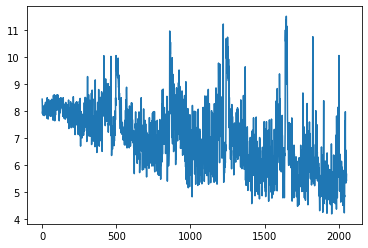

In [0]:
plt.plot(history)